In [1]:
import numpy as np
import pandas as pd
import os
import argparse
import logging

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader

from capstone_project.preprocessing import generate_dataloaders, load_data, split_data
from capstone_project.models.embedding_network import EmbeddingNetwork
from capstone_project.models.classification_network import ClassificationNetwork
from capstone_project.utils import *

import matplotlib.patheffects as PathEffects
import matplotlib.pyplot as plt
%matplotlib inline



In [2]:
PROJECT_DIR = '/home/kyt237/learning_visual_embeddings/'
DATA_DIR,  PLOTS_DIR, LOGGING_DIR = 'data', 'plots', 'logs'
CHECKPOINTS_DIR = 'checkpoints'
DATASET = 'mnist_test_seq.npy'
TEST_SIZE, VAL_SIZE = 0.2, 0.2

BATCH_SIZE = 64    # input batch size for training
N_EPOCHS = 200     # number of epochs to train
LR = 1e-4          # learning rate
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

NUM_PASSES_FOR_GENERATION = 1   # number of passes through data for pair generation
NUM_FRAMES_IN_STACK = 2         # number of (total) frames to concatenate for each video
NUM_PAIRS_PER_EXAMPLE = 5        # number of pairs to generate for given video and time difference
TIME_BUCKETS = [[0], [1], [2], [3,4], range(5,11,1)]

RS = 20150101 # Random state

In [3]:
import torch
import torch.nn as nn


def conv3x3(in_channels, out_channels, stride=1, padding=1, bias=False):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3,
                     stride=stride, padding=padding, bias=bias)


# Residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample

    def forward(self, input):
        residual = input
        output = self.conv1(input)
        output = self.bn1(output)
        output = self.relu(output)
        output = self.conv2(output)
        output = self.bn2(output)
        if self.downsample:
            residual = self.downsample(input)
        output += residual
        output = self.relu(output)
        return output


class EmbeddingNetwork(nn.Module):
    def __init__(self, in_dim, in_channels, hidden_size, out_dim, block=ResidualBlock, num_blocks=3):
        super(EmbeddingNetwork, self).__init__()
        self.in_dim = in_dim
        self.in_channels = in_channels

        # Conv-ReLU layers with batch-norm and downsampling
#         self.conv1 = conv3x3(in_channels, 32)
        self.conv1 = conv3x3(in_channels, 32, stride=2)  # NOTE: Use pool in _get_fc_input_size if using this
        self.bn1 = nn.BatchNorm2d(32)
#         self.conv2 = conv3x3(32, 64)
        self.conv2 = conv3x3(32, 64, stride=2)  # NOTE: Use pool in _get_fc_input_size if using this
        self.bn2 = nn.BatchNorm2d(64)
#         self.conv3 = conv3x3(64, 64)
        self.conv3 = conv3x3(64, 64, stride=2)  # NOTE: Use pool in _get_fc_input_size if using this
        self.bn3 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2)
        self.relu = nn.ReLU(inplace=True)

        # Residual layers
        self.residual_layers = self._make_layer(block, 64, 64, num_blocks)

        # Automatically get dimension of FC layer by using dummy input
        fc1_input_size = self._get_fc_input_size()
        #print(fc1_input_size)

        # Fully connected layers
        self.fc1 = nn.Linear(fc1_input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, out_dim)

        # Initialize weights
        self._init_weights()

    def forward(self, input):
        # Reshape input to batch_size x in_channels x height x width
        input = input.view(-1, self.in_channels, self.in_dim, self.in_dim)

        output = self.conv1(input)
        output = self.bn1(output)
        output = self.relu(output)

        output = self.conv2(output)
        output = self.bn2(output)
        output = self.relu(output)
#         output = self.pool(output) # NOTE: Use pool in _get_fc_input_size if using it here

        output = self.conv3(output)
        output = self.bn3(output)
        output = self.relu(output)
#         output = self.pool(output) # NOTE: Use pool in _get_fc_input_size if using it here

        # output = self.residual_layers(output)

        output = output.view(output.size(0), -1)
        output = self.fc1(output)
        output = self.fc2(output)
        output_n = torch.norm(output, p=2, dim=1, keepdim=True)
        output = output.div(output_n.expand_as(output))
        return output

    def _make_layer(self, block, in_channels, out_channels, num_blocks, stride=1, downsample=None):
        if (not downsample) and ((stride != 1) or (in_channels != out_channels)):
            downsample = nn.Sequential(conv3x3(in_channels, out_channels, stride=stride), nn.BatchNorm2d(out_channels))

        layers = [block(in_channels, out_channels, stride, downsample)]
        for i in range(num_blocks-1):
            # For residual blocks, in_channels = out_channels
            layers.append(block(out_channels, out_channels))

        return nn.Sequential(*layers)

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.uniform_(m.bias)

    def _get_fc_input_size(self):
        layers = nn.Sequential(self.conv1,
                            self.bn1,
                            self.relu,
                            self.conv2,
                            self.bn2,
                            self.relu,
#                             self.pool,
                            self.conv3,
                            self.bn3,
                            self.relu,
#                             self.pool,
                            self.residual_layers
                )

        with torch.no_grad():
            dummy_input = torch.zeros([1, self.in_channels, self.in_dim, self.in_dim]).float()
            dummy_output = layers(dummy_input)
            fc_size = dummy_output.flatten(0).shape[0]

        return fc_size

In [18]:
DATASET = 'moving_bars_20_121.npy'
data = load_data(PROJECT_DIR, DATA_DIR, DATASET)
train_data = split_data(data, VAL_SIZE, TEST_SIZE, PROJECT_DIR, DATA_DIR)['train']
val_data = split_data(data, VAL_SIZE, TEST_SIZE, PROJECT_DIR, DATA_DIR)['val']

In [19]:
train_data.shape

(146, 20, 121, 121)

In [20]:
img_dim = data.shape[-1]
in_dim = img_dim
in_dim, in_channels, out_dim = img_dim, NUM_FRAMES_IN_STACK, 1024
embedding_hidden_size, classification_hidden_size = 1024, 1024
num_outputs = len(TIME_BUCKETS)

In [21]:
class EmbeddingDataset(Dataset):
    def __init__(self, X, num_frames_in_stack, transforms=None):
        self.X = X
        self.transforms = transforms
        self.num_frames_in_stack = num_frames_in_stack
        self.seq_len = X.shape[1]

    def __getitem__(self, index):
        video = self.X[index]
        stacked_frames = []
        
        for frame in range(self.num_frames_in_stack-1, self.seq_len):
            frame_numbers = np.array(range(frame-self.num_frames_in_stack+1, frame+1))
            frames = video[frame_numbers]
            if self.transforms:
                frames = self.transforms(frames)
            stacked_frames.append(frames)
            
        return torch.from_numpy(np.array(stacked_frames)) # torch.from_numpy uses same memory

    def __len__(self):
        return len(self.X)

In [22]:
def get_embeddings(embedding_network, dataloader, device):
    all_embeddings = np.array([])
    all_videos = np.array([])
    embedding_network.eval()
    with torch.no_grad():
        for batch_idx, all_stacked_frames in enumerate(dataloader):
            # Reshape (64,19,2,121,121) -> (19,64,2,121,121)
            all_stacked_frames = all_stacked_frames.numpy().swapaxes(0, 1)
            all_stacked_frames = torch.from_numpy(all_stacked_frames).to(DEVICE).float()
            embeddings = []
            videos = np.array([])
            for stacked_frames in all_stacked_frames:
                embedding_output = embedding_network(stacked_frames).detach().cpu().numpy()
                embeddings.append(embedding_output)
                
                frames = stacked_frames.detach().cpu().numpy().swapaxes(0, 1) # (2,64,121,121)
                last_frame = np.array([frames[-1]])
                videos = np.vstack((videos, last_frame)) if videos.size else last_frame
            embeddings = np.array(embeddings).swapaxes(0, 1)
            all_embeddings = np.vstack((all_embeddings, embeddings)) if all_embeddings.size else embeddings
            
            videos = videos.swapaxes(0, 1)
            all_videos = np.vstack((all_videos, videos)) if all_videos.size else np.array(videos)
    return all_embeddings, all_videos

In [23]:
embedding_network = EmbeddingNetwork(in_dim, in_channels, embedding_hidden_size, out_dim).to(DEVICE)
classification_network = ClassificationNetwork(out_dim, classification_hidden_size, num_outputs).to(DEVICE)

In [24]:
criterion_train = nn.CrossEntropyLoss()
criterion_test = nn.CrossEntropyLoss(reduction='sum')
optimizer = optim.Adam(list(embedding_network.parameters()) + list(classification_network.parameters()), lr=LR)

In [25]:
embedding_network, classification_network, optimizer, train_loss_history, val_loss_history, train_accuracy_history, val_accuracy_history, epoch_trained = \
    load_checkpoint(embedding_network, classification_network, optimizer, 'state_dict_moving_bars_20_121_2_5_100.pkl', PROJECT_DIR, CHECKPOINTS_DIR, DEVICE)

In [26]:
train_embedding_dataset = EmbeddingDataset(train_data, NUM_FRAMES_IN_STACK)
val_embedding_dataset = EmbeddingDataset(val_data, NUM_FRAMES_IN_STACK)

In [27]:
train_dataloader = DataLoader(train_embedding_dataset, batch_size=64, shuffle=False, num_workers=4)
val_dataloader = DataLoader(val_embedding_dataset, batch_size=64, shuffle=False, num_workers=4)

In [28]:
train_embeddings_bars, train_videos_bars = get_embeddings(embedding_network, train_dataloader, DEVICE)
val_embeddings_bars, val_videos_bars = get_embeddings(embedding_network, val_dataloader, DEVICE)

In [29]:
train_embeddings_bars.shape

(146, 19, 1024)

In [30]:
val_videos_bars.shape

(48, 19, 121, 121)

In [31]:
train_embeddings_bars_seq = train_embeddings_bars.copy()
val_embeddings_bars_seq = val_embeddings_bars.copy()
train_videos_bars_seq = train_videos_bars.copy()
val_videos_bars_seq = val_videos_bars.copy()

In [32]:
train_embeddings_bars = train_embeddings_bars.reshape((-1,1024))
val_embeddings_bars = val_embeddings_bars.reshape((-1,1024))

In [33]:
val_embeddings_bars.shape

(912, 1024)

In [34]:
train_videos_bars = train_videos_bars.reshape((-1,121,121))
val_videos_bars = val_videos_bars.reshape((-1,121,121))

In [35]:
val_videos_bars.shape

(912, 121, 121)

In [36]:
val_videos_bars_seq.shape

(48, 19, 121, 121)

In [37]:
class DecoderDataset(Dataset):
    def __init__(self, X_embed, target_img, transforms=None):
        self.X_embed = X_embed
        self.target_img = target_img

    def __getitem__(self, index):
        return torch.from_numpy(self.X_embed[index]), torch.from_numpy(self.target_img[index])

    def __len__(self):
        return len(self.X_embed)

In [38]:
class DecoderNetwork(nn.Module):
    def __init__(self, emb_size,hidden_size):
        super(DecoderNetwork, self).__init__()
        self.emb_size,self.hidden_size = emb_size,hidden_size
        # Deconv layers
        self.deconv1 = nn.ConvTranspose2d(in_channels=64,out_channels=64,stride=2,padding=1,kernel_size=3,bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.deconv2 = nn.ConvTranspose2d(in_channels=64,out_channels=32,stride=2,padding=1,kernel_size=3,bias=False)
        self.bn2 = nn.BatchNorm2d(32)
        self.deconv3 = nn.ConvTranspose2d(in_channels=32,out_channels=1,stride=2,padding=1,kernel_size=3,bias=False)
        self.relu = nn.ReLU(inplace=True)
        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()
        self.fc1 = nn.Linear(emb_size,hidden_size)
        self.fc2 = nn.Linear(hidden_size,64*16*16)
        # Initialize weights
        self._init_weights()

    def forward(self, input):
        output = self.fc1(input)
        output = self.fc2(output)
        output = output.view(output.size(0),64,16,16)
        output = self.deconv1(output)
        output = self.bn1(output)
        output = self.relu(output)

        output = self.deconv2(output)
        output = self.bn2(output)
        output = self.relu(output)

        output = self.deconv3(output)
        #output = self.tanh(output)
        #trying to use a BCE loss and hence returning the outputs using a sigmoid
        output = self.sigmoid(output)
        return output.squeeze()

    def _init_weights(self):
        for m in self.modules():
            classname = m.__class__.__name__
            if classname.find('Conv') != -1:
                m.weight.data.normal_(0.0, 0.02)
            elif classname.find('BatchNorm') != -1:
                m.weight.data.normal_(1.0, 0.02)
                m.bias.data.fill_(0)


In [53]:
train_decoder_dataset = DecoderDataset(train_embeddings_bars,train_videos_bars)
train_decoder_dataloader = DataLoader(train_decoder_dataset, batch_size=64, shuffle=False)
val_decoder_dataset = DecoderDataset(val_embeddings_bars,val_videos_bars)
val_decoder_dataloader = DataLoader(val_decoder_dataset, batch_size=64, shuffle=False)

In [39]:
def train(decoder_network, dataloader, criterion, optimizer, device, epoch):
    loss_train = 0.
    for batch_idx, (x_embed, target_img) in enumerate(dataloader):
        x_embed, target_img = x_embed.to(device).float(), target_img.to(device).float()
        decoder_network.train()

        optimizer.zero_grad()

        gen_img = decoder_network(x_embed)
        #assert (gen_img.view(-1,121*121) >= 0. & gen_img.view(-1,121*121) <= 1.).all()
        #assert (target_img.view(-1,121*121) >= 0. & target_img.view(-1,121*121) <= 1.).all()


        loss = criterion(gen_img.view(-1,121*121), target_img.view(-1,target_img.size(1)*target_img.size(1)))
        loss.backward()
        optimizer.step()
        #print(len(dataloader.dataset))
        # Accurately compute loss, because of different batch size
        loss_train += loss.item() * len(x_embed) / len(dataloader.dataset)

        if (batch_idx+1) % (len(dataloader.dataset)//(20*target_img.shape[0])) == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, (batch_idx+1) * target_img.shape[0], len(dataloader.dataset),
                100. * (batch_idx+1) / len(dataloader), loss.item()))

    optimizer.zero_grad()
    return loss_train,gen_img.detach().cpu().numpy()

def test(decoder_network, dataloader, criterion, device):
    decoder_network.eval()
    loss_test = 0.
    with torch.no_grad():
        for batch_idx, (x_embed, target_img) in enumerate(dataloader):
            x_embed, target_img = x_embed.to(device).float(), target_img.to(device).float()
            gen_img = decoder_network(x_embed)
            loss = criterion(gen_img.view(-1,gen_img.size(1)*gen_img.size(1)), target_img.view(-1,target_img.size(1)*target_img.size(1)))

            # Accurately compute loss, because of different batch size
            loss_test += loss.item() / len(dataloader.dataset)
            
    return loss_test,gen_img.detach().cpu().numpy()


In [40]:
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [41]:
#DEVICE = 'cpu'

In [43]:
N_EPOCHS = 700

In [44]:
len(train_embeddings_bars)

2774

In [60]:
criterion = nn.BCELoss(reduction='sum')
criterion_test = nn.BCELoss(reduction='sum')
decoder_network = DecoderNetwork(emb_size=train_embeddings_bars.shape[1],hidden_size=1024).to(DEVICE)
optimizer = optim.Adam(decoder_network.parameters(), lr=LR)

for epoch in range(N_EPOCHS):
    train_loss,gen_img_temp_train = train(decoder_network,train_decoder_dataloader,criterion,optimizer,DEVICE,epoch)
    val_loss,gen_img_temp_val = test(decoder_network,val_decoder_dataloader,criterion_test,DEVICE)
    print('TRAIN Epoch: {}\tAverage loss: {:.4f}'.format(epoch, train_loss))
    print('VAL Epoch: {}\tAverage loss: {:.4f}'.format(epoch, val_loss))


    

Train Epoch: 0 [128/2774 (5%)]	Loss: 638388.937500
Train Epoch: 0 [256/2774 (9%)]	Loss: 633074.375000
Train Epoch: 0 [384/2774 (14%)]	Loss: 628420.125000
Train Epoch: 0 [512/2774 (18%)]	Loss: 624427.312500
Train Epoch: 0 [640/2774 (23%)]	Loss: 620509.625000
Train Epoch: 0 [768/2774 (27%)]	Loss: 616792.750000
Train Epoch: 0 [896/2774 (32%)]	Loss: 613159.812500
Train Epoch: 0 [1024/2774 (36%)]	Loss: 609674.687500
Train Epoch: 0 [1152/2774 (41%)]	Loss: 606150.687500
Train Epoch: 0 [1280/2774 (45%)]	Loss: 603138.375000
Train Epoch: 0 [1408/2774 (50%)]	Loss: 599884.625000
Train Epoch: 0 [1536/2774 (55%)]	Loss: 596727.125000
Train Epoch: 0 [1664/2774 (59%)]	Loss: 593573.250000
Train Epoch: 0 [1792/2774 (64%)]	Loss: 590691.687500
Train Epoch: 0 [1920/2774 (68%)]	Loss: 587671.312500
Train Epoch: 0 [2048/2774 (73%)]	Loss: 584766.625000
Train Epoch: 0 [2176/2774 (77%)]	Loss: 581866.750000
Train Epoch: 0 [2304/2774 (82%)]	Loss: 579031.250000
Train Epoch: 0 [2432/2774 (86%)]	Loss: 576157.500000
Tr

TRAIN Epoch: 6	Average loss: 317120.5867
VAL Epoch: 6	Average loss: 4688.1841
Train Epoch: 7 [128/2774 (5%)]	Loss: 301501.906250
Train Epoch: 7 [256/2774 (9%)]	Loss: 300495.937500
Train Epoch: 7 [384/2774 (14%)]	Loss: 299003.906250
Train Epoch: 7 [512/2774 (18%)]	Loss: 297698.187500
Train Epoch: 7 [640/2774 (23%)]	Loss: 296439.531250
Train Epoch: 7 [768/2774 (27%)]	Loss: 295084.843750
Train Epoch: 7 [896/2774 (32%)]	Loss: 293754.937500
Train Epoch: 7 [1024/2774 (36%)]	Loss: 292491.812500
Train Epoch: 7 [1152/2774 (41%)]	Loss: 291281.531250
Train Epoch: 7 [1280/2774 (45%)]	Loss: 290230.031250
Train Epoch: 7 [1408/2774 (50%)]	Loss: 288576.500000
Train Epoch: 7 [1536/2774 (55%)]	Loss: 287397.218750
Train Epoch: 7 [1664/2774 (59%)]	Loss: 286031.406250
Train Epoch: 7 [1792/2774 (64%)]	Loss: 284798.968750
Train Epoch: 7 [1920/2774 (68%)]	Loss: 283612.687500
Train Epoch: 7 [2048/2774 (73%)]	Loss: 282165.625000
Train Epoch: 7 [2176/2774 (77%)]	Loss: 280786.406250
Train Epoch: 7 [2304/2774 (82%

TRAIN Epoch: 13	Average loss: 171576.9715
VAL Epoch: 13	Average loss: 2611.3847
Train Epoch: 14 [128/2774 (5%)]	Loss: 165220.640625
Train Epoch: 14 [256/2774 (9%)]	Loss: 165074.625000
Train Epoch: 14 [384/2774 (14%)]	Loss: 164188.718750
Train Epoch: 14 [512/2774 (18%)]	Loss: 163778.453125
Train Epoch: 14 [640/2774 (23%)]	Loss: 163246.390625
Train Epoch: 14 [768/2774 (27%)]	Loss: 162646.484375
Train Epoch: 14 [896/2774 (32%)]	Loss: 162064.140625
Train Epoch: 14 [1024/2774 (36%)]	Loss: 161635.890625
Train Epoch: 14 [1152/2774 (41%)]	Loss: 161239.453125
Train Epoch: 14 [1280/2774 (45%)]	Loss: 160902.812500
Train Epoch: 14 [1408/2774 (50%)]	Loss: 160023.062500
Train Epoch: 14 [1536/2774 (55%)]	Loss: 159741.781250
Train Epoch: 14 [1664/2774 (59%)]	Loss: 158909.250000
Train Epoch: 14 [1792/2774 (64%)]	Loss: 158650.750000
Train Epoch: 14 [1920/2774 (68%)]	Loss: 158182.578125
Train Epoch: 14 [2048/2774 (73%)]	Loss: 157436.875000
Train Epoch: 14 [2176/2774 (77%)]	Loss: 156718.718750
Train Epoch

TRAIN Epoch: 20	Average loss: 107133.2829
VAL Epoch: 20	Average loss: 1661.8656
Train Epoch: 21 [128/2774 (5%)]	Loss: 103923.000000
Train Epoch: 21 [256/2774 (9%)]	Loss: 104028.601562
Train Epoch: 21 [384/2774 (14%)]	Loss: 103443.656250
Train Epoch: 21 [512/2774 (18%)]	Loss: 103375.593750
Train Epoch: 21 [640/2774 (23%)]	Loss: 103041.937500
Train Epoch: 21 [768/2774 (27%)]	Loss: 102726.609375
Train Epoch: 21 [896/2774 (32%)]	Loss: 102398.257812
Train Epoch: 21 [1024/2774 (36%)]	Loss: 102278.078125
Train Epoch: 21 [1152/2774 (41%)]	Loss: 102087.398438
Train Epoch: 21 [1280/2774 (45%)]	Loss: 102059.468750
Train Epoch: 21 [1408/2774 (50%)]	Loss: 101457.812500
Train Epoch: 21 [1536/2774 (55%)]	Loss: 101476.664062
Train Epoch: 21 [1664/2774 (59%)]	Loss: 100859.460938
Train Epoch: 21 [1792/2774 (64%)]	Loss: 100887.406250
Train Epoch: 21 [1920/2774 (68%)]	Loss: 100630.546875
Train Epoch: 21 [2048/2774 (73%)]	Loss: 100208.546875
Train Epoch: 21 [2176/2774 (77%)]	Loss: 99701.281250
Train Epoch:

TRAIN Epoch: 27	Average loss: 73364.7835
VAL Epoch: 27	Average loss: 1146.6523
Train Epoch: 28 [128/2774 (5%)]	Loss: 71432.945312
Train Epoch: 28 [256/2774 (9%)]	Loss: 71728.859375
Train Epoch: 28 [384/2774 (14%)]	Loss: 71235.023438
Train Epoch: 28 [512/2774 (18%)]	Loss: 71301.734375
Train Epoch: 28 [640/2774 (23%)]	Loss: 71019.085938
Train Epoch: 28 [768/2774 (27%)]	Loss: 70948.789062
Train Epoch: 28 [896/2774 (32%)]	Loss: 70669.203125
Train Epoch: 28 [1024/2774 (36%)]	Loss: 70628.546875
Train Epoch: 28 [1152/2774 (41%)]	Loss: 70586.890625
Train Epoch: 28 [1280/2774 (45%)]	Loss: 70666.632812
Train Epoch: 28 [1408/2774 (50%)]	Loss: 70148.218750
Train Epoch: 28 [1536/2774 (55%)]	Loss: 70363.093750
Train Epoch: 28 [1664/2774 (59%)]	Loss: 69810.156250
Train Epoch: 28 [1792/2774 (64%)]	Loss: 69959.343750
Train Epoch: 28 [1920/2774 (68%)]	Loss: 69782.468750
Train Epoch: 28 [2048/2774 (73%)]	Loss: 69542.078125
Train Epoch: 28 [2176/2774 (77%)]	Loss: 69150.359375
Train Epoch: 28 [2304/2774 (8

TRAIN Epoch: 34	Average loss: 53585.1969
VAL Epoch: 34	Average loss: 841.5480
Train Epoch: 35 [128/2774 (5%)]	Loss: 52284.804688
Train Epoch: 35 [256/2774 (9%)]	Loss: 52632.980469
Train Epoch: 35 [384/2774 (14%)]	Loss: 52129.718750
Train Epoch: 35 [512/2774 (18%)]	Loss: 52440.007812
Train Epoch: 35 [640/2774 (23%)]	Loss: 52191.460938
Train Epoch: 35 [768/2774 (27%)]	Loss: 52042.886719
Train Epoch: 35 [896/2774 (32%)]	Loss: 51865.562500
Train Epoch: 35 [1024/2774 (36%)]	Loss: 51921.777344
Train Epoch: 35 [1152/2774 (41%)]	Loss: 51963.468750
Train Epoch: 35 [1280/2774 (45%)]	Loss: 52017.656250
Train Epoch: 35 [1408/2774 (50%)]	Loss: 51578.648438
Train Epoch: 35 [1536/2774 (55%)]	Loss: 51876.906250
Train Epoch: 35 [1664/2774 (59%)]	Loss: 51294.902344
Train Epoch: 35 [1792/2774 (64%)]	Loss: 51644.429688
Train Epoch: 35 [1920/2774 (68%)]	Loss: 51522.164062
Train Epoch: 35 [2048/2774 (73%)]	Loss: 51278.191406
Train Epoch: 35 [2176/2774 (77%)]	Loss: 50927.414062
Train Epoch: 35 [2304/2774 (82

TRAIN Epoch: 41	Average loss: 40871.1032
VAL Epoch: 41	Average loss: 653.2893
Train Epoch: 42 [128/2774 (5%)]	Loss: 39856.031250
Train Epoch: 42 [256/2774 (9%)]	Loss: 40297.167969
Train Epoch: 42 [384/2774 (14%)]	Loss: 39800.292969
Train Epoch: 42 [512/2774 (18%)]	Loss: 40139.531250
Train Epoch: 42 [640/2774 (23%)]	Loss: 39942.437500
Train Epoch: 42 [768/2774 (27%)]	Loss: 39812.843750
Train Epoch: 42 [896/2774 (32%)]	Loss: 39671.910156
Train Epoch: 42 [1024/2774 (36%)]	Loss: 39694.472656
Train Epoch: 42 [1152/2774 (41%)]	Loss: 39866.363281
Train Epoch: 42 [1280/2774 (45%)]	Loss: 39919.421875
Train Epoch: 42 [1408/2774 (50%)]	Loss: 39378.265625
Train Epoch: 42 [1536/2774 (55%)]	Loss: 39863.660156
Train Epoch: 42 [1664/2774 (59%)]	Loss: 39195.617188
Train Epoch: 42 [1792/2774 (64%)]	Loss: 39583.566406
Train Epoch: 42 [1920/2774 (68%)]	Loss: 39600.839844
Train Epoch: 42 [2048/2774 (73%)]	Loss: 39336.191406
Train Epoch: 42 [2176/2774 (77%)]	Loss: 38996.203125
Train Epoch: 42 [2304/2774 (82

TRAIN Epoch: 48	Average loss: 31843.7397
VAL Epoch: 48	Average loss: 508.7159
Train Epoch: 49 [128/2774 (5%)]	Loss: 31034.142578
Train Epoch: 49 [256/2774 (9%)]	Loss: 31427.416016
Train Epoch: 49 [384/2774 (14%)]	Loss: 30976.335938
Train Epoch: 49 [512/2774 (18%)]	Loss: 31155.929688
Train Epoch: 49 [640/2774 (23%)]	Loss: 31011.769531
Train Epoch: 49 [768/2774 (27%)]	Loss: 31008.531250
Train Epoch: 49 [896/2774 (32%)]	Loss: 30936.259766
Train Epoch: 49 [1024/2774 (36%)]	Loss: 30972.316406
Train Epoch: 49 [1152/2774 (41%)]	Loss: 31191.894531
Train Epoch: 49 [1280/2774 (45%)]	Loss: 31291.798828
Train Epoch: 49 [1408/2774 (50%)]	Loss: 30755.546875
Train Epoch: 49 [1536/2774 (55%)]	Loss: 31114.845703
Train Epoch: 49 [1664/2774 (59%)]	Loss: 30542.451172
Train Epoch: 49 [1792/2774 (64%)]	Loss: 31022.962891
Train Epoch: 49 [1920/2774 (68%)]	Loss: 31080.085938
Train Epoch: 49 [2048/2774 (73%)]	Loss: 30803.544922
Train Epoch: 49 [2176/2774 (77%)]	Loss: 30351.742188
Train Epoch: 49 [2304/2774 (82

Train Epoch: 55 [2688/2774 (95%)]	Loss: 25291.050781
TRAIN Epoch: 55	Average loss: 25692.1322
VAL Epoch: 55	Average loss: 407.5846
Train Epoch: 56 [128/2774 (5%)]	Loss: 25175.548828
Train Epoch: 56 [256/2774 (9%)]	Loss: 25500.019531
Train Epoch: 56 [384/2774 (14%)]	Loss: 25185.193359
Train Epoch: 56 [512/2774 (18%)]	Loss: 25284.421875
Train Epoch: 56 [640/2774 (23%)]	Loss: 25138.943359
Train Epoch: 56 [768/2774 (27%)]	Loss: 25124.585938
Train Epoch: 56 [896/2774 (32%)]	Loss: 25126.462891
Train Epoch: 56 [1024/2774 (36%)]	Loss: 25084.916016
Train Epoch: 56 [1152/2774 (41%)]	Loss: 25290.664062
Train Epoch: 56 [1280/2774 (45%)]	Loss: 25417.263672
Train Epoch: 56 [1408/2774 (50%)]	Loss: 24814.636719
Train Epoch: 56 [1536/2774 (55%)]	Loss: 25146.207031
Train Epoch: 56 [1664/2774 (59%)]	Loss: 24849.328125
Train Epoch: 56 [1792/2774 (64%)]	Loss: 25188.375000
Train Epoch: 56 [1920/2774 (68%)]	Loss: 25307.042969
Train Epoch: 56 [2048/2774 (73%)]	Loss: 25031.771484
Train Epoch: 56 [2176/2774 (77

TRAIN Epoch: 62	Average loss: 21670.0038
VAL Epoch: 62	Average loss: 342.9209
Train Epoch: 63 [128/2774 (5%)]	Loss: 21272.792969
Train Epoch: 63 [256/2774 (9%)]	Loss: 21518.068359
Train Epoch: 63 [384/2774 (14%)]	Loss: 21300.937500
Train Epoch: 63 [512/2774 (18%)]	Loss: 21326.589844
Train Epoch: 63 [640/2774 (23%)]	Loss: 21288.373047
Train Epoch: 63 [768/2774 (27%)]	Loss: 21247.814453
Train Epoch: 63 [896/2774 (32%)]	Loss: 21313.853516
Train Epoch: 63 [1024/2774 (36%)]	Loss: 21238.080078
Train Epoch: 63 [1152/2774 (41%)]	Loss: 21409.630859
Train Epoch: 63 [1280/2774 (45%)]	Loss: 21601.654297
Train Epoch: 63 [1408/2774 (50%)]	Loss: 21027.224609
Train Epoch: 63 [1536/2774 (55%)]	Loss: 21274.556641
Train Epoch: 63 [1664/2774 (59%)]	Loss: 21106.222656
Train Epoch: 63 [1792/2774 (64%)]	Loss: 21388.410156
Train Epoch: 63 [1920/2774 (68%)]	Loss: 21554.818359
Train Epoch: 63 [2048/2774 (73%)]	Loss: 21235.593750
Train Epoch: 63 [2176/2774 (77%)]	Loss: 20925.617188
Train Epoch: 63 [2304/2774 (82

TRAIN Epoch: 69	Average loss: 18801.1488
VAL Epoch: 69	Average loss: 297.1277
Train Epoch: 70 [128/2774 (5%)]	Loss: 18464.583984
Train Epoch: 70 [256/2774 (9%)]	Loss: 18737.582031
Train Epoch: 70 [384/2774 (14%)]	Loss: 18530.710938
Train Epoch: 70 [512/2774 (18%)]	Loss: 18557.345703
Train Epoch: 70 [640/2774 (23%)]	Loss: 18521.455078
Train Epoch: 70 [768/2774 (27%)]	Loss: 18494.945312
Train Epoch: 70 [896/2774 (32%)]	Loss: 18575.230469
Train Epoch: 70 [1024/2774 (36%)]	Loss: 18486.255859
Train Epoch: 70 [1152/2774 (41%)]	Loss: 18661.595703
Train Epoch: 70 [1280/2774 (45%)]	Loss: 18856.757812
Train Epoch: 70 [1408/2774 (50%)]	Loss: 18296.816406
Train Epoch: 70 [1536/2774 (55%)]	Loss: 18497.419922
Train Epoch: 70 [1664/2774 (59%)]	Loss: 18372.453125
Train Epoch: 70 [1792/2774 (64%)]	Loss: 18577.691406
Train Epoch: 70 [1920/2774 (68%)]	Loss: 18731.828125
Train Epoch: 70 [2048/2774 (73%)]	Loss: 18498.798828
Train Epoch: 70 [2176/2774 (77%)]	Loss: 18196.363281
Train Epoch: 70 [2304/2774 (82

TRAIN Epoch: 76	Average loss: 16648.2233
VAL Epoch: 76	Average loss: 262.6697
Train Epoch: 77 [128/2774 (5%)]	Loss: 16339.776367
Train Epoch: 77 [256/2774 (9%)]	Loss: 16625.662109
Train Epoch: 77 [384/2774 (14%)]	Loss: 16427.234375
Train Epoch: 77 [512/2774 (18%)]	Loss: 16462.824219
Train Epoch: 77 [640/2774 (23%)]	Loss: 16423.677734
Train Epoch: 77 [768/2774 (27%)]	Loss: 16395.675781
Train Epoch: 77 [896/2774 (32%)]	Loss: 16483.980469
Train Epoch: 77 [1024/2774 (36%)]	Loss: 16394.478516
Train Epoch: 77 [1152/2774 (41%)]	Loss: 16551.160156
Train Epoch: 77 [1280/2774 (45%)]	Loss: 16750.332031
Train Epoch: 77 [1408/2774 (50%)]	Loss: 16227.270508
Train Epoch: 77 [1536/2774 (55%)]	Loss: 16389.343750
Train Epoch: 77 [1664/2774 (59%)]	Loss: 16299.632812
Train Epoch: 77 [1792/2774 (64%)]	Loss: 16475.250000
Train Epoch: 77 [1920/2774 (68%)]	Loss: 16614.205078
Train Epoch: 77 [2048/2774 (73%)]	Loss: 16423.808594
Train Epoch: 77 [2176/2774 (77%)]	Loss: 16137.173828
Train Epoch: 77 [2304/2774 (82

TRAIN Epoch: 83	Average loss: 14782.2557
VAL Epoch: 83	Average loss: 230.8968
Train Epoch: 84 [128/2774 (5%)]	Loss: 14461.943359
Train Epoch: 84 [256/2774 (9%)]	Loss: 14737.532227
Train Epoch: 84 [384/2774 (14%)]	Loss: 14546.117188
Train Epoch: 84 [512/2774 (18%)]	Loss: 14609.470703
Train Epoch: 84 [640/2774 (23%)]	Loss: 14554.523438
Train Epoch: 84 [768/2774 (27%)]	Loss: 14530.666992
Train Epoch: 84 [896/2774 (32%)]	Loss: 14597.714844
Train Epoch: 84 [1024/2774 (36%)]	Loss: 14539.791992
Train Epoch: 84 [1152/2774 (41%)]	Loss: 14662.773438
Train Epoch: 84 [1280/2774 (45%)]	Loss: 14862.455078
Train Epoch: 84 [1408/2774 (50%)]	Loss: 14401.351562
Train Epoch: 84 [1536/2774 (55%)]	Loss: 14529.421875
Train Epoch: 84 [1664/2774 (59%)]	Loss: 14461.291992
Train Epoch: 84 [1792/2774 (64%)]	Loss: 14635.094727
Train Epoch: 84 [1920/2774 (68%)]	Loss: 14743.741211
Train Epoch: 84 [2048/2774 (73%)]	Loss: 14577.271484
Train Epoch: 84 [2176/2774 (77%)]	Loss: 14319.898438
Train Epoch: 84 [2304/2774 (82

Train Epoch: 91 [384/2774 (14%)]	Loss: 12326.961914
Train Epoch: 91 [512/2774 (18%)]	Loss: 12431.049805
Train Epoch: 91 [640/2774 (23%)]	Loss: 12338.284180
Train Epoch: 91 [768/2774 (27%)]	Loss: 12300.166016
Train Epoch: 91 [896/2774 (32%)]	Loss: 12314.627930
Train Epoch: 91 [1024/2774 (36%)]	Loss: 12296.312500
Train Epoch: 91 [1152/2774 (41%)]	Loss: 12394.522461
Train Epoch: 91 [1280/2774 (45%)]	Loss: 12476.959961
Train Epoch: 91 [1408/2774 (50%)]	Loss: 12173.694336
Train Epoch: 91 [1536/2774 (55%)]	Loss: 12273.541016
Train Epoch: 91 [1664/2774 (59%)]	Loss: 12132.572266
Train Epoch: 91 [1792/2774 (64%)]	Loss: 12288.449219
Train Epoch: 91 [1920/2774 (68%)]	Loss: 12333.098633
Train Epoch: 91 [2048/2774 (73%)]	Loss: 12213.346680
Train Epoch: 91 [2176/2774 (77%)]	Loss: 12025.938477
Train Epoch: 91 [2304/2774 (82%)]	Loss: 12043.091797
Train Epoch: 91 [2432/2774 (86%)]	Loss: 12136.002930
Train Epoch: 91 [2560/2774 (91%)]	Loss: 12216.168945
Train Epoch: 91 [2688/2774 (95%)]	Loss: 11925.28418

Train Epoch: 98 [1024/2774 (36%)]	Loss: 9554.621094
Train Epoch: 98 [1152/2774 (41%)]	Loss: 9564.849609
Train Epoch: 98 [1280/2774 (45%)]	Loss: 9561.008789
Train Epoch: 98 [1408/2774 (50%)]	Loss: 9466.302734
Train Epoch: 98 [1536/2774 (55%)]	Loss: 9520.248047
Train Epoch: 98 [1664/2774 (59%)]	Loss: 9414.277344
Train Epoch: 98 [1792/2774 (64%)]	Loss: 9514.631836
Train Epoch: 98 [1920/2774 (68%)]	Loss: 9463.543945
Train Epoch: 98 [2048/2774 (73%)]	Loss: 9423.349609
Train Epoch: 98 [2176/2774 (77%)]	Loss: 9334.421875
Train Epoch: 98 [2304/2774 (82%)]	Loss: 9330.126953
Train Epoch: 98 [2432/2774 (86%)]	Loss: 9361.647461
Train Epoch: 98 [2560/2774 (91%)]	Loss: 9351.066406
Train Epoch: 98 [2688/2774 (95%)]	Loss: 9251.185547
TRAIN Epoch: 98	Average loss: 9445.6978
VAL Epoch: 98	Average loss: 147.5850
Train Epoch: 99 [128/2774 (5%)]	Loss: 9244.337891
Train Epoch: 99 [256/2774 (9%)]	Loss: 9294.549805
Train Epoch: 99 [384/2774 (14%)]	Loss: 9187.216797
Train Epoch: 99 [512/2774 (18%)]	Loss: 9291.

Train Epoch: 105 [1024/2774 (36%)]	Loss: 7527.607422
Train Epoch: 105 [1152/2774 (41%)]	Loss: 7543.146484
Train Epoch: 105 [1280/2774 (45%)]	Loss: 7455.635742
Train Epoch: 105 [1408/2774 (50%)]	Loss: 7485.175781
Train Epoch: 105 [1536/2774 (55%)]	Loss: 7500.071289
Train Epoch: 105 [1664/2774 (59%)]	Loss: 7440.341309
Train Epoch: 105 [1792/2774 (64%)]	Loss: 7455.890137
Train Epoch: 105 [1920/2774 (68%)]	Loss: 7415.593750
Train Epoch: 105 [2048/2774 (73%)]	Loss: 7420.082031
Train Epoch: 105 [2176/2774 (77%)]	Loss: 7418.551758
Train Epoch: 105 [2304/2774 (82%)]	Loss: 7394.185547
Train Epoch: 105 [2432/2774 (86%)]	Loss: 7383.650879
Train Epoch: 105 [2560/2774 (91%)]	Loss: 7363.432617
Train Epoch: 105 [2688/2774 (95%)]	Loss: 7377.074707
TRAIN Epoch: 105	Average loss: 7431.0435
VAL Epoch: 105	Average loss: 116.7132
Train Epoch: 106 [128/2774 (5%)]	Loss: 7385.861816
Train Epoch: 106 [256/2774 (9%)]	Loss: 7351.846680
Train Epoch: 106 [384/2774 (14%)]	Loss: 7313.245605
Train Epoch: 106 [512/277

Train Epoch: 112 [1024/2774 (36%)]	Loss: 6303.991699
Train Epoch: 112 [1152/2774 (41%)]	Loss: 6280.391602
Train Epoch: 112 [1280/2774 (45%)]	Loss: 6172.165039
Train Epoch: 112 [1408/2774 (50%)]	Loss: 6296.244141
Train Epoch: 112 [1536/2774 (55%)]	Loss: 6277.244629
Train Epoch: 112 [1664/2774 (59%)]	Loss: 6253.601562
Train Epoch: 112 [1792/2774 (64%)]	Loss: 6228.192871
Train Epoch: 112 [1920/2774 (68%)]	Loss: 6174.457520
Train Epoch: 112 [2048/2774 (73%)]	Loss: 6212.361816
Train Epoch: 112 [2176/2774 (77%)]	Loss: 6258.050293
Train Epoch: 112 [2304/2774 (82%)]	Loss: 6220.420410
Train Epoch: 112 [2432/2774 (86%)]	Loss: 6185.184570
Train Epoch: 112 [2560/2774 (91%)]	Loss: 6136.649902
Train Epoch: 112 [2688/2774 (95%)]	Loss: 6230.929688
TRAIN Epoch: 112	Average loss: 6216.8805
VAL Epoch: 112	Average loss: 97.8271
Train Epoch: 113 [128/2774 (5%)]	Loss: 6247.256836
Train Epoch: 113 [256/2774 (9%)]	Loss: 6170.947266
Train Epoch: 113 [384/2774 (14%)]	Loss: 6171.088867
Train Epoch: 113 [512/2774

Train Epoch: 119 [1024/2774 (36%)]	Loss: 5485.340820
Train Epoch: 119 [1152/2774 (41%)]	Loss: 5454.958984
Train Epoch: 119 [1280/2774 (45%)]	Loss: 5330.907715
Train Epoch: 119 [1408/2774 (50%)]	Loss: 5496.543945
Train Epoch: 119 [1536/2774 (55%)]	Loss: 5462.799805
Train Epoch: 119 [1664/2774 (59%)]	Loss: 5450.040527
Train Epoch: 119 [1792/2774 (64%)]	Loss: 5411.578125
Train Epoch: 119 [1920/2774 (68%)]	Loss: 5347.083008
Train Epoch: 119 [2048/2774 (73%)]	Loss: 5398.010254
Train Epoch: 119 [2176/2774 (77%)]	Loss: 5472.441895
Train Epoch: 119 [2304/2774 (82%)]	Loss: 5426.146484
Train Epoch: 119 [2432/2774 (86%)]	Loss: 5377.960449
Train Epoch: 119 [2560/2774 (91%)]	Loss: 5327.052246
Train Epoch: 119 [2688/2774 (95%)]	Loss: 5459.973145
TRAIN Epoch: 119	Average loss: 5401.6671
VAL Epoch: 119	Average loss: 85.0968
Train Epoch: 120 [128/2774 (5%)]	Loss: 5472.136719
Train Epoch: 120 [256/2774 (9%)]	Loss: 5379.973633
Train Epoch: 120 [384/2774 (14%)]	Loss: 5394.875977
Train Epoch: 120 [512/2774

Train Epoch: 126 [1024/2774 (36%)]	Loss: 4781.042969
Train Epoch: 126 [1152/2774 (41%)]	Loss: 4726.875977
Train Epoch: 126 [1280/2774 (45%)]	Loss: 4591.475586
Train Epoch: 126 [1408/2774 (50%)]	Loss: 4826.216309
Train Epoch: 126 [1536/2774 (55%)]	Loss: 4793.356445
Train Epoch: 126 [1664/2774 (59%)]	Loss: 4746.910156
Train Epoch: 126 [1792/2774 (64%)]	Loss: 4708.899414
Train Epoch: 126 [1920/2774 (68%)]	Loss: 4625.475586
Train Epoch: 126 [2048/2774 (73%)]	Loss: 4684.779297
Train Epoch: 126 [2176/2774 (77%)]	Loss: 4784.199219
Train Epoch: 126 [2304/2774 (82%)]	Loss: 4719.313477
Train Epoch: 126 [2432/2774 (86%)]	Loss: 4668.547363
Train Epoch: 126 [2560/2774 (91%)]	Loss: 4608.547363
Train Epoch: 126 [2688/2774 (95%)]	Loss: 4778.355957
TRAIN Epoch: 126	Average loss: 4700.1947
VAL Epoch: 126	Average loss: 73.8563
Train Epoch: 127 [128/2774 (5%)]	Loss: 4779.186523
Train Epoch: 127 [256/2774 (9%)]	Loss: 4679.226074
Train Epoch: 127 [384/2774 (14%)]	Loss: 4686.050781
Train Epoch: 127 [512/2774

Train Epoch: 133 [1024/2774 (36%)]	Loss: 4300.980957
Train Epoch: 133 [1152/2774 (41%)]	Loss: 4232.979492
Train Epoch: 133 [1280/2774 (45%)]	Loss: 4096.716309
Train Epoch: 133 [1408/2774 (50%)]	Loss: 4359.361328
Train Epoch: 133 [1536/2774 (55%)]	Loss: 4302.470215
Train Epoch: 133 [1664/2774 (59%)]	Loss: 4281.954102
Train Epoch: 133 [1792/2774 (64%)]	Loss: 4224.092285
Train Epoch: 133 [1920/2774 (68%)]	Loss: 4152.319824
Train Epoch: 133 [2048/2774 (73%)]	Loss: 4213.917969
Train Epoch: 133 [2176/2774 (77%)]	Loss: 4337.310059
Train Epoch: 133 [2304/2774 (82%)]	Loss: 4266.612793
Train Epoch: 133 [2432/2774 (86%)]	Loss: 4205.797852
Train Epoch: 133 [2560/2774 (91%)]	Loss: 4140.740234
Train Epoch: 133 [2688/2774 (95%)]	Loss: 4332.974609
TRAIN Epoch: 133	Average loss: 4222.5680
VAL Epoch: 133	Average loss: 66.3811
Train Epoch: 134 [128/2774 (5%)]	Loss: 4330.094727
Train Epoch: 134 [256/2774 (9%)]	Loss: 4209.696777
Train Epoch: 134 [384/2774 (14%)]	Loss: 4250.102051
Train Epoch: 134 [512/2774

Train Epoch: 140 [1408/2774 (50%)]	Loss: 4063.100098
Train Epoch: 140 [1536/2774 (55%)]	Loss: 3999.213379
Train Epoch: 140 [1664/2774 (59%)]	Loss: 3984.826416
Train Epoch: 140 [1792/2774 (64%)]	Loss: 3921.855713
Train Epoch: 140 [1920/2774 (68%)]	Loss: 3848.561279
Train Epoch: 140 [2048/2774 (73%)]	Loss: 3913.777344
Train Epoch: 140 [2176/2774 (77%)]	Loss: 4047.375244
Train Epoch: 140 [2304/2774 (82%)]	Loss: 3974.060547
Train Epoch: 140 [2432/2774 (86%)]	Loss: 3908.079590
Train Epoch: 140 [2560/2774 (91%)]	Loss: 3839.316406
Train Epoch: 140 [2688/2774 (95%)]	Loss: 4043.253174
TRAIN Epoch: 140	Average loss: 3921.7724
VAL Epoch: 140	Average loss: 61.6178
Train Epoch: 141 [128/2774 (5%)]	Loss: 4039.732910
Train Epoch: 141 [256/2774 (9%)]	Loss: 3910.037354
Train Epoch: 141 [384/2774 (14%)]	Loss: 3962.066895
Train Epoch: 141 [512/2774 (18%)]	Loss: 3965.150391
Train Epoch: 141 [640/2774 (23%)]	Loss: 3965.448730
Train Epoch: 141 [768/2774 (27%)]	Loss: 3963.719727
Train Epoch: 141 [896/2774 (3

Train Epoch: 147 [2048/2774 (73%)]	Loss: 3687.541504
Train Epoch: 147 [2176/2774 (77%)]	Loss: 3827.535400
Train Epoch: 147 [2304/2774 (82%)]	Loss: 3752.289062
Train Epoch: 147 [2432/2774 (86%)]	Loss: 3683.188721
Train Epoch: 147 [2560/2774 (91%)]	Loss: 3611.316650
Train Epoch: 147 [2688/2774 (95%)]	Loss: 3824.350586
TRAIN Epoch: 147	Average loss: 3695.0934
VAL Epoch: 147	Average loss: 58.0627
Train Epoch: 148 [128/2774 (5%)]	Loss: 3820.840332
Train Epoch: 148 [256/2774 (9%)]	Loss: 3684.512939
Train Epoch: 148 [384/2774 (14%)]	Loss: 3743.951416
Train Epoch: 148 [512/2774 (18%)]	Loss: 3745.732910
Train Epoch: 148 [640/2774 (23%)]	Loss: 3746.442871
Train Epoch: 148 [768/2774 (27%)]	Loss: 3744.752197
Train Epoch: 148 [896/2774 (32%)]	Loss: 3667.081543
Train Epoch: 148 [1024/2774 (36%)]	Loss: 3742.189453
Train Epoch: 148 [1152/2774 (41%)]	Loss: 3668.965332
Train Epoch: 148 [1280/2774 (45%)]	Loss: 3523.781982
Train Epoch: 148 [1408/2774 (50%)]	Loss: 3812.287842
Train Epoch: 148 [1536/2774 (5

Train Epoch: 154 [2048/2774 (73%)]	Loss: 4278.416992
Train Epoch: 154 [2176/2774 (77%)]	Loss: 4117.386719
Train Epoch: 154 [2304/2774 (82%)]	Loss: 4024.747559
Train Epoch: 154 [2432/2774 (86%)]	Loss: 4049.623535
Train Epoch: 154 [2560/2774 (91%)]	Loss: 3830.150391
Train Epoch: 154 [2688/2774 (95%)]	Loss: 4185.140625
TRAIN Epoch: 154	Average loss: 4428.4652
VAL Epoch: 154	Average loss: 62.7602
Train Epoch: 155 [128/2774 (5%)]	Loss: 4077.194092
Train Epoch: 155 [256/2774 (9%)]	Loss: 3881.408691
Train Epoch: 155 [384/2774 (14%)]	Loss: 3875.418457
Train Epoch: 155 [512/2774 (18%)]	Loss: 3822.238770
Train Epoch: 155 [640/2774 (23%)]	Loss: 3841.621338
Train Epoch: 155 [768/2774 (27%)]	Loss: 3864.707031
Train Epoch: 155 [896/2774 (32%)]	Loss: 3707.574951
Train Epoch: 155 [1024/2774 (36%)]	Loss: 3781.676758
Train Epoch: 155 [1152/2774 (41%)]	Loss: 3756.954834
Train Epoch: 155 [1280/2774 (45%)]	Loss: 3525.692627
Train Epoch: 155 [1408/2774 (50%)]	Loss: 3840.236572
Train Epoch: 155 [1536/2774 (5

Train Epoch: 161 [2048/2774 (73%)]	Loss: 3382.120605
Train Epoch: 161 [2176/2774 (77%)]	Loss: 3532.280029
Train Epoch: 161 [2304/2774 (82%)]	Loss: 3455.125244
Train Epoch: 161 [2432/2774 (86%)]	Loss: 3381.796143
Train Epoch: 161 [2560/2774 (91%)]	Loss: 3299.522461
Train Epoch: 161 [2688/2774 (95%)]	Loss: 3527.714355
TRAIN Epoch: 161	Average loss: 3389.8689
VAL Epoch: 161	Average loss: 53.2981
Train Epoch: 162 [128/2774 (5%)]	Loss: 3532.820312
Train Epoch: 162 [256/2774 (9%)]	Loss: 3378.495361
Train Epoch: 162 [384/2774 (14%)]	Loss: 3448.656738
Train Epoch: 162 [512/2774 (18%)]	Loss: 3447.865723
Train Epoch: 162 [640/2774 (23%)]	Loss: 3442.781982
Train Epoch: 162 [768/2774 (27%)]	Loss: 3444.738281
Train Epoch: 162 [896/2774 (32%)]	Loss: 3369.472412
Train Epoch: 162 [1024/2774 (36%)]	Loss: 3441.148926
Train Epoch: 162 [1152/2774 (41%)]	Loss: 3365.998047
Train Epoch: 162 [1280/2774 (45%)]	Loss: 3211.320557
Train Epoch: 162 [1408/2774 (50%)]	Loss: 3512.486572
Train Epoch: 162 [1536/2774 (5

Train Epoch: 168 [2048/2774 (73%)]	Loss: 3250.638428
Train Epoch: 168 [2176/2774 (77%)]	Loss: 3403.666016
Train Epoch: 168 [2304/2774 (82%)]	Loss: 3325.156982
Train Epoch: 168 [2432/2774 (86%)]	Loss: 3250.240723
Train Epoch: 168 [2560/2774 (91%)]	Loss: 3170.142822
Train Epoch: 168 [2688/2774 (95%)]	Loss: 3400.594727
TRAIN Epoch: 168	Average loss: 3258.2208
VAL Epoch: 168	Average loss: 51.2210
Train Epoch: 169 [128/2774 (5%)]	Loss: 3402.655029
Train Epoch: 169 [256/2774 (9%)]	Loss: 3248.576416
Train Epoch: 169 [384/2774 (14%)]	Loss: 3320.862793
Train Epoch: 169 [512/2774 (18%)]	Loss: 3320.457520
Train Epoch: 169 [640/2774 (23%)]	Loss: 3318.024902
Train Epoch: 169 [768/2774 (27%)]	Loss: 3318.434570
Train Epoch: 169 [896/2774 (32%)]	Loss: 3241.022949
Train Epoch: 169 [1024/2774 (36%)]	Loss: 3316.647217
Train Epoch: 169 [1152/2774 (41%)]	Loss: 3239.324219
Train Epoch: 169 [1280/2774 (45%)]	Loss: 3083.994629
Train Epoch: 169 [1408/2774 (50%)]	Loss: 3390.644287
Train Epoch: 169 [1536/2774 (5

Train Epoch: 175 [1920/2774 (68%)]	Loss: 3075.458252
Train Epoch: 175 [2048/2774 (73%)]	Loss: 3152.602295
Train Epoch: 175 [2176/2774 (77%)]	Loss: 3307.342041
Train Epoch: 175 [2304/2774 (82%)]	Loss: 3228.276123
Train Epoch: 175 [2432/2774 (86%)]	Loss: 3151.608398
Train Epoch: 175 [2560/2774 (91%)]	Loss: 3071.412842
Train Epoch: 175 [2688/2774 (95%)]	Loss: 3305.178711
TRAIN Epoch: 175	Average loss: 3159.8561
VAL Epoch: 175	Average loss: 49.6775
Train Epoch: 176 [128/2774 (5%)]	Loss: 3305.669922
Train Epoch: 176 [256/2774 (9%)]	Loss: 3150.832031
Train Epoch: 176 [384/2774 (14%)]	Loss: 3224.533691
Train Epoch: 176 [512/2774 (18%)]	Loss: 3224.559082
Train Epoch: 176 [640/2774 (23%)]	Loss: 3223.559326
Train Epoch: 176 [768/2774 (27%)]	Loss: 3223.211670
Train Epoch: 176 [896/2774 (32%)]	Loss: 3144.638672
Train Epoch: 176 [1024/2774 (36%)]	Loss: 3222.106934
Train Epoch: 176 [1152/2774 (41%)]	Loss: 3143.490234
Train Epoch: 176 [1280/2774 (45%)]	Loss: 2986.999756
Train Epoch: 176 [1408/2774 (5

Train Epoch: 182 [1920/2774 (68%)]	Loss: 2996.203613
Train Epoch: 182 [2048/2774 (73%)]	Loss: 3073.829346
Train Epoch: 182 [2176/2774 (77%)]	Loss: 3230.642090
Train Epoch: 182 [2304/2774 (82%)]	Loss: 3150.645264
Train Epoch: 182 [2432/2774 (86%)]	Loss: 3072.960449
Train Epoch: 182 [2560/2774 (91%)]	Loss: 2992.828613
Train Epoch: 182 [2688/2774 (95%)]	Loss: 3228.803223
TRAIN Epoch: 182	Average loss: 3081.7126
VAL Epoch: 182	Average loss: 48.4714
Train Epoch: 183 [128/2774 (5%)]	Loss: 3228.865723
Train Epoch: 183 [256/2774 (9%)]	Loss: 3073.433594
Train Epoch: 183 [384/2774 (14%)]	Loss: 3148.210449
Train Epoch: 183 [512/2774 (18%)]	Loss: 3148.378662
Train Epoch: 183 [640/2774 (23%)]	Loss: 3147.531250
Train Epoch: 183 [768/2774 (27%)]	Loss: 3147.354980
Train Epoch: 183 [896/2774 (32%)]	Loss: 3067.932617
Train Epoch: 183 [1024/2774 (36%)]	Loss: 3146.910889
Train Epoch: 183 [1152/2774 (41%)]	Loss: 3067.018799
Train Epoch: 183 [1280/2774 (45%)]	Loss: 2909.346191
Train Epoch: 183 [1408/2774 (5

Train Epoch: 189 [2048/2774 (73%)]	Loss: 3010.906738
Train Epoch: 189 [2176/2774 (77%)]	Loss: 3169.397461
Train Epoch: 189 [2304/2774 (82%)]	Loss: 3089.265869
Train Epoch: 189 [2432/2774 (86%)]	Loss: 3010.313965
Train Epoch: 189 [2560/2774 (91%)]	Loss: 2929.495361
Train Epoch: 189 [2688/2774 (95%)]	Loss: 3168.125244
TRAIN Epoch: 189	Average loss: 3019.6644
VAL Epoch: 189	Average loss: 47.5515
Train Epoch: 190 [128/2774 (5%)]	Loss: 3167.172852
Train Epoch: 190 [256/2774 (9%)]	Loss: 3009.457764
Train Epoch: 190 [384/2774 (14%)]	Loss: 3086.494141
Train Epoch: 190 [512/2774 (18%)]	Loss: 3086.841309
Train Epoch: 190 [640/2774 (23%)]	Loss: 3087.115723
Train Epoch: 190 [768/2774 (27%)]	Loss: 3085.409912
Train Epoch: 190 [896/2774 (32%)]	Loss: 3005.558838
Train Epoch: 190 [1024/2774 (36%)]	Loss: 3085.464111
Train Epoch: 190 [1152/2774 (41%)]	Loss: 3005.199219
Train Epoch: 190 [1280/2774 (45%)]	Loss: 2845.449219
Train Epoch: 190 [1408/2774 (50%)]	Loss: 3163.098877
Train Epoch: 190 [1536/2774 (5

Train Epoch: 196 [2176/2774 (77%)]	Loss: 3117.288574
Train Epoch: 196 [2304/2774 (82%)]	Loss: 3036.124512
Train Epoch: 196 [2432/2774 (86%)]	Loss: 2957.044922
Train Epoch: 196 [2560/2774 (91%)]	Loss: 2876.431152
Train Epoch: 196 [2688/2774 (95%)]	Loss: 3116.181396
TRAIN Epoch: 196	Average loss: 2967.8821
VAL Epoch: 196	Average loss: 46.7822
Train Epoch: 197 [128/2774 (5%)]	Loss: 3116.030518
Train Epoch: 197 [256/2774 (9%)]	Loss: 2957.384521
Train Epoch: 197 [384/2774 (14%)]	Loss: 3033.521973
Train Epoch: 197 [512/2774 (18%)]	Loss: 3033.809082
Train Epoch: 197 [640/2774 (23%)]	Loss: 3033.227295
Train Epoch: 197 [768/2774 (27%)]	Loss: 3033.523193
Train Epoch: 197 [896/2774 (32%)]	Loss: 2951.746582
Train Epoch: 197 [1024/2774 (36%)]	Loss: 3032.514160
Train Epoch: 197 [1152/2774 (41%)]	Loss: 2951.968750
Train Epoch: 197 [1280/2774 (45%)]	Loss: 2791.630371
Train Epoch: 197 [1408/2774 (50%)]	Loss: 3111.629395
Train Epoch: 197 [1536/2774 (55%)]	Loss: 3032.647461
Train Epoch: 197 [1664/2774 (5

Train Epoch: 203 [2048/2774 (73%)]	Loss: 2912.755615
Train Epoch: 203 [2176/2774 (77%)]	Loss: 3073.220703
Train Epoch: 203 [2304/2774 (82%)]	Loss: 2992.092285
Train Epoch: 203 [2432/2774 (86%)]	Loss: 2912.199219
Train Epoch: 203 [2560/2774 (91%)]	Loss: 2830.378662
Train Epoch: 203 [2688/2774 (95%)]	Loss: 3072.369141
TRAIN Epoch: 203	Average loss: 2920.5675
VAL Epoch: 203	Average loss: 45.9755
Train Epoch: 204 [128/2774 (5%)]	Loss: 3071.795166
Train Epoch: 204 [256/2774 (9%)]	Loss: 2911.941162
Train Epoch: 204 [384/2774 (14%)]	Loss: 2990.105957
Train Epoch: 204 [512/2774 (18%)]	Loss: 2990.632812
Train Epoch: 204 [640/2774 (23%)]	Loss: 2990.326416
Train Epoch: 204 [768/2774 (27%)]	Loss: 2989.937500
Train Epoch: 204 [896/2774 (32%)]	Loss: 2908.539062
Train Epoch: 204 [1024/2774 (36%)]	Loss: 2989.438965
Train Epoch: 204 [1152/2774 (41%)]	Loss: 2907.944824
Train Epoch: 204 [1280/2774 (45%)]	Loss: 2746.680176
Train Epoch: 204 [1408/2774 (50%)]	Loss: 3069.749512
Train Epoch: 204 [1536/2774 (5

Train Epoch: 210 [2048/2774 (73%)]	Loss: 2940.164062
Train Epoch: 210 [2176/2774 (77%)]	Loss: 3097.212158
Train Epoch: 210 [2304/2774 (82%)]	Loss: 3010.419678
Train Epoch: 210 [2432/2774 (86%)]	Loss: 2938.378174
Train Epoch: 210 [2560/2774 (91%)]	Loss: 2852.595215
Train Epoch: 210 [2688/2774 (95%)]	Loss: 3085.323730
TRAIN Epoch: 210	Average loss: 2956.7102
VAL Epoch: 210	Average loss: 46.4077
Train Epoch: 211 [128/2774 (5%)]	Loss: 3085.014160
Train Epoch: 211 [256/2774 (9%)]	Loss: 2934.656738
Train Epoch: 211 [384/2774 (14%)]	Loss: 3002.113037
Train Epoch: 211 [512/2774 (18%)]	Loss: 3006.888916
Train Epoch: 211 [640/2774 (23%)]	Loss: 3006.185547
Train Epoch: 211 [768/2774 (27%)]	Loss: 3001.758301
Train Epoch: 211 [896/2774 (32%)]	Loss: 2916.655762
Train Epoch: 211 [1024/2774 (36%)]	Loss: 3002.134277
Train Epoch: 211 [1152/2774 (41%)]	Loss: 2915.603516
Train Epoch: 211 [1280/2774 (45%)]	Loss: 2764.701172
Train Epoch: 211 [1408/2774 (50%)]	Loss: 3080.966553
Train Epoch: 211 [1536/2774 (5

Train Epoch: 217 [2048/2774 (73%)]	Loss: 2856.335449
Train Epoch: 217 [2176/2774 (77%)]	Loss: 3018.534424
Train Epoch: 217 [2304/2774 (82%)]	Loss: 2934.690918
Train Epoch: 217 [2432/2774 (86%)]	Loss: 2857.287842
Train Epoch: 217 [2560/2774 (91%)]	Loss: 2775.586182
Train Epoch: 217 [2688/2774 (95%)]	Loss: 3015.076904
TRAIN Epoch: 217	Average loss: 2865.0427
VAL Epoch: 217	Average loss: 45.0830
Train Epoch: 218 [128/2774 (5%)]	Loss: 3015.405029
Train Epoch: 218 [256/2774 (9%)]	Loss: 2856.465576
Train Epoch: 218 [384/2774 (14%)]	Loss: 2933.561035
Train Epoch: 218 [512/2774 (18%)]	Loss: 2935.204590
Train Epoch: 218 [640/2774 (23%)]	Loss: 2935.055176
Train Epoch: 218 [768/2774 (27%)]	Loss: 2933.271973
Train Epoch: 218 [896/2774 (32%)]	Loss: 2850.203369
Train Epoch: 218 [1024/2774 (36%)]	Loss: 2933.781982
Train Epoch: 218 [1152/2774 (41%)]	Loss: 2850.839600
Train Epoch: 218 [1280/2774 (45%)]	Loss: 2691.655273
Train Epoch: 218 [1408/2774 (50%)]	Loss: 3014.891846
Train Epoch: 218 [1536/2774 (5

Train Epoch: 224 [2048/2774 (73%)]	Loss: 2821.287354
Train Epoch: 224 [2176/2774 (77%)]	Loss: 2984.777588
Train Epoch: 224 [2304/2774 (82%)]	Loss: 2900.985352
Train Epoch: 224 [2432/2774 (86%)]	Loss: 2821.878174
Train Epoch: 224 [2560/2774 (91%)]	Loss: 2740.460449
Train Epoch: 224 [2688/2774 (95%)]	Loss: 2982.429932
TRAIN Epoch: 224	Average loss: 2829.6483
VAL Epoch: 224	Average loss: 44.5334
Train Epoch: 225 [128/2774 (5%)]	Loss: 2982.563232
Train Epoch: 225 [256/2774 (9%)]	Loss: 2821.252686
Train Epoch: 225 [384/2774 (14%)]	Loss: 2900.568359
Train Epoch: 225 [512/2774 (18%)]	Loss: 2901.356934
Train Epoch: 225 [640/2774 (23%)]	Loss: 2901.416992
Train Epoch: 225 [768/2774 (27%)]	Loss: 2900.022949
Train Epoch: 225 [896/2774 (32%)]	Loss: 2817.195312
Train Epoch: 225 [1024/2774 (36%)]	Loss: 2900.323975
Train Epoch: 225 [1152/2774 (41%)]	Loss: 2817.412842
Train Epoch: 225 [1280/2774 (45%)]	Loss: 2656.471680
Train Epoch: 225 [1408/2774 (50%)]	Loss: 2982.182373
Train Epoch: 225 [1536/2774 (5

Train Epoch: 231 [2432/2774 (86%)]	Loss: 2796.989014
Train Epoch: 231 [2560/2774 (91%)]	Loss: 2715.096680
Train Epoch: 231 [2688/2774 (95%)]	Loss: 2959.214355
TRAIN Epoch: 231	Average loss: 2805.1366
VAL Epoch: 231	Average loss: 44.1565
Train Epoch: 232 [128/2774 (5%)]	Loss: 2959.345703
Train Epoch: 232 [256/2774 (9%)]	Loss: 2796.718750
Train Epoch: 232 [384/2774 (14%)]	Loss: 2876.970459
Train Epoch: 232 [512/2774 (18%)]	Loss: 2877.447510
Train Epoch: 232 [640/2774 (23%)]	Loss: 2877.592529
Train Epoch: 232 [768/2774 (27%)]	Loss: 2876.627686
Train Epoch: 232 [896/2774 (32%)]	Loss: 2793.685059
Train Epoch: 232 [1024/2774 (36%)]	Loss: 2876.819092
Train Epoch: 232 [1152/2774 (41%)]	Loss: 2793.933105
Train Epoch: 232 [1280/2774 (45%)]	Loss: 2631.458008
Train Epoch: 232 [1408/2774 (50%)]	Loss: 2959.021484
Train Epoch: 232 [1536/2774 (55%)]	Loss: 2877.475098
Train Epoch: 232 [1664/2774 (59%)]	Loss: 2875.789307
Train Epoch: 232 [1792/2774 (64%)]	Loss: 2794.211426
Train Epoch: 232 [1920/2774 (6

TRAIN Epoch: 238	Average loss: 2786.1943
VAL Epoch: 238	Average loss: 43.8550
Train Epoch: 239 [128/2774 (5%)]	Loss: 2941.299316
Train Epoch: 239 [256/2774 (9%)]	Loss: 2777.765625
Train Epoch: 239 [384/2774 (14%)]	Loss: 2859.397705
Train Epoch: 239 [512/2774 (18%)]	Loss: 2859.338135
Train Epoch: 239 [640/2774 (23%)]	Loss: 2859.288574
Train Epoch: 239 [768/2774 (27%)]	Loss: 2858.573975
Train Epoch: 239 [896/2774 (32%)]	Loss: 2775.641846
Train Epoch: 239 [1024/2774 (36%)]	Loss: 2858.859375
Train Epoch: 239 [1152/2774 (41%)]	Loss: 2775.746338
Train Epoch: 239 [1280/2774 (45%)]	Loss: 2612.343262
Train Epoch: 239 [1408/2774 (50%)]	Loss: 2941.203125
Train Epoch: 239 [1536/2774 (55%)]	Loss: 2859.097656
Train Epoch: 239 [1664/2774 (59%)]	Loss: 2857.823730
Train Epoch: 239 [1792/2774 (64%)]	Loss: 2775.769287
Train Epoch: 239 [1920/2774 (68%)]	Loss: 2693.736084
Train Epoch: 239 [2048/2774 (73%)]	Loss: 2775.384521
Train Epoch: 239 [2176/2774 (77%)]	Loss: 2940.136963
Train Epoch: 239 [2304/2774 (8

Train Epoch: 245 [2688/2774 (95%)]	Loss: 2929.598877
TRAIN Epoch: 245	Average loss: 2775.4026
VAL Epoch: 245	Average loss: 43.6370
Train Epoch: 246 [128/2774 (5%)]	Loss: 2928.484375
Train Epoch: 246 [256/2774 (9%)]	Loss: 2782.131836
Train Epoch: 246 [384/2774 (14%)]	Loss: 2845.404785
Train Epoch: 246 [512/2774 (18%)]	Loss: 2845.270508
Train Epoch: 246 [640/2774 (23%)]	Loss: 2857.973145
Train Epoch: 246 [768/2774 (27%)]	Loss: 2848.738525
Train Epoch: 246 [896/2774 (32%)]	Loss: 2761.720215
Train Epoch: 246 [1024/2774 (36%)]	Loss: 2845.649902
Train Epoch: 246 [1152/2774 (41%)]	Loss: 2761.666992
Train Epoch: 246 [1280/2774 (45%)]	Loss: 2600.669189
Train Epoch: 246 [1408/2774 (50%)]	Loss: 2929.299316
Train Epoch: 246 [1536/2774 (55%)]	Loss: 2846.706055
Train Epoch: 246 [1664/2774 (59%)]	Loss: 2845.527588
Train Epoch: 246 [1792/2774 (64%)]	Loss: 2763.186279
Train Epoch: 246 [1920/2774 (68%)]	Loss: 2679.615723
Train Epoch: 246 [2048/2774 (73%)]	Loss: 2761.625488
Train Epoch: 246 [2176/2774 (7

TRAIN Epoch: 252	Average loss: 2758.4964
VAL Epoch: 252	Average loss: 43.4284
Train Epoch: 253 [128/2774 (5%)]	Loss: 2914.790039
Train Epoch: 253 [256/2774 (9%)]	Loss: 2750.296631
Train Epoch: 253 [384/2774 (14%)]	Loss: 2832.034668
Train Epoch: 253 [512/2774 (18%)]	Loss: 2832.416016
Train Epoch: 253 [640/2774 (23%)]	Loss: 2832.260498
Train Epoch: 253 [768/2774 (27%)]	Loss: 2831.839844
Train Epoch: 253 [896/2774 (32%)]	Loss: 2748.586426
Train Epoch: 253 [1024/2774 (36%)]	Loss: 2831.987061
Train Epoch: 253 [1152/2774 (41%)]	Loss: 2749.014648
Train Epoch: 253 [1280/2774 (45%)]	Loss: 2583.998779
Train Epoch: 253 [1408/2774 (50%)]	Loss: 2914.768311
Train Epoch: 253 [1536/2774 (55%)]	Loss: 2834.237793
Train Epoch: 253 [1664/2774 (59%)]	Loss: 2831.304443
Train Epoch: 253 [1792/2774 (64%)]	Loss: 2748.928223
Train Epoch: 253 [1920/2774 (68%)]	Loss: 2668.769043
Train Epoch: 253 [2048/2774 (73%)]	Loss: 2753.875244
Train Epoch: 253 [2176/2774 (77%)]	Loss: 2916.472168
Train Epoch: 253 [2304/2774 (8

Train Epoch: 259 [2688/2774 (95%)]	Loss: 2906.046143
TRAIN Epoch: 259	Average loss: 2748.4487
VAL Epoch: 259	Average loss: 43.2762
Train Epoch: 260 [128/2774 (5%)]	Loss: 2905.232422
Train Epoch: 260 [256/2774 (9%)]	Loss: 2740.064209
Train Epoch: 260 [384/2774 (14%)]	Loss: 2823.319092
Train Epoch: 260 [512/2774 (18%)]	Loss: 2822.893311
Train Epoch: 260 [640/2774 (23%)]	Loss: 2822.332031
Train Epoch: 260 [768/2774 (27%)]	Loss: 2821.986572
Train Epoch: 260 [896/2774 (32%)]	Loss: 2738.903320
Train Epoch: 260 [1024/2774 (36%)]	Loss: 2822.358887
Train Epoch: 260 [1152/2774 (41%)]	Loss: 2739.032227
Train Epoch: 260 [1280/2774 (45%)]	Loss: 2573.686523
Train Epoch: 260 [1408/2774 (50%)]	Loss: 2904.936768
Train Epoch: 260 [1536/2774 (55%)]	Loss: 2822.411621
Train Epoch: 260 [1664/2774 (59%)]	Loss: 2821.489258
Train Epoch: 260 [1792/2774 (64%)]	Loss: 2741.297607
Train Epoch: 260 [1920/2774 (68%)]	Loss: 2656.220215
Train Epoch: 260 [2048/2774 (73%)]	Loss: 2738.689941
Train Epoch: 260 [2176/2774 (7

TRAIN Epoch: 266	Average loss: 2739.5027
VAL Epoch: 266	Average loss: 43.1315
Train Epoch: 267 [128/2774 (5%)]	Loss: 2896.671631
Train Epoch: 267 [256/2774 (9%)]	Loss: 2730.928467
Train Epoch: 267 [384/2774 (14%)]	Loss: 2813.497803
Train Epoch: 267 [512/2774 (18%)]	Loss: 2813.587646
Train Epoch: 267 [640/2774 (23%)]	Loss: 2813.560547
Train Epoch: 267 [768/2774 (27%)]	Loss: 2813.296875
Train Epoch: 267 [896/2774 (32%)]	Loss: 2729.991211
Train Epoch: 267 [1024/2774 (36%)]	Loss: 2813.493164
Train Epoch: 267 [1152/2774 (41%)]	Loss: 2730.086426
Train Epoch: 267 [1280/2774 (45%)]	Loss: 2564.379883
Train Epoch: 267 [1408/2774 (50%)]	Loss: 2896.407715
Train Epoch: 267 [1536/2774 (55%)]	Loss: 2813.474365
Train Epoch: 267 [1664/2774 (59%)]	Loss: 2812.864502
Train Epoch: 267 [1792/2774 (64%)]	Loss: 2730.057617
Train Epoch: 267 [1920/2774 (68%)]	Loss: 2647.091797
Train Epoch: 267 [2048/2774 (73%)]	Loss: 2729.794434
Train Epoch: 267 [2176/2774 (77%)]	Loss: 2896.023682
Train Epoch: 267 [2304/2774 (8

TRAIN Epoch: 273	Average loss: 2732.3627
VAL Epoch: 273	Average loss: 43.0183
Train Epoch: 274 [128/2774 (5%)]	Loss: 2889.855957
Train Epoch: 274 [256/2774 (9%)]	Loss: 2724.558105
Train Epoch: 274 [384/2774 (14%)]	Loss: 2806.598633
Train Epoch: 274 [512/2774 (18%)]	Loss: 2807.484863
Train Epoch: 274 [640/2774 (23%)]	Loss: 2807.266846
Train Epoch: 274 [768/2774 (27%)]	Loss: 2811.016357
Train Epoch: 274 [896/2774 (32%)]	Loss: 2724.006836
Train Epoch: 274 [1024/2774 (36%)]	Loss: 2808.032715
Train Epoch: 274 [1152/2774 (41%)]	Loss: 2724.035156
Train Epoch: 274 [1280/2774 (45%)]	Loss: 2557.625977
Train Epoch: 274 [1408/2774 (50%)]	Loss: 2890.174561
Train Epoch: 274 [1536/2774 (55%)]	Loss: 2807.124023
Train Epoch: 274 [1664/2774 (59%)]	Loss: 2807.800049
Train Epoch: 274 [1792/2774 (64%)]	Loss: 2749.307861
Train Epoch: 274 [1920/2774 (68%)]	Loss: 2641.552979
Train Epoch: 274 [2048/2774 (73%)]	Loss: 2736.575684
Train Epoch: 274 [2176/2774 (77%)]	Loss: 3018.921631
Train Epoch: 274 [2304/2774 (8

TRAIN Epoch: 280	Average loss: 2749.4697
VAL Epoch: 280	Average loss: 43.2746
Train Epoch: 281 [128/2774 (5%)]	Loss: 2903.978027
Train Epoch: 281 [256/2774 (9%)]	Loss: 2744.143555
Train Epoch: 281 [384/2774 (14%)]	Loss: 2818.036133
Train Epoch: 281 [512/2774 (18%)]	Loss: 2822.207275
Train Epoch: 281 [640/2774 (23%)]	Loss: 2820.213623
Train Epoch: 281 [768/2774 (27%)]	Loss: 2821.202881
Train Epoch: 281 [896/2774 (32%)]	Loss: 2737.384521
Train Epoch: 281 [1024/2774 (36%)]	Loss: 2819.894287
Train Epoch: 281 [1152/2774 (41%)]	Loss: 2735.062744
Train Epoch: 281 [1280/2774 (45%)]	Loss: 2569.748291
Train Epoch: 281 [1408/2774 (50%)]	Loss: 2901.622070
Train Epoch: 281 [1536/2774 (55%)]	Loss: 2820.204102
Train Epoch: 281 [1664/2774 (59%)]	Loss: 2817.469482
Train Epoch: 281 [1792/2774 (64%)]	Loss: 2736.605469
Train Epoch: 281 [1920/2774 (68%)]	Loss: 2650.280762
Train Epoch: 281 [2048/2774 (73%)]	Loss: 2737.193604
Train Epoch: 281 [2176/2774 (77%)]	Loss: 2899.414307
Train Epoch: 281 [2304/2774 (8

TRAIN Epoch: 287	Average loss: 2730.0459
VAL Epoch: 287	Average loss: 42.9782
Train Epoch: 288 [128/2774 (5%)]	Loss: 2886.889404
Train Epoch: 288 [256/2774 (9%)]	Loss: 2723.901855
Train Epoch: 288 [384/2774 (14%)]	Loss: 2802.157227
Train Epoch: 288 [512/2774 (18%)]	Loss: 2804.219727
Train Epoch: 288 [640/2774 (23%)]	Loss: 2803.788818
Train Epoch: 288 [768/2774 (27%)]	Loss: 2803.948486
Train Epoch: 288 [896/2774 (32%)]	Loss: 2720.197266
Train Epoch: 288 [1024/2774 (36%)]	Loss: 2803.347412
Train Epoch: 288 [1152/2774 (41%)]	Loss: 2719.237305
Train Epoch: 288 [1280/2774 (45%)]	Loss: 2552.992676
Train Epoch: 288 [1408/2774 (50%)]	Loss: 2886.048340
Train Epoch: 288 [1536/2774 (55%)]	Loss: 2803.588379
Train Epoch: 288 [1664/2774 (59%)]	Loss: 2802.287109
Train Epoch: 288 [1792/2774 (64%)]	Loss: 2720.306152
Train Epoch: 288 [1920/2774 (68%)]	Loss: 2635.256836
Train Epoch: 288 [2048/2774 (73%)]	Loss: 2720.544922
Train Epoch: 288 [2176/2774 (77%)]	Loss: 2885.086182
Train Epoch: 288 [2304/2774 (8

TRAIN Epoch: 294	Average loss: 2721.3222
VAL Epoch: 294	Average loss: 42.8436
Train Epoch: 295 [128/2774 (5%)]	Loss: 2878.826172
Train Epoch: 295 [256/2774 (9%)]	Loss: 2714.514160
Train Epoch: 295 [384/2774 (14%)]	Loss: 2794.498779
Train Epoch: 295 [512/2774 (18%)]	Loss: 2795.904541
Train Epoch: 295 [640/2774 (23%)]	Loss: 2795.676514
Train Epoch: 295 [768/2774 (27%)]	Loss: 2795.728760
Train Epoch: 295 [896/2774 (32%)]	Loss: 2712.052734
Train Epoch: 295 [1024/2774 (36%)]	Loss: 2795.314209
Train Epoch: 295 [1152/2774 (41%)]	Loss: 2711.428467
Train Epoch: 295 [1280/2774 (45%)]	Loss: 2544.866455
Train Epoch: 295 [1408/2774 (50%)]	Loss: 2878.429688
Train Epoch: 295 [1536/2774 (55%)]	Loss: 2795.566162
Train Epoch: 295 [1664/2774 (59%)]	Loss: 2794.613525
Train Epoch: 295 [1792/2774 (64%)]	Loss: 2712.123535
Train Epoch: 295 [1920/2774 (68%)]	Loss: 2627.579346
Train Epoch: 295 [2048/2774 (73%)]	Loss: 2712.271240
Train Epoch: 295 [2176/2774 (77%)]	Loss: 2877.735107
Train Epoch: 295 [2304/2774 (8

Train Epoch: 302 [384/2774 (14%)]	Loss: 2789.382080
Train Epoch: 302 [512/2774 (18%)]	Loss: 2790.372314
Train Epoch: 302 [640/2774 (23%)]	Loss: 2790.210449
Train Epoch: 302 [768/2774 (27%)]	Loss: 2790.222168
Train Epoch: 302 [896/2774 (32%)]	Loss: 2706.566895
Train Epoch: 302 [1024/2774 (36%)]	Loss: 2789.970703
Train Epoch: 302 [1152/2774 (41%)]	Loss: 2706.210449
Train Epoch: 302 [1280/2774 (45%)]	Loss: 2539.315918
Train Epoch: 302 [1408/2774 (50%)]	Loss: 2873.205078
Train Epoch: 302 [1536/2774 (55%)]	Loss: 2790.093018
Train Epoch: 302 [1664/2774 (59%)]	Loss: 2789.438965
Train Epoch: 302 [1792/2774 (64%)]	Loss: 2706.628906
Train Epoch: 302 [1920/2774 (68%)]	Loss: 2622.370117
Train Epoch: 302 [2048/2774 (73%)]	Loss: 2706.720703
Train Epoch: 302 [2176/2774 (77%)]	Loss: 2872.742920
Train Epoch: 302 [2304/2774 (82%)]	Loss: 2789.750488
Train Epoch: 302 [2432/2774 (86%)]	Loss: 2706.370361
Train Epoch: 302 [2560/2774 (91%)]	Loss: 2622.521240
Train Epoch: 302 [2688/2774 (95%)]	Loss: 2872.33691

Train Epoch: 309 [896/2774 (32%)]	Loss: 2702.538086
Train Epoch: 309 [1024/2774 (36%)]	Loss: 2786.072754
Train Epoch: 309 [1152/2774 (41%)]	Loss: 2702.243652
Train Epoch: 309 [1280/2774 (45%)]	Loss: 2535.327637
Train Epoch: 309 [1408/2774 (50%)]	Loss: 2869.384277
Train Epoch: 309 [1536/2774 (55%)]	Loss: 2786.080078
Train Epoch: 309 [1664/2774 (59%)]	Loss: 2785.633301
Train Epoch: 309 [1792/2774 (64%)]	Loss: 2702.629883
Train Epoch: 309 [1920/2774 (68%)]	Loss: 2618.543945
Train Epoch: 309 [2048/2774 (73%)]	Loss: 2702.694824
Train Epoch: 309 [2176/2774 (77%)]	Loss: 2869.052490
Train Epoch: 309 [2304/2774 (82%)]	Loss: 2785.862305
Train Epoch: 309 [2432/2774 (86%)]	Loss: 2702.425049
Train Epoch: 309 [2560/2774 (91%)]	Loss: 2618.362061
Train Epoch: 309 [2688/2774 (95%)]	Loss: 2868.756836
TRAIN Epoch: 309	Average loss: 2710.9951
VAL Epoch: 309	Average loss: 42.6837
Train Epoch: 310 [128/2774 (5%)]	Loss: 2869.116699
Train Epoch: 310 [256/2774 (9%)]	Loss: 2703.352051
Train Epoch: 310 [384/2774

Train Epoch: 316 [1024/2774 (36%)]	Loss: 2782.976807
Train Epoch: 316 [1152/2774 (41%)]	Loss: 2699.200928
Train Epoch: 316 [1280/2774 (45%)]	Loss: 2532.128906
Train Epoch: 316 [1408/2774 (50%)]	Loss: 2866.465332
Train Epoch: 316 [1536/2774 (55%)]	Loss: 2783.059326
Train Epoch: 316 [1664/2774 (59%)]	Loss: 2782.663818
Train Epoch: 316 [1792/2774 (64%)]	Loss: 2699.614990
Train Epoch: 316 [1920/2774 (68%)]	Loss: 2615.490479
Train Epoch: 316 [2048/2774 (73%)]	Loss: 2699.529297
Train Epoch: 316 [2176/2774 (77%)]	Loss: 2866.194580
Train Epoch: 316 [2304/2774 (82%)]	Loss: 2782.825684
Train Epoch: 316 [2432/2774 (86%)]	Loss: 2699.350586
Train Epoch: 316 [2560/2774 (91%)]	Loss: 2615.562500
Train Epoch: 316 [2688/2774 (95%)]	Loss: 2865.923828
TRAIN Epoch: 316	Average loss: 2707.9204
VAL Epoch: 316	Average loss: 42.6367
Train Epoch: 317 [128/2774 (5%)]	Loss: 2866.232178
Train Epoch: 317 [256/2774 (9%)]	Loss: 2700.122803
Train Epoch: 317 [384/2774 (14%)]	Loss: 2782.320312
Train Epoch: 317 [512/2774

Train Epoch: 323 [1408/2774 (50%)]	Loss: 2864.066650
Train Epoch: 323 [1536/2774 (55%)]	Loss: 2780.607178
Train Epoch: 323 [1664/2774 (59%)]	Loss: 2780.257324
Train Epoch: 323 [1792/2774 (64%)]	Loss: 2696.975342
Train Epoch: 323 [1920/2774 (68%)]	Loss: 2613.047852
Train Epoch: 323 [2048/2774 (73%)]	Loss: 2697.011719
Train Epoch: 323 [2176/2774 (77%)]	Loss: 2863.816406
Train Epoch: 323 [2304/2774 (82%)]	Loss: 2780.379395
Train Epoch: 323 [2432/2774 (86%)]	Loss: 2696.847656
Train Epoch: 323 [2560/2774 (91%)]	Loss: 2612.970703
Train Epoch: 323 [2688/2774 (95%)]	Loss: 2863.593262
TRAIN Epoch: 323	Average loss: 2705.4255
VAL Epoch: 323	Average loss: 42.5967
Train Epoch: 324 [128/2774 (5%)]	Loss: 2863.859619
Train Epoch: 324 [256/2774 (9%)]	Loss: 2697.418945
Train Epoch: 324 [384/2774 (14%)]	Loss: 2779.938721
Train Epoch: 324 [512/2774 (18%)]	Loss: 2780.387695
Train Epoch: 324 [640/2774 (23%)]	Loss: 2780.330322
Train Epoch: 324 [768/2774 (27%)]	Loss: 2780.300293
Train Epoch: 324 [896/2774 (3

Train Epoch: 330 [2048/2774 (73%)]	Loss: 2695.029785
Train Epoch: 330 [2176/2774 (77%)]	Loss: 2861.964111
Train Epoch: 330 [2304/2774 (82%)]	Loss: 2778.421875
Train Epoch: 330 [2432/2774 (86%)]	Loss: 2694.864990
Train Epoch: 330 [2560/2774 (91%)]	Loss: 2610.940674
Train Epoch: 330 [2688/2774 (95%)]	Loss: 2861.797852
TRAIN Epoch: 330	Average loss: 2703.4226
VAL Epoch: 330	Average loss: 42.5651
Train Epoch: 331 [128/2774 (5%)]	Loss: 2861.970215
Train Epoch: 331 [256/2774 (9%)]	Loss: 2695.369629
Train Epoch: 331 [384/2774 (14%)]	Loss: 2778.083008
Train Epoch: 331 [512/2774 (18%)]	Loss: 2778.516357
Train Epoch: 331 [640/2774 (23%)]	Loss: 2778.416748
Train Epoch: 331 [768/2774 (27%)]	Loss: 2778.359619
Train Epoch: 331 [896/2774 (32%)]	Loss: 2694.641846
Train Epoch: 331 [1024/2774 (36%)]	Loss: 2778.291992
Train Epoch: 331 [1152/2774 (41%)]	Loss: 2694.571533
Train Epoch: 331 [1280/2774 (45%)]	Loss: 2527.393555
Train Epoch: 331 [1408/2774 (50%)]	Loss: 2861.860107
Train Epoch: 331 [1536/2774 (5

Train Epoch: 337 [2048/2774 (73%)]	Loss: 2694.543213
Train Epoch: 337 [2176/2774 (77%)]	Loss: 2860.489502
Train Epoch: 337 [2304/2774 (82%)]	Loss: 2776.923828
Train Epoch: 337 [2432/2774 (86%)]	Loss: 2693.445312
Train Epoch: 337 [2560/2774 (91%)]	Loss: 2609.567139
Train Epoch: 337 [2688/2774 (95%)]	Loss: 2861.589355
TRAIN Epoch: 337	Average loss: 2701.9976
VAL Epoch: 337	Average loss: 42.5422
Train Epoch: 338 [128/2774 (5%)]	Loss: 2860.621582
Train Epoch: 338 [256/2774 (9%)]	Loss: 2694.025635
Train Epoch: 338 [384/2774 (14%)]	Loss: 2776.652344
Train Epoch: 338 [512/2774 (18%)]	Loss: 2776.999512
Train Epoch: 338 [640/2774 (23%)]	Loss: 2776.838867
Train Epoch: 338 [768/2774 (27%)]	Loss: 2776.974609
Train Epoch: 338 [896/2774 (32%)]	Loss: 2693.107422
Train Epoch: 338 [1024/2774 (36%)]	Loss: 2776.822998
Train Epoch: 338 [1152/2774 (41%)]	Loss: 2693.111816
Train Epoch: 338 [1280/2774 (45%)]	Loss: 2525.764404
Train Epoch: 338 [1408/2774 (50%)]	Loss: 2860.432861
Train Epoch: 338 [1536/2774 (5

Train Epoch: 344 [2048/2774 (73%)]	Loss: 2691.870117
Train Epoch: 344 [2176/2774 (77%)]	Loss: 2859.064941
Train Epoch: 344 [2304/2774 (82%)]	Loss: 2775.441162
Train Epoch: 344 [2432/2774 (86%)]	Loss: 2691.923828
Train Epoch: 344 [2560/2774 (91%)]	Loss: 2608.030762
Train Epoch: 344 [2688/2774 (95%)]	Loss: 2858.943359
TRAIN Epoch: 344	Average loss: 2700.4323
VAL Epoch: 344	Average loss: 42.5278
Train Epoch: 345 [128/2774 (5%)]	Loss: 2859.217529
Train Epoch: 345 [256/2774 (9%)]	Loss: 2692.225586
Train Epoch: 345 [384/2774 (14%)]	Loss: 2775.251465
Train Epoch: 345 [512/2774 (18%)]	Loss: 2775.457520
Train Epoch: 345 [640/2774 (23%)]	Loss: 2779.942139
Train Epoch: 345 [768/2774 (27%)]	Loss: 2775.438477
Train Epoch: 345 [896/2774 (32%)]	Loss: 2691.725098
Train Epoch: 345 [1024/2774 (36%)]	Loss: 2836.952393
Train Epoch: 345 [1152/2774 (41%)]	Loss: 2885.928711
Train Epoch: 345 [1280/2774 (45%)]	Loss: 5638.355469
Train Epoch: 345 [1408/2774 (50%)]	Loss: 9508.012695
Train Epoch: 345 [1536/2774 (5

Train Epoch: 351 [2688/2774 (95%)]	Loss: 2865.301270
TRAIN Epoch: 351	Average loss: 2710.0822
VAL Epoch: 351	Average loss: 42.6664
Train Epoch: 352 [128/2774 (5%)]	Loss: 2867.513184
Train Epoch: 352 [256/2774 (9%)]	Loss: 2701.709961
Train Epoch: 352 [384/2774 (14%)]	Loss: 2783.046631
Train Epoch: 352 [512/2774 (18%)]	Loss: 2783.550293
Train Epoch: 352 [640/2774 (23%)]	Loss: 2783.867432
Train Epoch: 352 [768/2774 (27%)]	Loss: 2782.357910
Train Epoch: 352 [896/2774 (32%)]	Loss: 2698.889648
Train Epoch: 352 [1024/2774 (36%)]	Loss: 2783.664795
Train Epoch: 352 [1152/2774 (41%)]	Loss: 2699.513184
Train Epoch: 352 [1280/2774 (45%)]	Loss: 2535.311035
Train Epoch: 352 [1408/2774 (50%)]	Loss: 2867.670410
Train Epoch: 352 [1536/2774 (55%)]	Loss: 2785.413330
Train Epoch: 352 [1664/2774 (59%)]	Loss: 2782.235352
Train Epoch: 352 [1792/2774 (64%)]	Loss: 2700.649902
Train Epoch: 352 [1920/2774 (68%)]	Loss: 2618.041748
Train Epoch: 352 [2048/2774 (73%)]	Loss: 2699.570801
Train Epoch: 352 [2176/2774 (7

TRAIN Epoch: 358	Average loss: 2703.0774
VAL Epoch: 358	Average loss: 42.5610
Train Epoch: 359 [128/2774 (5%)]	Loss: 2861.526855
Train Epoch: 359 [256/2774 (9%)]	Loss: 2694.717285
Train Epoch: 359 [384/2774 (14%)]	Loss: 2777.387939
Train Epoch: 359 [512/2774 (18%)]	Loss: 2777.607178
Train Epoch: 359 [640/2774 (23%)]	Loss: 2777.822998
Train Epoch: 359 [768/2774 (27%)]	Loss: 2777.081299
Train Epoch: 359 [896/2774 (32%)]	Loss: 2693.461670
Train Epoch: 359 [1024/2774 (36%)]	Loss: 2777.655518
Train Epoch: 359 [1152/2774 (41%)]	Loss: 2693.802002
Train Epoch: 359 [1280/2774 (45%)]	Loss: 2527.664307
Train Epoch: 359 [1408/2774 (50%)]	Loss: 2861.456787
Train Epoch: 359 [1536/2774 (55%)]	Loss: 2778.641113
Train Epoch: 359 [1664/2774 (59%)]	Loss: 2776.863281
Train Epoch: 359 [1792/2774 (64%)]	Loss: 2694.323730
Train Epoch: 359 [1920/2774 (68%)]	Loss: 2611.196289
Train Epoch: 359 [2048/2774 (73%)]	Loss: 2693.894287
Train Epoch: 359 [2176/2774 (77%)]	Loss: 2861.123047
Train Epoch: 359 [2304/2774 (8

TRAIN Epoch: 365	Average loss: 2700.2981
VAL Epoch: 365	Average loss: 42.5182
Train Epoch: 366 [128/2774 (5%)]	Loss: 2858.974854
Train Epoch: 366 [256/2774 (9%)]	Loss: 2691.957031
Train Epoch: 366 [384/2774 (14%)]	Loss: 2774.947510
Train Epoch: 366 [512/2774 (18%)]	Loss: 2775.085205
Train Epoch: 366 [640/2774 (23%)]	Loss: 2775.243164
Train Epoch: 366 [768/2774 (27%)]	Loss: 2774.741455
Train Epoch: 366 [896/2774 (32%)]	Loss: 2691.074219
Train Epoch: 366 [1024/2774 (36%)]	Loss: 2775.094238
Train Epoch: 366 [1152/2774 (41%)]	Loss: 2691.295898
Train Epoch: 366 [1280/2774 (45%)]	Loss: 2524.636963
Train Epoch: 366 [1408/2774 (50%)]	Loss: 2858.875488
Train Epoch: 366 [1536/2774 (55%)]	Loss: 2775.676514
Train Epoch: 366 [1664/2774 (59%)]	Loss: 2774.580322
Train Epoch: 366 [1792/2774 (64%)]	Loss: 2691.607422
Train Epoch: 366 [1920/2774 (68%)]	Loss: 2608.236328
Train Epoch: 366 [2048/2774 (73%)]	Loss: 2691.358398
Train Epoch: 366 [2176/2774 (77%)]	Loss: 2858.790039
Train Epoch: 366 [2304/2774 (8

TRAIN Epoch: 372	Average loss: 2698.5959
VAL Epoch: 372	Average loss: 42.4912
Train Epoch: 373 [128/2774 (5%)]	Loss: 2857.409912
Train Epoch: 373 [256/2774 (9%)]	Loss: 2690.232910
Train Epoch: 373 [384/2774 (14%)]	Loss: 2773.417480
Train Epoch: 373 [512/2774 (18%)]	Loss: 2773.572266
Train Epoch: 373 [640/2774 (23%)]	Loss: 2773.634277
Train Epoch: 373 [768/2774 (27%)]	Loss: 2773.285156
Train Epoch: 373 [896/2774 (32%)]	Loss: 2689.592285
Train Epoch: 373 [1024/2774 (36%)]	Loss: 2773.567383
Train Epoch: 373 [1152/2774 (41%)]	Loss: 2689.737549
Train Epoch: 373 [1280/2774 (45%)]	Loss: 2522.778076
Train Epoch: 373 [1408/2774 (50%)]	Loss: 2857.306396
Train Epoch: 373 [1536/2774 (55%)]	Loss: 2773.990723
Train Epoch: 373 [1664/2774 (59%)]	Loss: 2773.139160
Train Epoch: 373 [1792/2774 (64%)]	Loss: 2689.969238
Train Epoch: 373 [1920/2774 (68%)]	Loss: 2606.466309
Train Epoch: 373 [2048/2774 (73%)]	Loss: 2689.807617
Train Epoch: 373 [2176/2774 (77%)]	Loss: 2857.195801
Train Epoch: 373 [2304/2774 (8

TRAIN Epoch: 379	Average loss: 2697.4739
VAL Epoch: 379	Average loss: 42.4737
Train Epoch: 380 [128/2774 (5%)]	Loss: 2856.323730
Train Epoch: 380 [256/2774 (9%)]	Loss: 2689.043213
Train Epoch: 380 [384/2774 (14%)]	Loss: 2772.378906
Train Epoch: 380 [512/2774 (18%)]	Loss: 2772.498047
Train Epoch: 380 [640/2774 (23%)]	Loss: 2772.552246
Train Epoch: 380 [768/2774 (27%)]	Loss: 2772.292480
Train Epoch: 380 [896/2774 (32%)]	Loss: 2688.560547
Train Epoch: 380 [1024/2774 (36%)]	Loss: 2772.475342
Train Epoch: 380 [1152/2774 (41%)]	Loss: 2688.675537
Train Epoch: 380 [1280/2774 (45%)]	Loss: 2521.555420
Train Epoch: 380 [1408/2774 (50%)]	Loss: 2856.241211
Train Epoch: 380 [1536/2774 (55%)]	Loss: 2772.806152
Train Epoch: 380 [1664/2774 (59%)]	Loss: 2772.154785
Train Epoch: 380 [1792/2774 (64%)]	Loss: 2688.821777
Train Epoch: 380 [1920/2774 (68%)]	Loss: 2605.251709
Train Epoch: 380 [2048/2774 (73%)]	Loss: 2688.697754
Train Epoch: 380 [2176/2774 (77%)]	Loss: 2856.169434
Train Epoch: 380 [2304/2774 (8

TRAIN Epoch: 386	Average loss: 2696.5849
VAL Epoch: 386	Average loss: 42.4599
Train Epoch: 387 [128/2774 (5%)]	Loss: 2855.500488
Train Epoch: 387 [256/2774 (9%)]	Loss: 2688.179932
Train Epoch: 387 [384/2774 (14%)]	Loss: 2771.563965
Train Epoch: 387 [512/2774 (18%)]	Loss: 2771.680176
Train Epoch: 387 [640/2774 (23%)]	Loss: 2771.767090
Train Epoch: 387 [768/2774 (27%)]	Loss: 2771.523926
Train Epoch: 387 [896/2774 (32%)]	Loss: 2687.768066
Train Epoch: 387 [1024/2774 (36%)]	Loss: 2771.679688
Train Epoch: 387 [1152/2774 (41%)]	Loss: 2687.855713
Train Epoch: 387 [1280/2774 (45%)]	Loss: 2520.622803
Train Epoch: 387 [1408/2774 (50%)]	Loss: 2855.442871
Train Epoch: 387 [1536/2774 (55%)]	Loss: 2771.928467
Train Epoch: 387 [1664/2774 (59%)]	Loss: 2771.426514
Train Epoch: 387 [1792/2774 (64%)]	Loss: 2688.265137
Train Epoch: 387 [1920/2774 (68%)]	Loss: 2604.349609
Train Epoch: 387 [2048/2774 (73%)]	Loss: 2687.889648
Train Epoch: 387 [2176/2774 (77%)]	Loss: 2855.409912
Train Epoch: 387 [2304/2774 (8

TRAIN Epoch: 393	Average loss: 2695.9067
VAL Epoch: 393	Average loss: 42.4495
Train Epoch: 394 [128/2774 (5%)]	Loss: 2854.859863
Train Epoch: 394 [256/2774 (9%)]	Loss: 2687.451416
Train Epoch: 394 [384/2774 (14%)]	Loss: 2770.950928
Train Epoch: 394 [512/2774 (18%)]	Loss: 2771.031006
Train Epoch: 394 [640/2774 (23%)]	Loss: 2771.066895
Train Epoch: 394 [768/2774 (27%)]	Loss: 2770.917480
Train Epoch: 394 [896/2774 (32%)]	Loss: 2687.149902
Train Epoch: 394 [1024/2774 (36%)]	Loss: 2771.031006
Train Epoch: 394 [1152/2774 (41%)]	Loss: 2687.207520
Train Epoch: 394 [1280/2774 (45%)]	Loss: 2519.895996
Train Epoch: 394 [1408/2774 (50%)]	Loss: 2854.819580
Train Epoch: 394 [1536/2774 (55%)]	Loss: 2771.226807
Train Epoch: 394 [1664/2774 (59%)]	Loss: 2770.827637
Train Epoch: 394 [1792/2774 (64%)]	Loss: 2687.305664
Train Epoch: 394 [1920/2774 (68%)]	Loss: 2603.631592
Train Epoch: 394 [2048/2774 (73%)]	Loss: 2687.222412
Train Epoch: 394 [2176/2774 (77%)]	Loss: 2854.774658
Train Epoch: 394 [2304/2774 (8

Train Epoch: 400 [2688/2774 (95%)]	Loss: 2854.154297
TRAIN Epoch: 400	Average loss: 2695.4088
VAL Epoch: 400	Average loss: 42.4412
Train Epoch: 401 [128/2774 (5%)]	Loss: 2854.400879
Train Epoch: 401 [256/2774 (9%)]	Loss: 2686.949219
Train Epoch: 401 [384/2774 (14%)]	Loss: 2770.462891
Train Epoch: 401 [512/2774 (18%)]	Loss: 2770.530762
Train Epoch: 401 [640/2774 (23%)]	Loss: 2770.546875
Train Epoch: 401 [768/2774 (27%)]	Loss: 2770.432129
Train Epoch: 401 [896/2774 (32%)]	Loss: 2686.645020
Train Epoch: 401 [1024/2774 (36%)]	Loss: 2770.525146
Train Epoch: 401 [1152/2774 (41%)]	Loss: 2686.724121
Train Epoch: 401 [1280/2774 (45%)]	Loss: 2519.327637
Train Epoch: 401 [1408/2774 (50%)]	Loss: 2854.315186
Train Epoch: 401 [1536/2774 (55%)]	Loss: 2770.719727
Train Epoch: 401 [1664/2774 (59%)]	Loss: 2770.351562
Train Epoch: 401 [1792/2774 (64%)]	Loss: 2686.789551
Train Epoch: 401 [1920/2774 (68%)]	Loss: 2603.068359
Train Epoch: 401 [2048/2774 (73%)]	Loss: 2686.711426
Train Epoch: 401 [2176/2774 (7

TRAIN Epoch: 407	Average loss: 2721.9132
VAL Epoch: 407	Average loss: 42.7306
Train Epoch: 408 [128/2774 (5%)]	Loss: 2872.200928
Train Epoch: 408 [256/2774 (9%)]	Loss: 2709.942383
Train Epoch: 408 [384/2774 (14%)]	Loss: 2785.246094
Train Epoch: 408 [512/2774 (18%)]	Loss: 2785.083984
Train Epoch: 408 [640/2774 (23%)]	Loss: 2786.644043
Train Epoch: 408 [768/2774 (27%)]	Loss: 2785.541992
Train Epoch: 408 [896/2774 (32%)]	Loss: 2700.610840
Train Epoch: 408 [1024/2774 (36%)]	Loss: 2784.779053
Train Epoch: 408 [1152/2774 (41%)]	Loss: 2701.816650
Train Epoch: 408 [1280/2774 (45%)]	Loss: 2531.996338
Train Epoch: 408 [1408/2774 (50%)]	Loss: 2867.264160
Train Epoch: 408 [1536/2774 (55%)]	Loss: 2785.718994
Train Epoch: 408 [1664/2774 (59%)]	Loss: 2782.193848
Train Epoch: 408 [1792/2774 (64%)]	Loss: 2701.197998
Train Epoch: 408 [1920/2774 (68%)]	Loss: 2615.703369
Train Epoch: 408 [2048/2774 (73%)]	Loss: 2700.238770
Train Epoch: 408 [2176/2774 (77%)]	Loss: 2865.515137
Train Epoch: 408 [2304/2774 (8

TRAIN Epoch: 414	Average loss: 2700.0803
VAL Epoch: 414	Average loss: 42.5095
Train Epoch: 415 [128/2774 (5%)]	Loss: 2858.945801
Train Epoch: 415 [256/2774 (9%)]	Loss: 2693.248779
Train Epoch: 415 [384/2774 (14%)]	Loss: 2774.296875
Train Epoch: 415 [512/2774 (18%)]	Loss: 2774.307129
Train Epoch: 415 [640/2774 (23%)]	Loss: 2774.889893
Train Epoch: 415 [768/2774 (27%)]	Loss: 2774.745117
Train Epoch: 415 [896/2774 (32%)]	Loss: 2690.341797
Train Epoch: 415 [1024/2774 (36%)]	Loss: 2774.465820
Train Epoch: 415 [1152/2774 (41%)]	Loss: 2691.065186
Train Epoch: 415 [1280/2774 (45%)]	Loss: 2522.907227
Train Epoch: 415 [1408/2774 (50%)]	Loss: 2857.847900
Train Epoch: 415 [1536/2774 (55%)]	Loss: 2775.148438
Train Epoch: 415 [1664/2774 (59%)]	Loss: 2773.664307
Train Epoch: 415 [1792/2774 (64%)]	Loss: 2691.225098
Train Epoch: 415 [1920/2774 (68%)]	Loss: 2606.543945
Train Epoch: 415 [2048/2774 (73%)]	Loss: 2690.992188
Train Epoch: 415 [2176/2774 (77%)]	Loss: 2857.514893
Train Epoch: 415 [2304/2774 (8

TRAIN Epoch: 421	Average loss: 2697.3647
VAL Epoch: 421	Average loss: 42.4697
Train Epoch: 422 [128/2774 (5%)]	Loss: 2856.361328
Train Epoch: 422 [256/2774 (9%)]	Loss: 2689.919922
Train Epoch: 422 [384/2774 (14%)]	Loss: 2772.058594
Train Epoch: 422 [512/2774 (18%)]	Loss: 2772.050781
Train Epoch: 422 [640/2774 (23%)]	Loss: 2772.446777
Train Epoch: 422 [768/2774 (27%)]	Loss: 2772.322754
Train Epoch: 422 [896/2774 (32%)]	Loss: 2688.128662
Train Epoch: 422 [1024/2774 (36%)]	Loss: 2772.177490
Train Epoch: 422 [1152/2774 (41%)]	Loss: 2688.626221
Train Epoch: 422 [1280/2774 (45%)]	Loss: 2520.666504
Train Epoch: 422 [1408/2774 (50%)]	Loss: 2855.704346
Train Epoch: 422 [1536/2774 (55%)]	Loss: 2772.589355
Train Epoch: 422 [1664/2774 (59%)]	Loss: 2771.671875
Train Epoch: 422 [1792/2774 (64%)]	Loss: 2688.723389
Train Epoch: 422 [1920/2774 (68%)]	Loss: 2604.354736
Train Epoch: 422 [2048/2774 (73%)]	Loss: 2688.624756
Train Epoch: 422 [2176/2774 (77%)]	Loss: 2855.543213
Train Epoch: 422 [2304/2774 (8

TRAIN Epoch: 428	Average loss: 2696.0593
VAL Epoch: 428	Average loss: 42.4501
Train Epoch: 429 [128/2774 (5%)]	Loss: 2855.107666
Train Epoch: 429 [256/2774 (9%)]	Loss: 2688.312256
Train Epoch: 429 [384/2774 (14%)]	Loss: 2770.951172
Train Epoch: 429 [512/2774 (18%)]	Loss: 2770.958252
Train Epoch: 429 [640/2774 (23%)]	Loss: 2771.198486
Train Epoch: 429 [768/2774 (27%)]	Loss: 2771.106689
Train Epoch: 429 [896/2774 (32%)]	Loss: 2687.040039
Train Epoch: 429 [1024/2774 (36%)]	Loss: 2771.042236
Train Epoch: 429 [1152/2774 (41%)]	Loss: 2687.394775
Train Epoch: 429 [1280/2774 (45%)]	Loss: 2519.545654
Train Epoch: 429 [1408/2774 (50%)]	Loss: 2854.634277
Train Epoch: 429 [1536/2774 (55%)]	Loss: 2771.309570
Train Epoch: 429 [1664/2774 (59%)]	Loss: 2770.681152
Train Epoch: 429 [1792/2774 (64%)]	Loss: 2687.502197
Train Epoch: 429 [1920/2774 (68%)]	Loss: 2603.226562
Train Epoch: 429 [2048/2774 (73%)]	Loss: 2687.436279
Train Epoch: 429 [2176/2774 (77%)]	Loss: 2854.546631
Train Epoch: 429 [2304/2774 (8

TRAIN Epoch: 435	Average loss: 2695.2645
VAL Epoch: 435	Average loss: 42.4383
Train Epoch: 436 [128/2774 (5%)]	Loss: 2854.416260
Train Epoch: 436 [256/2774 (9%)]	Loss: 2687.346680
Train Epoch: 436 [384/2774 (14%)]	Loss: 2770.259277
Train Epoch: 436 [512/2774 (18%)]	Loss: 2770.262451
Train Epoch: 436 [640/2774 (23%)]	Loss: 2770.441895
Train Epoch: 436 [768/2774 (27%)]	Loss: 2770.375244
Train Epoch: 436 [896/2774 (32%)]	Loss: 2686.364258
Train Epoch: 436 [1024/2774 (36%)]	Loss: 2770.345459
Train Epoch: 436 [1152/2774 (41%)]	Loss: 2686.666260
Train Epoch: 436 [1280/2774 (45%)]	Loss: 2518.815918
Train Epoch: 436 [1408/2774 (50%)]	Loss: 2853.981201
Train Epoch: 436 [1536/2774 (55%)]	Loss: 2770.564209
Train Epoch: 436 [1664/2774 (59%)]	Loss: 2770.040771
Train Epoch: 436 [1792/2774 (64%)]	Loss: 2686.724854
Train Epoch: 436 [1920/2774 (68%)]	Loss: 2602.551270
Train Epoch: 436 [2048/2774 (73%)]	Loss: 2686.663574
Train Epoch: 436 [2176/2774 (77%)]	Loss: 2853.920410
Train Epoch: 436 [2304/2774 (8

TRAIN Epoch: 442	Average loss: 2694.7114
VAL Epoch: 442	Average loss: 42.4299
Train Epoch: 443 [128/2774 (5%)]	Loss: 2853.793945
Train Epoch: 443 [256/2774 (9%)]	Loss: 2686.599121
Train Epoch: 443 [384/2774 (14%)]	Loss: 2769.771729
Train Epoch: 443 [512/2774 (18%)]	Loss: 2769.771484
Train Epoch: 443 [640/2774 (23%)]	Loss: 2769.918945
Train Epoch: 443 [768/2774 (27%)]	Loss: 2769.851807
Train Epoch: 443 [896/2774 (32%)]	Loss: 2685.886475
Train Epoch: 443 [1024/2774 (36%)]	Loss: 2769.844238
Train Epoch: 443 [1152/2774 (41%)]	Loss: 2686.096191
Train Epoch: 443 [1280/2774 (45%)]	Loss: 2518.319336
Train Epoch: 443 [1408/2774 (50%)]	Loss: 2853.531738
Train Epoch: 443 [1536/2774 (55%)]	Loss: 2770.006592
Train Epoch: 443 [1664/2774 (59%)]	Loss: 2769.588867
Train Epoch: 443 [1792/2774 (64%)]	Loss: 2686.163574
Train Epoch: 443 [1920/2774 (68%)]	Loss: 2602.074707
Train Epoch: 443 [2048/2774 (73%)]	Loss: 2686.117920
Train Epoch: 443 [2176/2774 (77%)]	Loss: 2853.486084
Train Epoch: 443 [2304/2774 (8

Train Epoch: 449 [2688/2774 (95%)]	Loss: 2853.282715
TRAIN Epoch: 449	Average loss: 2694.3152
VAL Epoch: 449	Average loss: 42.4238
Train Epoch: 450 [128/2774 (5%)]	Loss: 2853.410645
Train Epoch: 450 [256/2774 (9%)]	Loss: 2686.129395
Train Epoch: 450 [384/2774 (14%)]	Loss: 2769.411621
Train Epoch: 450 [512/2774 (18%)]	Loss: 2769.892334
Train Epoch: 450 [640/2774 (23%)]	Loss: 2769.534668
Train Epoch: 450 [768/2774 (27%)]	Loss: 2769.484619
Train Epoch: 450 [896/2774 (32%)]	Loss: 2685.555908
Train Epoch: 450 [1024/2774 (36%)]	Loss: 2769.493408
Train Epoch: 450 [1152/2774 (41%)]	Loss: 2685.924316
Train Epoch: 450 [1280/2774 (45%)]	Loss: 2517.953369
Train Epoch: 450 [1408/2774 (50%)]	Loss: 2853.193848
Train Epoch: 450 [1536/2774 (55%)]	Loss: 2769.586426
Train Epoch: 450 [1664/2774 (59%)]	Loss: 2769.268066
Train Epoch: 450 [1792/2774 (64%)]	Loss: 2685.757324
Train Epoch: 450 [1920/2774 (68%)]	Loss: 2601.741455
Train Epoch: 450 [2048/2774 (73%)]	Loss: 2685.725098
Train Epoch: 450 [2176/2774 (7

Train Epoch: 456 [2560/2774 (91%)]	Loss: 2601.560059
Train Epoch: 456 [2688/2774 (95%)]	Loss: 2853.019287
TRAIN Epoch: 456	Average loss: 2694.0271
VAL Epoch: 456	Average loss: 42.4195
Train Epoch: 457 [128/2774 (5%)]	Loss: 2853.103516
Train Epoch: 457 [256/2774 (9%)]	Loss: 2685.743652
Train Epoch: 457 [384/2774 (14%)]	Loss: 2769.149414
Train Epoch: 457 [512/2774 (18%)]	Loss: 2769.170410
Train Epoch: 457 [640/2774 (23%)]	Loss: 2769.272705
Train Epoch: 457 [768/2774 (27%)]	Loss: 2769.201660
Train Epoch: 457 [896/2774 (32%)]	Loss: 2685.274658
Train Epoch: 457 [1024/2774 (36%)]	Loss: 2769.220703
Train Epoch: 457 [1152/2774 (41%)]	Loss: 2685.402344
Train Epoch: 457 [1280/2774 (45%)]	Loss: 2517.666016
Train Epoch: 457 [1408/2774 (50%)]	Loss: 2852.944824
Train Epoch: 457 [1536/2774 (55%)]	Loss: 2769.291504
Train Epoch: 457 [1664/2774 (59%)]	Loss: 2769.037598
Train Epoch: 457 [1792/2774 (64%)]	Loss: 2685.483398
Train Epoch: 457 [1920/2774 (68%)]	Loss: 2601.449219
Train Epoch: 457 [2048/2774 (7

TRAIN Epoch: 463	Average loss: 2693.7820
VAL Epoch: 463	Average loss: 42.4155
Train Epoch: 464 [128/2774 (5%)]	Loss: 2852.862305
Train Epoch: 464 [256/2774 (9%)]	Loss: 2685.434814
Train Epoch: 464 [384/2774 (14%)]	Loss: 2768.924805
Train Epoch: 464 [512/2774 (18%)]	Loss: 2768.955811
Train Epoch: 464 [640/2774 (23%)]	Loss: 2769.009277
Train Epoch: 464 [768/2774 (27%)]	Loss: 2768.970459
Train Epoch: 464 [896/2774 (32%)]	Loss: 2685.066895
Train Epoch: 464 [1024/2774 (36%)]	Loss: 2768.983643
Train Epoch: 464 [1152/2774 (41%)]	Loss: 2685.158203
Train Epoch: 464 [1280/2774 (45%)]	Loss: 2517.451172
Train Epoch: 464 [1408/2774 (50%)]	Loss: 2852.730469
Train Epoch: 464 [1536/2774 (55%)]	Loss: 2769.041748
Train Epoch: 464 [1664/2774 (59%)]	Loss: 2768.812744
Train Epoch: 464 [1792/2774 (64%)]	Loss: 2685.208984
Train Epoch: 464 [1920/2774 (68%)]	Loss: 2601.223633
Train Epoch: 464 [2048/2774 (73%)]	Loss: 2685.187012
Train Epoch: 464 [2176/2774 (77%)]	Loss: 2852.710693
Train Epoch: 464 [2304/2774 (8

Train Epoch: 470 [2688/2774 (95%)]	Loss: 2852.589844
TRAIN Epoch: 470	Average loss: 2693.5596
VAL Epoch: 470	Average loss: 42.4122
Train Epoch: 471 [128/2774 (5%)]	Loss: 2852.667725
Train Epoch: 471 [256/2774 (9%)]	Loss: 2685.224121
Train Epoch: 471 [384/2774 (14%)]	Loss: 2768.731445
Train Epoch: 471 [512/2774 (18%)]	Loss: 2768.755371
Train Epoch: 471 [640/2774 (23%)]	Loss: 2768.806396
Train Epoch: 471 [768/2774 (27%)]	Loss: 2768.770996
Train Epoch: 471 [896/2774 (32%)]	Loss: 2684.870361
Train Epoch: 471 [1024/2774 (36%)]	Loss: 2768.795898
Train Epoch: 471 [1152/2774 (41%)]	Loss: 2684.958496
Train Epoch: 471 [1280/2774 (45%)]	Loss: 2517.280273
Train Epoch: 471 [1408/2774 (50%)]	Loss: 2852.559814
Train Epoch: 471 [1536/2774 (55%)]	Loss: 2768.851318
Train Epoch: 471 [1664/2774 (59%)]	Loss: 2768.658447
Train Epoch: 471 [1792/2774 (64%)]	Loss: 2685.044189
Train Epoch: 471 [1920/2774 (68%)]	Loss: 2601.051025
Train Epoch: 471 [2048/2774 (73%)]	Loss: 2684.972656
Train Epoch: 471 [2176/2774 (7

TRAIN Epoch: 477	Average loss: 2693.4906
VAL Epoch: 477	Average loss: 42.4109
Train Epoch: 478 [128/2774 (5%)]	Loss: 2852.545166
Train Epoch: 478 [256/2774 (9%)]	Loss: 2685.072510
Train Epoch: 478 [384/2774 (14%)]	Loss: 2768.652588
Train Epoch: 478 [512/2774 (18%)]	Loss: 2768.669434
Train Epoch: 478 [640/2774 (23%)]	Loss: 2768.722412
Train Epoch: 478 [768/2774 (27%)]	Loss: 2768.656494
Train Epoch: 478 [896/2774 (32%)]	Loss: 2684.776367
Train Epoch: 478 [1024/2774 (36%)]	Loss: 2768.692383
Train Epoch: 478 [1152/2774 (41%)]	Loss: 2684.827881
Train Epoch: 478 [1280/2774 (45%)]	Loss: 2517.106201
Train Epoch: 478 [1408/2774 (50%)]	Loss: 2852.470459
Train Epoch: 478 [1536/2774 (55%)]	Loss: 2768.705566
Train Epoch: 478 [1664/2774 (59%)]	Loss: 2768.564209
Train Epoch: 478 [1792/2774 (64%)]	Loss: 2684.884521
Train Epoch: 478 [1920/2774 (68%)]	Loss: 2600.919434
Train Epoch: 478 [2048/2774 (73%)]	Loss: 2684.882324
Train Epoch: 478 [2176/2774 (77%)]	Loss: 2852.439209
Train Epoch: 478 [2304/2774 (8

TRAIN Epoch: 484	Average loss: 2693.2788
VAL Epoch: 484	Average loss: 42.4089
Train Epoch: 485 [128/2774 (5%)]	Loss: 2852.404053
Train Epoch: 485 [256/2774 (9%)]	Loss: 2684.860840
Train Epoch: 485 [384/2774 (14%)]	Loss: 2768.485596
Train Epoch: 485 [512/2774 (18%)]	Loss: 2768.490479
Train Epoch: 485 [640/2774 (23%)]	Loss: 2768.538574
Train Epoch: 485 [768/2774 (27%)]	Loss: 2768.506104
Train Epoch: 485 [896/2774 (32%)]	Loss: 2684.610840
Train Epoch: 485 [1024/2774 (36%)]	Loss: 2770.159424
Train Epoch: 485 [1152/2774 (41%)]	Loss: 2684.973145
Train Epoch: 485 [1280/2774 (45%)]	Loss: 2516.958984
Train Epoch: 485 [1408/2774 (50%)]	Loss: 2852.384033
Train Epoch: 485 [1536/2774 (55%)]	Loss: 2768.612793
Train Epoch: 485 [1664/2774 (59%)]	Loss: 2768.420898
Train Epoch: 485 [1792/2774 (64%)]	Loss: 2685.156738
Train Epoch: 485 [1920/2774 (68%)]	Loss: 2600.847168
Train Epoch: 485 [2048/2774 (73%)]	Loss: 2684.691895
Train Epoch: 485 [2176/2774 (77%)]	Loss: 2852.317871
Train Epoch: 485 [2304/2774 (8

TRAIN Epoch: 491	Average loss: 2693.1652
VAL Epoch: 491	Average loss: 42.4060
Train Epoch: 492 [128/2774 (5%)]	Loss: 2852.320312
Train Epoch: 492 [256/2774 (9%)]	Loss: 2684.701904
Train Epoch: 492 [384/2774 (14%)]	Loss: 2768.372559
Train Epoch: 492 [512/2774 (18%)]	Loss: 2768.388428
Train Epoch: 492 [640/2774 (23%)]	Loss: 2768.403809
Train Epoch: 492 [768/2774 (27%)]	Loss: 2768.395508
Train Epoch: 492 [896/2774 (32%)]	Loss: 2684.538574
Train Epoch: 492 [1024/2774 (36%)]	Loss: 2768.411621
Train Epoch: 492 [1152/2774 (41%)]	Loss: 2684.561279
Train Epoch: 492 [1280/2774 (45%)]	Loss: 2516.832031
Train Epoch: 492 [1408/2774 (50%)]	Loss: 2852.209717
Train Epoch: 492 [1536/2774 (55%)]	Loss: 2768.446289
Train Epoch: 492 [1664/2774 (59%)]	Loss: 2768.324219
Train Epoch: 492 [1792/2774 (64%)]	Loss: 2684.596680
Train Epoch: 492 [1920/2774 (68%)]	Loss: 2600.665283
Train Epoch: 492 [2048/2774 (73%)]	Loss: 2684.577637
Train Epoch: 492 [2176/2774 (77%)]	Loss: 2852.211182
Train Epoch: 492 [2304/2774 (8

Train Epoch: 499 [128/2774 (5%)]	Loss: 4391.683594
Train Epoch: 499 [256/2774 (9%)]	Loss: 3738.811768
Train Epoch: 499 [384/2774 (14%)]	Loss: 4034.647949
Train Epoch: 499 [512/2774 (18%)]	Loss: 3970.706299
Train Epoch: 499 [640/2774 (23%)]	Loss: 3470.086426
Train Epoch: 499 [768/2774 (27%)]	Loss: 3425.291016
Train Epoch: 499 [896/2774 (32%)]	Loss: 3852.862305
Train Epoch: 499 [1024/2774 (36%)]	Loss: 2938.175293
Train Epoch: 499 [1152/2774 (41%)]	Loss: 3425.949219
Train Epoch: 499 [1280/2774 (45%)]	Loss: 3010.308105
Train Epoch: 499 [1408/2774 (50%)]	Loss: 3167.546143
Train Epoch: 499 [1536/2774 (55%)]	Loss: 3632.605713
Train Epoch: 499 [1664/2774 (59%)]	Loss: 3109.871826
Train Epoch: 499 [1792/2774 (64%)]	Loss: 2803.647217
Train Epoch: 499 [1920/2774 (68%)]	Loss: 3055.998535
Train Epoch: 499 [2048/2774 (73%)]	Loss: 2933.717285
Train Epoch: 499 [2176/2774 (77%)]	Loss: 2970.933350
Train Epoch: 499 [2304/2774 (82%)]	Loss: 2856.706055
Train Epoch: 499 [2432/2774 (86%)]	Loss: 2748.647949
Tr

TRAIN Epoch: 505	Average loss: 2697.8442
VAL Epoch: 505	Average loss: 42.4747
Train Epoch: 506 [128/2774 (5%)]	Loss: 2856.987305
Train Epoch: 506 [256/2774 (9%)]	Loss: 2689.392090
Train Epoch: 506 [384/2774 (14%)]	Loss: 2772.740723
Train Epoch: 506 [512/2774 (18%)]	Loss: 2772.648438
Train Epoch: 506 [640/2774 (23%)]	Loss: 2772.342773
Train Epoch: 506 [768/2774 (27%)]	Loss: 2773.203613
Train Epoch: 506 [896/2774 (32%)]	Loss: 2689.296387
Train Epoch: 506 [1024/2774 (36%)]	Loss: 2772.195068
Train Epoch: 506 [1152/2774 (41%)]	Loss: 2688.703857
Train Epoch: 506 [1280/2774 (45%)]	Loss: 2521.607910
Train Epoch: 506 [1408/2774 (50%)]	Loss: 2856.836670
Train Epoch: 506 [1536/2774 (55%)]	Loss: 2772.682861
Train Epoch: 506 [1664/2774 (59%)]	Loss: 2774.054199
Train Epoch: 506 [1792/2774 (64%)]	Loss: 2688.802246
Train Epoch: 506 [1920/2774 (68%)]	Loss: 2603.990234
Train Epoch: 506 [2048/2774 (73%)]	Loss: 2688.957031
Train Epoch: 506 [2176/2774 (77%)]	Loss: 2855.424316
Train Epoch: 506 [2304/2774 (8

Train Epoch: 513 [128/2774 (5%)]	Loss: 2854.605713
Train Epoch: 513 [256/2774 (9%)]	Loss: 2687.148682
Train Epoch: 513 [384/2774 (14%)]	Loss: 2770.583252
Train Epoch: 513 [512/2774 (18%)]	Loss: 2770.556152
Train Epoch: 513 [640/2774 (23%)]	Loss: 2770.479248
Train Epoch: 513 [768/2774 (27%)]	Loss: 2770.819336
Train Epoch: 513 [896/2774 (32%)]	Loss: 2686.950928
Train Epoch: 513 [1024/2774 (36%)]	Loss: 2770.340332
Train Epoch: 513 [1152/2774 (41%)]	Loss: 2686.647949
Train Epoch: 513 [1280/2774 (45%)]	Loss: 2519.368408
Train Epoch: 513 [1408/2774 (50%)]	Loss: 2854.566406
Train Epoch: 513 [1536/2774 (55%)]	Loss: 2770.693115
Train Epoch: 513 [1664/2774 (59%)]	Loss: 2771.216553
Train Epoch: 513 [1792/2774 (64%)]	Loss: 2686.835938
Train Epoch: 513 [1920/2774 (68%)]	Loss: 2602.452637
Train Epoch: 513 [2048/2774 (73%)]	Loss: 2686.932861
Train Epoch: 513 [2176/2774 (77%)]	Loss: 2853.910156
Train Epoch: 513 [2304/2774 (82%)]	Loss: 2770.371826
Train Epoch: 513 [2432/2774 (86%)]	Loss: 2686.800293
Tr

TRAIN Epoch: 519	Average loss: 2694.5698
VAL Epoch: 519	Average loss: 42.4273
Train Epoch: 520 [128/2774 (5%)]	Loss: 2853.678711
Train Epoch: 520 [256/2774 (9%)]	Loss: 2686.214111
Train Epoch: 520 [384/2774 (14%)]	Loss: 2769.695557
Train Epoch: 520 [512/2774 (18%)]	Loss: 2769.715820
Train Epoch: 520 [640/2774 (23%)]	Loss: 2769.687012
Train Epoch: 520 [768/2774 (27%)]	Loss: 2769.860840
Train Epoch: 520 [896/2774 (32%)]	Loss: 2686.006104
Train Epoch: 520 [1024/2774 (36%)]	Loss: 2769.576172
Train Epoch: 520 [1152/2774 (41%)]	Loss: 2685.790527
Train Epoch: 520 [1280/2774 (45%)]	Loss: 2518.410400
Train Epoch: 520 [1408/2774 (50%)]	Loss: 2853.658447
Train Epoch: 520 [1536/2774 (55%)]	Loss: 2769.794678
Train Epoch: 520 [1664/2774 (59%)]	Loss: 2770.102295
Train Epoch: 520 [1792/2774 (64%)]	Loss: 2686.025879
Train Epoch: 520 [1920/2774 (68%)]	Loss: 2601.777832
Train Epoch: 520 [2048/2774 (73%)]	Loss: 2686.081543
Train Epoch: 520 [2176/2774 (77%)]	Loss: 2853.256348
Train Epoch: 520 [2304/2774 (8

TRAIN Epoch: 526	Average loss: 2694.0781
VAL Epoch: 526	Average loss: 42.4200
Train Epoch: 527 [128/2774 (5%)]	Loss: 2853.178223
Train Epoch: 527 [256/2774 (9%)]	Loss: 2685.673828
Train Epoch: 527 [384/2774 (14%)]	Loss: 2769.235840
Train Epoch: 527 [512/2774 (18%)]	Loss: 2769.288330
Train Epoch: 527 [640/2774 (23%)]	Loss: 2769.265137
Train Epoch: 527 [768/2774 (27%)]	Loss: 2769.339111
Train Epoch: 527 [896/2774 (32%)]	Loss: 2685.502197
Train Epoch: 527 [1024/2774 (36%)]	Loss: 2769.170898
Train Epoch: 527 [1152/2774 (41%)]	Loss: 2685.339844
Train Epoch: 527 [1280/2774 (45%)]	Loss: 2517.905273
Train Epoch: 527 [1408/2774 (50%)]	Loss: 2853.146240
Train Epoch: 527 [1536/2774 (55%)]	Loss: 2769.318848
Train Epoch: 527 [1664/2774 (59%)]	Loss: 2769.491455
Train Epoch: 527 [1792/2774 (64%)]	Loss: 2685.511719
Train Epoch: 527 [1920/2774 (68%)]	Loss: 2601.415771
Train Epoch: 527 [2048/2774 (73%)]	Loss: 2685.571533
Train Epoch: 527 [2176/2774 (77%)]	Loss: 2852.898438
Train Epoch: 527 [2304/2774 (8

TRAIN Epoch: 533	Average loss: 2693.7487
VAL Epoch: 533	Average loss: 42.4149
Train Epoch: 534 [128/2774 (5%)]	Loss: 2852.850098
Train Epoch: 534 [256/2774 (9%)]	Loss: 2685.355957
Train Epoch: 534 [384/2774 (14%)]	Loss: 2768.912109
Train Epoch: 534 [512/2774 (18%)]	Loss: 2768.951172
Train Epoch: 534 [640/2774 (23%)]	Loss: 2768.953613
Train Epoch: 534 [768/2774 (27%)]	Loss: 2769.009277
Train Epoch: 534 [896/2774 (32%)]	Loss: 2685.150635
Train Epoch: 534 [1024/2774 (36%)]	Loss: 2768.872070
Train Epoch: 534 [1152/2774 (41%)]	Loss: 2685.041260
Train Epoch: 534 [1280/2774 (45%)]	Loss: 2517.538574
Train Epoch: 534 [1408/2774 (50%)]	Loss: 2852.814941
Train Epoch: 534 [1536/2774 (55%)]	Loss: 2769.023438
Train Epoch: 534 [1664/2774 (59%)]	Loss: 2769.094971
Train Epoch: 534 [1792/2774 (64%)]	Loss: 2685.192139
Train Epoch: 534 [1920/2774 (68%)]	Loss: 2601.139160
Train Epoch: 534 [2048/2774 (73%)]	Loss: 2685.228027
Train Epoch: 534 [2176/2774 (77%)]	Loss: 2852.639648
Train Epoch: 534 [2304/2774 (8

Train Epoch: 541 [128/2774 (5%)]	Loss: 2852.604248
Train Epoch: 541 [256/2774 (9%)]	Loss: 2685.079834
Train Epoch: 541 [384/2774 (14%)]	Loss: 2768.695312
Train Epoch: 541 [512/2774 (18%)]	Loss: 2768.737305
Train Epoch: 541 [640/2774 (23%)]	Loss: 2768.745605
Train Epoch: 541 [768/2774 (27%)]	Loss: 2768.787598
Train Epoch: 541 [896/2774 (32%)]	Loss: 2684.916504
Train Epoch: 541 [1024/2774 (36%)]	Loss: 2768.677490
Train Epoch: 541 [1152/2774 (41%)]	Loss: 2684.849609
Train Epoch: 541 [1280/2774 (45%)]	Loss: 2517.279541
Train Epoch: 541 [1408/2774 (50%)]	Loss: 2852.588379
Train Epoch: 541 [1536/2774 (55%)]	Loss: 2768.806885
Train Epoch: 541 [1664/2774 (59%)]	Loss: 2768.829102
Train Epoch: 541 [1792/2774 (64%)]	Loss: 2684.968506
Train Epoch: 541 [1920/2774 (68%)]	Loss: 2600.949951
Train Epoch: 541 [2048/2774 (73%)]	Loss: 2684.994629
Train Epoch: 541 [2176/2774 (77%)]	Loss: 2852.462402
Train Epoch: 541 [2304/2774 (82%)]	Loss: 2768.715820
Train Epoch: 541 [2432/2774 (86%)]	Loss: 2684.936279
Tr

TRAIN Epoch: 547	Average loss: 2693.4626
VAL Epoch: 547	Average loss: 42.4093
Train Epoch: 548 [128/2774 (5%)]	Loss: 2852.450439
Train Epoch: 548 [256/2774 (9%)]	Loss: 2684.924805
Train Epoch: 548 [384/2774 (14%)]	Loss: 2768.578125
Train Epoch: 548 [512/2774 (18%)]	Loss: 2768.611816
Train Epoch: 548 [640/2774 (23%)]	Loss: 2768.620605
Train Epoch: 548 [768/2774 (27%)]	Loss: 2768.620605
Train Epoch: 548 [896/2774 (32%)]	Loss: 2684.776367
Train Epoch: 548 [1024/2774 (36%)]	Loss: 2768.555664
Train Epoch: 548 [1152/2774 (41%)]	Loss: 2684.680176
Train Epoch: 548 [1280/2774 (45%)]	Loss: 2517.172119
Train Epoch: 548 [1408/2774 (50%)]	Loss: 2852.444824
Train Epoch: 548 [1536/2774 (55%)]	Loss: 2768.629395
Train Epoch: 548 [1664/2774 (59%)]	Loss: 2768.674805
Train Epoch: 548 [1792/2774 (64%)]	Loss: 2684.819580
Train Epoch: 548 [1920/2774 (68%)]	Loss: 2600.829590
Train Epoch: 548 [2048/2774 (73%)]	Loss: 2684.835938
Train Epoch: 548 [2176/2774 (77%)]	Loss: 2852.364990
Train Epoch: 548 [2304/2774 (8

TRAIN Epoch: 554	Average loss: 2693.2027
VAL Epoch: 554	Average loss: 42.4066
Train Epoch: 555 [128/2774 (5%)]	Loss: 2852.281738
Train Epoch: 555 [256/2774 (9%)]	Loss: 2684.690186
Train Epoch: 555 [384/2774 (14%)]	Loss: 2768.406738
Train Epoch: 555 [512/2774 (18%)]	Loss: 2768.460938
Train Epoch: 555 [640/2774 (23%)]	Loss: 2768.459229
Train Epoch: 555 [768/2774 (27%)]	Loss: 2768.447021
Train Epoch: 555 [896/2774 (32%)]	Loss: 2684.609863
Train Epoch: 555 [1024/2774 (36%)]	Loss: 2768.411377
Train Epoch: 555 [1152/2774 (41%)]	Loss: 2684.528809
Train Epoch: 555 [1280/2774 (45%)]	Loss: 2517.004150
Train Epoch: 555 [1408/2774 (50%)]	Loss: 2852.291504
Train Epoch: 555 [1536/2774 (55%)]	Loss: 2768.466797
Train Epoch: 555 [1664/2774 (59%)]	Loss: 2768.472412
Train Epoch: 555 [1792/2774 (64%)]	Loss: 2684.638672
Train Epoch: 555 [1920/2774 (68%)]	Loss: 2600.684082
Train Epoch: 555 [2048/2774 (73%)]	Loss: 2684.673096
Train Epoch: 555 [2176/2774 (77%)]	Loss: 2852.218262
Train Epoch: 555 [2304/2774 (8

Train Epoch: 562 [384/2774 (14%)]	Loss: 2768.344482
Train Epoch: 562 [512/2774 (18%)]	Loss: 2768.384521
Train Epoch: 562 [640/2774 (23%)]	Loss: 2768.388672
Train Epoch: 562 [768/2774 (27%)]	Loss: 2768.375977
Train Epoch: 562 [896/2774 (32%)]	Loss: 2684.529785
Train Epoch: 562 [1024/2774 (36%)]	Loss: 2768.348633
Train Epoch: 562 [1152/2774 (41%)]	Loss: 2684.462158
Train Epoch: 562 [1280/2774 (45%)]	Loss: 2516.864502
Train Epoch: 562 [1408/2774 (50%)]	Loss: 2852.231445
Train Epoch: 562 [1536/2774 (55%)]	Loss: 2768.393311
Train Epoch: 562 [1664/2774 (59%)]	Loss: 2768.397461
Train Epoch: 562 [1792/2774 (64%)]	Loss: 2684.582031
Train Epoch: 562 [1920/2774 (68%)]	Loss: 2600.628906
Train Epoch: 562 [2048/2774 (73%)]	Loss: 2684.593262
Train Epoch: 562 [2176/2774 (77%)]	Loss: 2852.168213
Train Epoch: 562 [2304/2774 (82%)]	Loss: 2768.369141
Train Epoch: 562 [2432/2774 (86%)]	Loss: 2684.565186
Train Epoch: 562 [2560/2774 (91%)]	Loss: 2600.645996
Train Epoch: 562 [2688/2774 (95%)]	Loss: 2852.12573

Train Epoch: 569 [1024/2774 (36%)]	Loss: 2768.239502
Train Epoch: 569 [1152/2774 (41%)]	Loss: 2684.363037
Train Epoch: 569 [1280/2774 (45%)]	Loss: 2516.720459
Train Epoch: 569 [1408/2774 (50%)]	Loss: 2852.109131
Train Epoch: 569 [1536/2774 (55%)]	Loss: 2768.271240
Train Epoch: 569 [1664/2774 (59%)]	Loss: 2768.274902
Train Epoch: 569 [1792/2774 (64%)]	Loss: 2684.439209
Train Epoch: 569 [1920/2774 (68%)]	Loss: 2600.515137
Train Epoch: 569 [2048/2774 (73%)]	Loss: 2684.462891
Train Epoch: 569 [2176/2774 (77%)]	Loss: 2852.067871
Train Epoch: 569 [2304/2774 (82%)]	Loss: 2768.258789
Train Epoch: 569 [2432/2774 (86%)]	Loss: 2684.442871
Train Epoch: 569 [2560/2774 (91%)]	Loss: 2600.534668
Train Epoch: 569 [2688/2774 (95%)]	Loss: 2852.033691
TRAIN Epoch: 569	Average loss: 2692.9944
VAL Epoch: 569	Average loss: 42.4035
Train Epoch: 570 [128/2774 (5%)]	Loss: 2852.104492
Train Epoch: 570 [256/2774 (9%)]	Loss: 2684.470459
Train Epoch: 570 [384/2774 (14%)]	Loss: 2768.219727
Train Epoch: 570 [512/2774

Train Epoch: 576 [1024/2774 (36%)]	Loss: 2772.672119
Train Epoch: 576 [1152/2774 (41%)]	Loss: 2688.988770
Train Epoch: 576 [1280/2774 (45%)]	Loss: 2521.507324
Train Epoch: 576 [1408/2774 (50%)]	Loss: 2856.234375
Train Epoch: 576 [1536/2774 (55%)]	Loss: 2774.625977
Train Epoch: 576 [1664/2774 (59%)]	Loss: 2772.329590
Train Epoch: 576 [1792/2774 (64%)]	Loss: 2689.894775
Train Epoch: 576 [1920/2774 (68%)]	Loss: 2604.632080
Train Epoch: 576 [2048/2774 (73%)]	Loss: 2689.412598
Train Epoch: 576 [2176/2774 (77%)]	Loss: 2855.670410
Train Epoch: 576 [2304/2774 (82%)]	Loss: 2772.084961
Train Epoch: 576 [2432/2774 (86%)]	Loss: 2689.322998
Train Epoch: 576 [2560/2774 (91%)]	Loss: 2605.067383
Train Epoch: 576 [2688/2774 (95%)]	Loss: 2855.302734
TRAIN Epoch: 576	Average loss: 2697.7609
VAL Epoch: 576	Average loss: 42.4717
Train Epoch: 577 [128/2774 (5%)]	Loss: 2856.734131
Train Epoch: 577 [256/2774 (9%)]	Loss: 2690.391113
Train Epoch: 577 [384/2774 (14%)]	Loss: 2771.330078
Train Epoch: 577 [512/2774

Train Epoch: 583 [896/2774 (32%)]	Loss: 2685.737305
Train Epoch: 583 [1024/2774 (36%)]	Loss: 2769.802490
Train Epoch: 583 [1152/2774 (41%)]	Loss: 2686.030029
Train Epoch: 583 [1280/2774 (45%)]	Loss: 2518.441406
Train Epoch: 583 [1408/2774 (50%)]	Loss: 2853.597168
Train Epoch: 583 [1536/2774 (55%)]	Loss: 2770.556885
Train Epoch: 583 [1664/2774 (59%)]	Loss: 2769.710449
Train Epoch: 583 [1792/2774 (64%)]	Loss: 2686.457520
Train Epoch: 583 [1920/2774 (68%)]	Loss: 2602.071045
Train Epoch: 583 [2048/2774 (73%)]	Loss: 2686.345215
Train Epoch: 583 [2176/2774 (77%)]	Loss: 2853.417969
Train Epoch: 583 [2304/2774 (82%)]	Loss: 2769.794678
Train Epoch: 583 [2432/2774 (86%)]	Loss: 2686.322510
Train Epoch: 583 [2560/2774 (91%)]	Loss: 2602.319336
Train Epoch: 583 [2688/2774 (95%)]	Loss: 2853.345459
TRAIN Epoch: 583	Average loss: 2694.7312
VAL Epoch: 583	Average loss: 42.4300
Train Epoch: 584 [128/2774 (5%)]	Loss: 2853.956055
Train Epoch: 584 [256/2774 (9%)]	Loss: 2686.867920
Train Epoch: 584 [384/2774

Train Epoch: 590 [896/2774 (32%)]	Loss: 2685.133545
Train Epoch: 590 [1024/2774 (36%)]	Loss: 2769.116455
Train Epoch: 590 [1152/2774 (41%)]	Loss: 2685.301758
Train Epoch: 590 [1280/2774 (45%)]	Loss: 2517.687500
Train Epoch: 590 [1408/2774 (50%)]	Loss: 2852.931885
Train Epoch: 590 [1536/2774 (55%)]	Loss: 2769.566895
Train Epoch: 590 [1664/2774 (59%)]	Loss: 2769.042236
Train Epoch: 590 [1792/2774 (64%)]	Loss: 2685.585938
Train Epoch: 590 [1920/2774 (68%)]	Loss: 2601.388428
Train Epoch: 590 [2048/2774 (73%)]	Loss: 2685.516602
Train Epoch: 590 [2176/2774 (77%)]	Loss: 2852.828613
Train Epoch: 590 [2304/2774 (82%)]	Loss: 2769.150391
Train Epoch: 590 [2432/2774 (86%)]	Loss: 2685.505127
Train Epoch: 590 [2560/2774 (91%)]	Loss: 2601.553223
Train Epoch: 590 [2688/2774 (95%)]	Loss: 2852.790771
TRAIN Epoch: 590	Average loss: 2693.9686
VAL Epoch: 590	Average loss: 42.4185
Train Epoch: 591 [128/2774 (5%)]	Loss: 2853.171631
Train Epoch: 591 [256/2774 (9%)]	Loss: 2685.855469
Train Epoch: 591 [384/2774

Train Epoch: 597 [896/2774 (32%)]	Loss: 2684.830566
Train Epoch: 597 [1024/2774 (36%)]	Loss: 2768.775146
Train Epoch: 597 [1152/2774 (41%)]	Loss: 2684.939453
Train Epoch: 597 [1280/2774 (45%)]	Loss: 2517.312500
Train Epoch: 597 [1408/2774 (50%)]	Loss: 2852.600342
Train Epoch: 597 [1536/2774 (55%)]	Loss: 2769.088623
Train Epoch: 597 [1664/2774 (59%)]	Loss: 2768.725830
Train Epoch: 597 [1792/2774 (64%)]	Loss: 2685.155029
Train Epoch: 597 [1920/2774 (68%)]	Loss: 2601.048096
Train Epoch: 597 [2048/2774 (73%)]	Loss: 2685.103027
Train Epoch: 597 [2176/2774 (77%)]	Loss: 2852.537598
Train Epoch: 597 [2304/2774 (82%)]	Loss: 2768.807129
Train Epoch: 597 [2432/2774 (86%)]	Loss: 2685.094727
Train Epoch: 597 [2560/2774 (91%)]	Loss: 2601.169678
Train Epoch: 597 [2688/2774 (95%)]	Loss: 2852.496582
TRAIN Epoch: 597	Average loss: 2693.5907
VAL Epoch: 597	Average loss: 42.4128
Train Epoch: 598 [128/2774 (5%)]	Loss: 2852.778320
Train Epoch: 598 [256/2774 (9%)]	Loss: 2685.346191
Train Epoch: 598 [384/2774

Train Epoch: 604 [1152/2774 (41%)]	Loss: 2684.727051
Train Epoch: 604 [1280/2774 (45%)]	Loss: 2517.081055
Train Epoch: 604 [1408/2774 (50%)]	Loss: 2852.400879
Train Epoch: 604 [1536/2774 (55%)]	Loss: 2768.808105
Train Epoch: 604 [1664/2774 (59%)]	Loss: 2768.518555
Train Epoch: 604 [1792/2774 (64%)]	Loss: 2684.894287
Train Epoch: 604 [1920/2774 (68%)]	Loss: 2600.834717
Train Epoch: 604 [2048/2774 (73%)]	Loss: 2684.843750
Train Epoch: 604 [2176/2774 (77%)]	Loss: 2852.356934
Train Epoch: 604 [2304/2774 (82%)]	Loss: 2768.590332
Train Epoch: 604 [2432/2774 (86%)]	Loss: 2684.841797
Train Epoch: 604 [2560/2774 (91%)]	Loss: 2600.938965
Train Epoch: 604 [2688/2774 (95%)]	Loss: 2852.316895
TRAIN Epoch: 604	Average loss: 2693.3587
VAL Epoch: 604	Average loss: 42.4092
Train Epoch: 605 [128/2774 (5%)]	Loss: 2852.539062
Train Epoch: 605 [256/2774 (9%)]	Loss: 2685.053711
Train Epoch: 605 [384/2774 (14%)]	Loss: 2768.496582
Train Epoch: 605 [512/2774 (18%)]	Loss: 2768.537598
Train Epoch: 605 [640/2774 

Train Epoch: 611 [1024/2774 (36%)]	Loss: 2768.416260
Train Epoch: 611 [1152/2774 (41%)]	Loss: 2684.561279
Train Epoch: 611 [1280/2774 (45%)]	Loss: 2516.955811
Train Epoch: 611 [1408/2774 (50%)]	Loss: 2852.256592
Train Epoch: 611 [1536/2774 (55%)]	Loss: 2768.616699
Train Epoch: 611 [1664/2774 (59%)]	Loss: 2768.391602
Train Epoch: 611 [1792/2774 (64%)]	Loss: 2684.721191
Train Epoch: 611 [1920/2774 (68%)]	Loss: 2600.685547
Train Epoch: 611 [2048/2774 (73%)]	Loss: 2684.666504
Train Epoch: 611 [2176/2774 (77%)]	Loss: 2852.237061
Train Epoch: 611 [2304/2774 (82%)]	Loss: 2768.452637
Train Epoch: 611 [2432/2774 (86%)]	Loss: 2684.675537
Train Epoch: 611 [2560/2774 (91%)]	Loss: 2600.772461
Train Epoch: 611 [2688/2774 (95%)]	Loss: 2852.199463
TRAIN Epoch: 611	Average loss: 2693.1985
VAL Epoch: 611	Average loss: 42.4067
Train Epoch: 612 [128/2774 (5%)]	Loss: 2852.373779
Train Epoch: 612 [256/2774 (9%)]	Loss: 2684.861572
Train Epoch: 612 [384/2774 (14%)]	Loss: 2768.371582
Train Epoch: 612 [512/2774

Train Epoch: 618 [1024/2774 (36%)]	Loss: 2768.305420
Train Epoch: 618 [1152/2774 (41%)]	Loss: 2684.443848
Train Epoch: 618 [1280/2774 (45%)]	Loss: 2516.796387
Train Epoch: 618 [1408/2774 (50%)]	Loss: 2852.145752
Train Epoch: 618 [1536/2774 (55%)]	Loss: 2768.450684
Train Epoch: 618 [1664/2774 (59%)]	Loss: 2768.271729
Train Epoch: 618 [1792/2774 (64%)]	Loss: 2684.564941
Train Epoch: 618 [1920/2774 (68%)]	Loss: 2600.575684
Train Epoch: 618 [2048/2774 (73%)]	Loss: 2684.529053
Train Epoch: 618 [2176/2774 (77%)]	Loss: 2852.125488
Train Epoch: 618 [2304/2774 (82%)]	Loss: 2768.321045
Train Epoch: 618 [2432/2774 (86%)]	Loss: 2684.534180
Train Epoch: 618 [2560/2774 (91%)]	Loss: 2600.639648
Train Epoch: 618 [2688/2774 (95%)]	Loss: 2852.089844
TRAIN Epoch: 618	Average loss: 2693.0701
VAL Epoch: 618	Average loss: 42.4048
Train Epoch: 619 [128/2774 (5%)]	Loss: 2852.225586
Train Epoch: 619 [256/2774 (9%)]	Loss: 2684.655273
Train Epoch: 619 [384/2774 (14%)]	Loss: 2768.260010
Train Epoch: 619 [512/2774

Train Epoch: 625 [1024/2774 (36%)]	Loss: 2768.215332
Train Epoch: 625 [1152/2774 (41%)]	Loss: 2684.356934
Train Epoch: 625 [1280/2774 (45%)]	Loss: 2516.677246
Train Epoch: 625 [1408/2774 (50%)]	Loss: 2852.060059
Train Epoch: 625 [1536/2774 (55%)]	Loss: 2768.325928
Train Epoch: 625 [1664/2774 (59%)]	Loss: 2768.181641
Train Epoch: 625 [1792/2774 (64%)]	Loss: 2684.443359
Train Epoch: 625 [1920/2774 (68%)]	Loss: 2600.497803
Train Epoch: 625 [2048/2774 (73%)]	Loss: 2684.425293
Train Epoch: 625 [2176/2774 (77%)]	Loss: 2852.041016
Train Epoch: 625 [2304/2774 (82%)]	Loss: 2768.229736
Train Epoch: 625 [2432/2774 (86%)]	Loss: 2684.418701
Train Epoch: 625 [2560/2774 (91%)]	Loss: 2600.531982
Train Epoch: 625 [2688/2774 (95%)]	Loss: 2852.017334
TRAIN Epoch: 625	Average loss: 2692.9702
VAL Epoch: 625	Average loss: 42.4032
Train Epoch: 626 [128/2774 (5%)]	Loss: 2852.126709
Train Epoch: 626 [256/2774 (9%)]	Loss: 2684.534424
Train Epoch: 626 [384/2774 (14%)]	Loss: 2768.175781
Train Epoch: 626 [512/2774

Train Epoch: 632 [1024/2774 (36%)]	Loss: 2768.154541
Train Epoch: 632 [1152/2774 (41%)]	Loss: 2684.288818
Train Epoch: 632 [1280/2774 (45%)]	Loss: 2516.609863
Train Epoch: 632 [1408/2774 (50%)]	Loss: 2851.996826
Train Epoch: 632 [1536/2774 (55%)]	Loss: 2768.244141
Train Epoch: 632 [1664/2774 (59%)]	Loss: 2768.123047
Train Epoch: 632 [1792/2774 (64%)]	Loss: 2684.366455
Train Epoch: 632 [1920/2774 (68%)]	Loss: 2600.419434
Train Epoch: 632 [2048/2774 (73%)]	Loss: 2684.348633
Train Epoch: 632 [2176/2774 (77%)]	Loss: 2851.984863
Train Epoch: 632 [2304/2774 (82%)]	Loss: 2768.163818
Train Epoch: 632 [2432/2774 (86%)]	Loss: 2684.348145
Train Epoch: 632 [2560/2774 (91%)]	Loss: 2600.458496
Train Epoch: 632 [2688/2774 (95%)]	Loss: 2851.961670
TRAIN Epoch: 632	Average loss: 2692.9008
VAL Epoch: 632	Average loss: 42.4021
Train Epoch: 633 [128/2774 (5%)]	Loss: 2852.050537
Train Epoch: 633 [256/2774 (9%)]	Loss: 2684.443604
Train Epoch: 633 [384/2774 (14%)]	Loss: 2768.119141
Train Epoch: 633 [512/2774

Train Epoch: 639 [1024/2774 (36%)]	Loss: 2768.095947
Train Epoch: 639 [1152/2774 (41%)]	Loss: 2684.229980
Train Epoch: 639 [1280/2774 (45%)]	Loss: 2516.536621
Train Epoch: 639 [1408/2774 (50%)]	Loss: 2851.941406
Train Epoch: 639 [1536/2774 (55%)]	Loss: 2768.170166
Train Epoch: 639 [1664/2774 (59%)]	Loss: 2768.072510
Train Epoch: 639 [1792/2774 (64%)]	Loss: 2684.293701
Train Epoch: 639 [1920/2774 (68%)]	Loss: 2600.362305
Train Epoch: 639 [2048/2774 (73%)]	Loss: 2684.281250
Train Epoch: 639 [2176/2774 (77%)]	Loss: 2851.931396
Train Epoch: 639 [2304/2774 (82%)]	Loss: 2768.105225
Train Epoch: 639 [2432/2774 (86%)]	Loss: 2684.278320
Train Epoch: 639 [2560/2774 (91%)]	Loss: 2600.392090
Train Epoch: 639 [2688/2774 (95%)]	Loss: 2851.916504
TRAIN Epoch: 639	Average loss: 2692.8376
VAL Epoch: 639	Average loss: 42.4012
Train Epoch: 640 [128/2774 (5%)]	Loss: 2851.987793
Train Epoch: 640 [256/2774 (9%)]	Loss: 2684.361328
Train Epoch: 640 [384/2774 (14%)]	Loss: 2768.066895
Train Epoch: 640 [512/2774

Train Epoch: 646 [1024/2774 (36%)]	Loss: 2768.048340
Train Epoch: 646 [1152/2774 (41%)]	Loss: 2684.184326
Train Epoch: 646 [1280/2774 (45%)]	Loss: 2516.482910
Train Epoch: 646 [1408/2774 (50%)]	Loss: 2851.895996
Train Epoch: 646 [1536/2774 (55%)]	Loss: 2768.109375
Train Epoch: 646 [1664/2774 (59%)]	Loss: 2768.021973
Train Epoch: 646 [1792/2774 (64%)]	Loss: 2684.238770
Train Epoch: 646 [1920/2774 (68%)]	Loss: 2600.321777
Train Epoch: 646 [2048/2774 (73%)]	Loss: 2684.226807
Train Epoch: 646 [2176/2774 (77%)]	Loss: 2851.896484
Train Epoch: 646 [2304/2774 (82%)]	Loss: 2768.076660
Train Epoch: 646 [2432/2774 (86%)]	Loss: 2684.224121
Train Epoch: 646 [2560/2774 (91%)]	Loss: 2600.337891
Train Epoch: 646 [2688/2774 (95%)]	Loss: 2851.879395
TRAIN Epoch: 646	Average loss: 2692.7887
VAL Epoch: 646	Average loss: 42.4004
Train Epoch: 647 [128/2774 (5%)]	Loss: 2851.944336
Train Epoch: 647 [256/2774 (9%)]	Loss: 2684.297852
Train Epoch: 647 [384/2774 (14%)]	Loss: 2768.024658
Train Epoch: 647 [512/2774

Train Epoch: 653 [1024/2774 (36%)]	Loss: 2774.773682
Train Epoch: 653 [1152/2774 (41%)]	Loss: 2691.124756
Train Epoch: 653 [1280/2774 (45%)]	Loss: 2521.340820
Train Epoch: 653 [1408/2774 (50%)]	Loss: 2857.278320
Train Epoch: 653 [1536/2774 (55%)]	Loss: 2773.254883
Train Epoch: 653 [1664/2774 (59%)]	Loss: 2771.867920
Train Epoch: 653 [1792/2774 (64%)]	Loss: 2689.201416
Train Epoch: 653 [1920/2774 (68%)]	Loss: 2605.818359
Train Epoch: 653 [2048/2774 (73%)]	Loss: 2689.728027
Train Epoch: 653 [2176/2774 (77%)]	Loss: 2856.705566
Train Epoch: 653 [2304/2774 (82%)]	Loss: 2774.487061
Train Epoch: 653 [2432/2774 (86%)]	Loss: 2689.527344
Train Epoch: 653 [2560/2774 (91%)]	Loss: 2605.514160
Train Epoch: 653 [2688/2774 (95%)]	Loss: 2857.252930
TRAIN Epoch: 653	Average loss: 2698.8363
VAL Epoch: 653	Average loss: 42.4795
Train Epoch: 654 [128/2774 (5%)]	Loss: 2857.715576
Train Epoch: 654 [256/2774 (9%)]	Loss: 2689.691162
Train Epoch: 654 [384/2774 (14%)]	Loss: 2773.829590
Train Epoch: 654 [512/2774

Train Epoch: 660 [1024/2774 (36%)]	Loss: 2770.042725
Train Epoch: 660 [1152/2774 (41%)]	Loss: 2686.323975
Train Epoch: 660 [1280/2774 (45%)]	Loss: 2518.014404
Train Epoch: 660 [1408/2774 (50%)]	Loss: 2853.648926
Train Epoch: 660 [1536/2774 (55%)]	Loss: 2769.895020
Train Epoch: 660 [1664/2774 (59%)]	Loss: 2769.297852
Train Epoch: 660 [1792/2774 (64%)]	Loss: 2685.969238
Train Epoch: 660 [1920/2774 (68%)]	Loss: 2602.169678
Train Epoch: 660 [2048/2774 (73%)]	Loss: 2686.181885
Train Epoch: 660 [2176/2774 (77%)]	Loss: 2853.573730
Train Epoch: 660 [2304/2774 (82%)]	Loss: 2770.226562
Train Epoch: 660 [2432/2774 (86%)]	Loss: 2686.209473
Train Epoch: 660 [2560/2774 (91%)]	Loss: 2602.146240
Train Epoch: 660 [2688/2774 (95%)]	Loss: 2853.736816
TRAIN Epoch: 660	Average loss: 2694.7340
VAL Epoch: 660	Average loss: 42.4293
Train Epoch: 661 [128/2774 (5%)]	Loss: 2854.152832
Train Epoch: 661 [256/2774 (9%)]	Loss: 2686.443848
Train Epoch: 661 [384/2774 (14%)]	Loss: 2770.043701
Train Epoch: 661 [512/2774

Train Epoch: 667 [1024/2774 (36%)]	Loss: 2769.203369
Train Epoch: 667 [1152/2774 (41%)]	Loss: 2685.426758
Train Epoch: 667 [1280/2774 (45%)]	Loss: 2517.357910
Train Epoch: 667 [1408/2774 (50%)]	Loss: 2852.898193
Train Epoch: 667 [1536/2774 (55%)]	Loss: 2769.155762
Train Epoch: 667 [1664/2774 (59%)]	Loss: 2768.745361
Train Epoch: 667 [1792/2774 (64%)]	Loss: 2685.245117
Train Epoch: 667 [1920/2774 (68%)]	Loss: 2601.374023
Train Epoch: 667 [2048/2774 (73%)]	Loss: 2685.362793
Train Epoch: 667 [2176/2774 (77%)]	Loss: 2852.872559
Train Epoch: 667 [2304/2774 (82%)]	Loss: 2769.314209
Train Epoch: 667 [2432/2774 (86%)]	Loss: 2685.400879
Train Epoch: 667 [2560/2774 (91%)]	Loss: 2601.396484
Train Epoch: 667 [2688/2774 (95%)]	Loss: 2852.955566
TRAIN Epoch: 667	Average loss: 2693.9144
VAL Epoch: 667	Average loss: 42.4173
Train Epoch: 668 [128/2774 (5%)]	Loss: 2853.265137
Train Epoch: 668 [256/2774 (9%)]	Loss: 2685.600098
Train Epoch: 668 [384/2774 (14%)]	Loss: 2769.213379
Train Epoch: 668 [512/2774

Train Epoch: 674 [1024/2774 (36%)]	Loss: 2768.795166
Train Epoch: 674 [1152/2774 (41%)]	Loss: 2684.988525
Train Epoch: 674 [1280/2774 (45%)]	Loss: 2517.044434
Train Epoch: 674 [1408/2774 (50%)]	Loss: 2852.538330
Train Epoch: 674 [1536/2774 (55%)]	Loss: 2768.777344
Train Epoch: 674 [1664/2774 (59%)]	Loss: 2768.482178
Train Epoch: 674 [1792/2774 (64%)]	Loss: 2684.890625
Train Epoch: 674 [1920/2774 (68%)]	Loss: 2600.992920
Train Epoch: 674 [2048/2774 (73%)]	Loss: 2684.969482
Train Epoch: 674 [2176/2774 (77%)]	Loss: 2852.533936
Train Epoch: 674 [2304/2774 (82%)]	Loss: 2768.886963
Train Epoch: 674 [2432/2774 (86%)]	Loss: 2684.999268
Train Epoch: 674 [2560/2774 (91%)]	Loss: 2601.017822
Train Epoch: 674 [2688/2774 (95%)]	Loss: 2852.584961
TRAIN Epoch: 674	Average loss: 2693.5193
VAL Epoch: 674	Average loss: 42.4114
Train Epoch: 675 [128/2774 (5%)]	Loss: 2852.834229
Train Epoch: 675 [256/2774 (9%)]	Loss: 2685.152344
Train Epoch: 675 [384/2774 (14%)]	Loss: 2768.811523
Train Epoch: 675 [512/2774

Train Epoch: 681 [1408/2774 (50%)]	Loss: 2852.327393
Train Epoch: 681 [1536/2774 (55%)]	Loss: 2768.553711
Train Epoch: 681 [1664/2774 (59%)]	Loss: 2768.322266
Train Epoch: 681 [1792/2774 (64%)]	Loss: 2684.670654
Train Epoch: 681 [1920/2774 (68%)]	Loss: 2600.768311
Train Epoch: 681 [2048/2774 (73%)]	Loss: 2684.721924
Train Epoch: 681 [2176/2774 (77%)]	Loss: 2852.331543
Train Epoch: 681 [2304/2774 (82%)]	Loss: 2768.626221
Train Epoch: 681 [2432/2774 (86%)]	Loss: 2684.749023
Train Epoch: 681 [2560/2774 (91%)]	Loss: 2600.799805
Train Epoch: 681 [2688/2774 (95%)]	Loss: 2852.359619
TRAIN Epoch: 681	Average loss: 2693.2824
VAL Epoch: 681	Average loss: 42.4078
Train Epoch: 682 [128/2774 (5%)]	Loss: 2852.540527
Train Epoch: 682 [256/2774 (9%)]	Loss: 2684.865479
Train Epoch: 682 [384/2774 (14%)]	Loss: 2768.575195
Train Epoch: 682 [512/2774 (18%)]	Loss: 2768.560791
Train Epoch: 682 [640/2774 (23%)]	Loss: 2768.456299
Train Epoch: 682 [768/2774 (27%)]	Loss: 2768.438477
Train Epoch: 682 [896/2774 (3

Train Epoch: 688 [2048/2774 (73%)]	Loss: 2684.556152
Train Epoch: 688 [2176/2774 (77%)]	Loss: 2852.189209
Train Epoch: 688 [2304/2774 (82%)]	Loss: 2768.453125
Train Epoch: 688 [2432/2774 (86%)]	Loss: 2684.578857
Train Epoch: 688 [2560/2774 (91%)]	Loss: 2600.643799
Train Epoch: 688 [2688/2774 (95%)]	Loss: 2852.212646
TRAIN Epoch: 688	Average loss: 2693.1227
VAL Epoch: 688	Average loss: 42.4054
Train Epoch: 689 [128/2774 (5%)]	Loss: 2852.358154
Train Epoch: 689 [256/2774 (9%)]	Loss: 2684.673340
Train Epoch: 689 [384/2774 (14%)]	Loss: 2768.408447
Train Epoch: 689 [512/2774 (18%)]	Loss: 2768.398682
Train Epoch: 689 [640/2774 (23%)]	Loss: 2768.318604
Train Epoch: 689 [768/2774 (27%)]	Loss: 2768.308838
Train Epoch: 689 [896/2774 (32%)]	Loss: 2684.511963
Train Epoch: 689 [1024/2774 (36%)]	Loss: 2768.373779
Train Epoch: 689 [1152/2774 (41%)]	Loss: 2684.540527
Train Epoch: 689 [1280/2774 (45%)]	Loss: 2516.714111
Train Epoch: 689 [1408/2774 (50%)]	Loss: 2852.166748
Train Epoch: 689 [1536/2774 (5

Train Epoch: 695 [2048/2774 (73%)]	Loss: 2684.437012
Train Epoch: 695 [2176/2774 (77%)]	Loss: 2852.088379
Train Epoch: 695 [2304/2774 (82%)]	Loss: 2768.324951
Train Epoch: 695 [2432/2774 (86%)]	Loss: 2684.455566
Train Epoch: 695 [2560/2774 (91%)]	Loss: 2600.538818
Train Epoch: 695 [2688/2774 (95%)]	Loss: 2852.106445
TRAIN Epoch: 695	Average loss: 2693.0103
VAL Epoch: 695	Average loss: 42.4037
Train Epoch: 696 [128/2774 (5%)]	Loss: 2852.234863
Train Epoch: 696 [256/2774 (9%)]	Loss: 2684.546387
Train Epoch: 696 [384/2774 (14%)]	Loss: 2768.291260
Train Epoch: 696 [512/2774 (18%)]	Loss: 2768.280762
Train Epoch: 696 [640/2774 (23%)]	Loss: 2768.218018
Train Epoch: 696 [768/2774 (27%)]	Loss: 2768.209229
Train Epoch: 696 [896/2774 (32%)]	Loss: 2684.404541
Train Epoch: 696 [1024/2774 (36%)]	Loss: 2768.270752
Train Epoch: 696 [1152/2774 (41%)]	Loss: 2684.452393
Train Epoch: 696 [1280/2774 (45%)]	Loss: 2516.605957
Train Epoch: 696 [1408/2774 (50%)]	Loss: 2852.078613
Train Epoch: 696 [1536/2774 (5

Train Epoch: 702 [2688/2774 (95%)]	Loss: 2852.023682
TRAIN Epoch: 702	Average loss: 2692.9188
VAL Epoch: 702	Average loss: 42.4023
Train Epoch: 703 [128/2774 (5%)]	Loss: 2852.117920
Train Epoch: 703 [256/2774 (9%)]	Loss: 2684.426270
Train Epoch: 703 [384/2774 (14%)]	Loss: 2768.203613
Train Epoch: 703 [512/2774 (18%)]	Loss: 2768.191406
Train Epoch: 703 [640/2774 (23%)]	Loss: 2768.139893
Train Epoch: 703 [768/2774 (27%)]	Loss: 2768.131104
Train Epoch: 703 [896/2774 (32%)]	Loss: 2684.320312
Train Epoch: 703 [1024/2774 (36%)]	Loss: 2768.175781
Train Epoch: 703 [1152/2774 (41%)]	Loss: 2684.330078
Train Epoch: 703 [1280/2774 (45%)]	Loss: 2516.540283
Train Epoch: 703 [1408/2774 (50%)]	Loss: 2851.997314
Train Epoch: 703 [1536/2774 (55%)]	Loss: 2768.183838
Train Epoch: 703 [1664/2774 (59%)]	Loss: 2768.069092
Train Epoch: 703 [1792/2774 (64%)]	Loss: 2684.313721
Train Epoch: 703 [1920/2774 (68%)]	Loss: 2600.414551
Train Epoch: 703 [2048/2774 (73%)]	Loss: 2684.336182
Train Epoch: 703 [2176/2774 (7

TRAIN Epoch: 709	Average loss: 2692.8612
VAL Epoch: 709	Average loss: 42.4014
Train Epoch: 710 [128/2774 (5%)]	Loss: 2852.074219
Train Epoch: 710 [256/2774 (9%)]	Loss: 2684.411377
Train Epoch: 710 [384/2774 (14%)]	Loss: 2768.128418
Train Epoch: 710 [512/2774 (18%)]	Loss: 2768.126465
Train Epoch: 710 [640/2774 (23%)]	Loss: 2768.085693
Train Epoch: 710 [768/2774 (27%)]	Loss: 2768.088623
Train Epoch: 710 [896/2774 (32%)]	Loss: 2684.251221
Train Epoch: 710 [1024/2774 (36%)]	Loss: 2768.120117
Train Epoch: 710 [1152/2774 (41%)]	Loss: 2684.276855
Train Epoch: 710 [1280/2774 (45%)]	Loss: 2516.477783
Train Epoch: 710 [1408/2774 (50%)]	Loss: 2851.939453
Train Epoch: 710 [1536/2774 (55%)]	Loss: 2768.131836
Train Epoch: 710 [1664/2774 (59%)]	Loss: 2768.024170
Train Epoch: 710 [1792/2774 (64%)]	Loss: 2684.248535
Train Epoch: 710 [1920/2774 (68%)]	Loss: 2600.353271
Train Epoch: 710 [2048/2774 (73%)]	Loss: 2684.271729
Train Epoch: 710 [2176/2774 (77%)]	Loss: 2851.942627
Train Epoch: 710 [2304/2774 (8

Train Epoch: 716 [2688/2774 (95%)]	Loss: 2851.914795
TRAIN Epoch: 716	Average loss: 2692.8020
VAL Epoch: 716	Average loss: 42.4005
Train Epoch: 717 [128/2774 (5%)]	Loss: 2851.978760
Train Epoch: 717 [256/2774 (9%)]	Loss: 2684.276367
Train Epoch: 717 [384/2774 (14%)]	Loss: 2768.075439
Train Epoch: 717 [512/2774 (18%)]	Loss: 2768.070801
Train Epoch: 717 [640/2774 (23%)]	Loss: 2768.035889
Train Epoch: 717 [768/2774 (27%)]	Loss: 2768.029785
Train Epoch: 717 [896/2774 (32%)]	Loss: 2684.196045
Train Epoch: 717 [1024/2774 (36%)]	Loss: 2768.069580
Train Epoch: 717 [1152/2774 (41%)]	Loss: 2684.214355
Train Epoch: 717 [1280/2774 (45%)]	Loss: 2516.437744
Train Epoch: 717 [1408/2774 (50%)]	Loss: 2851.897949
Train Epoch: 717 [1536/2774 (55%)]	Loss: 2768.069824
Train Epoch: 717 [1664/2774 (59%)]	Loss: 2768.054199
Train Epoch: 717 [1792/2774 (64%)]	Loss: 2684.198242
Train Epoch: 717 [1920/2774 (68%)]	Loss: 2600.311279
Train Epoch: 717 [2048/2774 (73%)]	Loss: 2684.211182
Train Epoch: 717 [2176/2774 (7

Train Epoch: 724 [128/2774 (5%)]	Loss: 2851.949463
Train Epoch: 724 [256/2774 (9%)]	Loss: 2684.227051
Train Epoch: 724 [384/2774 (14%)]	Loss: 2768.030273
Train Epoch: 724 [512/2774 (18%)]	Loss: 2768.027100
Train Epoch: 724 [640/2774 (23%)]	Loss: 2767.996826
Train Epoch: 724 [768/2774 (27%)]	Loss: 2767.989502
Train Epoch: 724 [896/2774 (32%)]	Loss: 2684.151855
Train Epoch: 724 [1024/2774 (36%)]	Loss: 2768.021484
Train Epoch: 724 [1152/2774 (41%)]	Loss: 2684.163574
Train Epoch: 724 [1280/2774 (45%)]	Loss: 2516.393066
Train Epoch: 724 [1408/2774 (50%)]	Loss: 2851.855469
Train Epoch: 724 [1536/2774 (55%)]	Loss: 2768.031738
Train Epoch: 724 [1664/2774 (59%)]	Loss: 2767.950684
Train Epoch: 724 [1792/2774 (64%)]	Loss: 2684.159424
Train Epoch: 724 [1920/2774 (68%)]	Loss: 2600.264404
Train Epoch: 724 [2048/2774 (73%)]	Loss: 2684.167236
Train Epoch: 724 [2176/2774 (77%)]	Loss: 2851.857422
Train Epoch: 724 [2304/2774 (82%)]	Loss: 2768.043701
Train Epoch: 724 [2432/2774 (86%)]	Loss: 2684.177490
Tr

TRAIN Epoch: 730	Average loss: 2692.7183
VAL Epoch: 730	Average loss: 42.3993
Train Epoch: 731 [128/2774 (5%)]	Loss: 2851.919189
Train Epoch: 731 [256/2774 (9%)]	Loss: 2684.186523
Train Epoch: 731 [384/2774 (14%)]	Loss: 2767.991699
Train Epoch: 731 [512/2774 (18%)]	Loss: 2767.989990
Train Epoch: 731 [640/2774 (23%)]	Loss: 2767.968018
Train Epoch: 731 [768/2774 (27%)]	Loss: 2767.959961
Train Epoch: 731 [896/2774 (32%)]	Loss: 2684.115479
Train Epoch: 731 [1024/2774 (36%)]	Loss: 2767.991699
Train Epoch: 731 [1152/2774 (41%)]	Loss: 2684.152100
Train Epoch: 731 [1280/2774 (45%)]	Loss: 2516.366211
Train Epoch: 731 [1408/2774 (50%)]	Loss: 2851.835449
Train Epoch: 731 [1536/2774 (55%)]	Loss: 2768.010986
Train Epoch: 731 [1664/2774 (59%)]	Loss: 2767.923096
Train Epoch: 731 [1792/2774 (64%)]	Loss: 2684.122070
Train Epoch: 731 [1920/2774 (68%)]	Loss: 2600.250488
Train Epoch: 731 [2048/2774 (73%)]	Loss: 2684.127930
Train Epoch: 731 [2176/2774 (77%)]	Loss: 2851.831055
Train Epoch: 731 [2304/2774 (8

Train Epoch: 737 [2688/2774 (95%)]	Loss: 2851.804199
TRAIN Epoch: 737	Average loss: 2692.6834
VAL Epoch: 737	Average loss: 42.3989
Train Epoch: 738 [128/2774 (5%)]	Loss: 2851.846436
Train Epoch: 738 [256/2774 (9%)]	Loss: 2684.138916
Train Epoch: 738 [384/2774 (14%)]	Loss: 2767.989014
Train Epoch: 738 [512/2774 (18%)]	Loss: 2767.967285
Train Epoch: 738 [640/2774 (23%)]	Loss: 2767.955566
Train Epoch: 738 [768/2774 (27%)]	Loss: 2767.933350
Train Epoch: 738 [896/2774 (32%)]	Loss: 2684.087891
Train Epoch: 738 [1024/2774 (36%)]	Loss: 2767.954346
Train Epoch: 738 [1152/2774 (41%)]	Loss: 2684.089600
Train Epoch: 738 [1280/2774 (45%)]	Loss: 2516.370605
Train Epoch: 738 [1408/2774 (50%)]	Loss: 2851.804443
Train Epoch: 738 [1536/2774 (55%)]	Loss: 2767.956543
Train Epoch: 738 [1664/2774 (59%)]	Loss: 2767.903320
Train Epoch: 738 [1792/2774 (64%)]	Loss: 2684.088379
Train Epoch: 738 [1920/2774 (68%)]	Loss: 2600.208496
Train Epoch: 738 [2048/2774 (73%)]	Loss: 2684.097168
Train Epoch: 738 [2176/2774 (7

TRAIN Epoch: 744	Average loss: 2699.9615
VAL Epoch: 744	Average loss: 42.4880
Train Epoch: 745 [128/2774 (5%)]	Loss: 2858.357422
Train Epoch: 745 [256/2774 (9%)]	Loss: 2693.073486
Train Epoch: 745 [384/2774 (14%)]	Loss: 2771.609619
Train Epoch: 745 [512/2774 (18%)]	Loss: 2772.698242
Train Epoch: 745 [640/2774 (23%)]	Loss: 2771.754150
Train Epoch: 745 [768/2774 (27%)]	Loss: 2772.834717
Train Epoch: 745 [896/2774 (32%)]	Loss: 2688.632568
Train Epoch: 745 [1024/2774 (36%)]	Loss: 2772.217285
Train Epoch: 745 [1152/2774 (41%)]	Loss: 2689.169189
Train Epoch: 745 [1280/2774 (45%)]	Loss: 2521.260986
Train Epoch: 745 [1408/2774 (50%)]	Loss: 2856.238281
Train Epoch: 745 [1536/2774 (55%)]	Loss: 2774.627686
Train Epoch: 745 [1664/2774 (59%)]	Loss: 2771.690674
Train Epoch: 745 [1792/2774 (64%)]	Loss: 2689.270020
Train Epoch: 745 [1920/2774 (68%)]	Loss: 2604.471680
Train Epoch: 745 [2048/2774 (73%)]	Loss: 2688.397705
Train Epoch: 745 [2176/2774 (77%)]	Loss: 2855.331543
Train Epoch: 745 [2304/2774 (8

Train Epoch: 752 [256/2774 (9%)]	Loss: 2687.170654
Train Epoch: 752 [384/2774 (14%)]	Loss: 2769.230225
Train Epoch: 752 [512/2774 (18%)]	Loss: 2769.666992
Train Epoch: 752 [640/2774 (23%)]	Loss: 2769.373535
Train Epoch: 752 [768/2774 (27%)]	Loss: 2769.722900
Train Epoch: 752 [896/2774 (32%)]	Loss: 2685.785400
Train Epoch: 752 [1024/2774 (36%)]	Loss: 2769.504395
Train Epoch: 752 [1152/2774 (41%)]	Loss: 2685.925781
Train Epoch: 752 [1280/2774 (45%)]	Loss: 2518.141357
Train Epoch: 752 [1408/2774 (50%)]	Loss: 2853.388672
Train Epoch: 752 [1536/2774 (55%)]	Loss: 2770.350586
Train Epoch: 752 [1664/2774 (59%)]	Loss: 2769.344238
Train Epoch: 752 [1792/2774 (64%)]	Loss: 2686.015869
Train Epoch: 752 [1920/2774 (68%)]	Loss: 2601.855713
Train Epoch: 752 [2048/2774 (73%)]	Loss: 2685.811035
Train Epoch: 752 [2176/2774 (77%)]	Loss: 2853.146729
Train Epoch: 752 [2304/2774 (82%)]	Loss: 2769.523193
Train Epoch: 752 [2432/2774 (86%)]	Loss: 2685.842529
Train Epoch: 752 [2560/2774 (91%)]	Loss: 2601.960449


Train Epoch: 759 [896/2774 (32%)]	Loss: 2685.095703
Train Epoch: 759 [1024/2774 (36%)]	Loss: 2768.850342
Train Epoch: 759 [1152/2774 (41%)]	Loss: 2685.162842
Train Epoch: 759 [1280/2774 (45%)]	Loss: 2517.410156
Train Epoch: 759 [1408/2774 (50%)]	Loss: 2852.722656
Train Epoch: 759 [1536/2774 (55%)]	Loss: 2769.348633
Train Epoch: 759 [1664/2774 (59%)]	Loss: 2768.761230
Train Epoch: 759 [1792/2774 (64%)]	Loss: 2685.233887
Train Epoch: 759 [1920/2774 (68%)]	Loss: 2601.186035
Train Epoch: 759 [2048/2774 (73%)]	Loss: 2685.128174
Train Epoch: 759 [2176/2774 (77%)]	Loss: 2852.611816
Train Epoch: 759 [2304/2774 (82%)]	Loss: 2768.922363
Train Epoch: 759 [2432/2774 (86%)]	Loss: 2685.138916
Train Epoch: 759 [2560/2774 (91%)]	Loss: 2601.233643
Train Epoch: 759 [2688/2774 (95%)]	Loss: 2852.512451
TRAIN Epoch: 759	Average loss: 2693.7519
VAL Epoch: 759	Average loss: 42.4149
Train Epoch: 760 [128/2774 (5%)]	Loss: 2853.012695
Train Epoch: 760 [256/2774 (9%)]	Loss: 2685.780762
Train Epoch: 760 [384/2774

Train Epoch: 766 [1024/2774 (36%)]	Loss: 2768.538818
Train Epoch: 766 [1152/2774 (41%)]	Loss: 2684.799805
Train Epoch: 766 [1280/2774 (45%)]	Loss: 2517.080322
Train Epoch: 766 [1408/2774 (50%)]	Loss: 2852.414062
Train Epoch: 766 [1536/2774 (55%)]	Loss: 2768.887695
Train Epoch: 766 [1664/2774 (59%)]	Loss: 2768.491943
Train Epoch: 766 [1792/2774 (64%)]	Loss: 2684.868896
Train Epoch: 766 [1920/2774 (68%)]	Loss: 2600.856934
Train Epoch: 766 [2048/2774 (73%)]	Loss: 2684.789795
Train Epoch: 766 [2176/2774 (77%)]	Loss: 2852.333984
Train Epoch: 766 [2304/2774 (82%)]	Loss: 2768.614990
Train Epoch: 766 [2432/2774 (86%)]	Loss: 2684.795410
Train Epoch: 766 [2560/2774 (91%)]	Loss: 2600.894531
Train Epoch: 766 [2688/2774 (95%)]	Loss: 2852.272949
TRAIN Epoch: 766	Average loss: 2693.3955
VAL Epoch: 766	Average loss: 42.4095
Train Epoch: 767 [128/2774 (5%)]	Loss: 2852.618164
Train Epoch: 767 [256/2774 (9%)]	Loss: 2685.245361
Train Epoch: 767 [384/2774 (14%)]	Loss: 2768.421875
Train Epoch: 767 [512/2774

Train Epoch: 773 [1024/2774 (36%)]	Loss: 2768.357910
Train Epoch: 773 [1152/2774 (41%)]	Loss: 2684.578369
Train Epoch: 773 [1280/2774 (45%)]	Loss: 2516.854248
Train Epoch: 773 [1408/2774 (50%)]	Loss: 2852.222412
Train Epoch: 773 [1536/2774 (55%)]	Loss: 2768.605713
Train Epoch: 773 [1664/2774 (59%)]	Loss: 2768.317871
Train Epoch: 773 [1792/2774 (64%)]	Loss: 2684.639160
Train Epoch: 773 [1920/2774 (68%)]	Loss: 2600.665527
Train Epoch: 773 [2048/2774 (73%)]	Loss: 2684.588379
Train Epoch: 773 [2176/2774 (77%)]	Loss: 2852.169678
Train Epoch: 773 [2304/2774 (82%)]	Loss: 2768.424316
Train Epoch: 773 [2432/2774 (86%)]	Loss: 2684.579102
Train Epoch: 773 [2560/2774 (91%)]	Loss: 2600.681396
Train Epoch: 773 [2688/2774 (95%)]	Loss: 2852.166016
TRAIN Epoch: 773	Average loss: 2693.1793
VAL Epoch: 773	Average loss: 42.4063
Train Epoch: 774 [128/2774 (5%)]	Loss: 2852.387451
Train Epoch: 774 [256/2774 (9%)]	Loss: 2684.918213
Train Epoch: 774 [384/2774 (14%)]	Loss: 2768.273193
Train Epoch: 774 [512/2774

Train Epoch: 780 [896/2774 (32%)]	Loss: 2684.425781
Train Epoch: 780 [1024/2774 (36%)]	Loss: 2768.233398
Train Epoch: 780 [1152/2774 (41%)]	Loss: 2684.434326
Train Epoch: 780 [1280/2774 (45%)]	Loss: 2516.713379
Train Epoch: 780 [1408/2774 (50%)]	Loss: 2852.102051
Train Epoch: 780 [1536/2774 (55%)]	Loss: 2768.422852
Train Epoch: 780 [1664/2774 (59%)]	Loss: 2768.199707
Train Epoch: 780 [1792/2774 (64%)]	Loss: 2684.487549
Train Epoch: 780 [1920/2774 (68%)]	Loss: 2600.534424
Train Epoch: 780 [2048/2774 (73%)]	Loss: 2684.452637
Train Epoch: 780 [2176/2774 (77%)]	Loss: 2852.059570
Train Epoch: 780 [2304/2774 (82%)]	Loss: 2768.297363
Train Epoch: 780 [2432/2774 (86%)]	Loss: 2684.442871
Train Epoch: 780 [2560/2774 (91%)]	Loss: 2600.539795
Train Epoch: 780 [2688/2774 (95%)]	Loss: 2852.030762
TRAIN Epoch: 780	Average loss: 2693.0342
VAL Epoch: 780	Average loss: 42.4041
Train Epoch: 781 [128/2774 (5%)]	Loss: 2852.232910
Train Epoch: 781 [256/2774 (9%)]	Loss: 2684.697021
Train Epoch: 781 [384/2774

Train Epoch: 787 [1024/2774 (36%)]	Loss: 2768.143066
Train Epoch: 787 [1152/2774 (41%)]	Loss: 2684.332031
Train Epoch: 787 [1280/2774 (45%)]	Loss: 2516.608154
Train Epoch: 787 [1408/2774 (50%)]	Loss: 2852.010254
Train Epoch: 787 [1536/2774 (55%)]	Loss: 2768.295166
Train Epoch: 787 [1664/2774 (59%)]	Loss: 2768.117920
Train Epoch: 787 [1792/2774 (64%)]	Loss: 2684.381348
Train Epoch: 787 [1920/2774 (68%)]	Loss: 2600.434326
Train Epoch: 787 [2048/2774 (73%)]	Loss: 2684.355469
Train Epoch: 787 [2176/2774 (77%)]	Loss: 2851.987793
Train Epoch: 787 [2304/2774 (82%)]	Loss: 2768.209961
Train Epoch: 787 [2432/2774 (86%)]	Loss: 2684.343262
Train Epoch: 787 [2560/2774 (91%)]	Loss: 2600.439453
Train Epoch: 787 [2688/2774 (95%)]	Loss: 2851.958740
TRAIN Epoch: 787	Average loss: 2692.9311
VAL Epoch: 787	Average loss: 42.4025
Train Epoch: 788 [128/2774 (5%)]	Loss: 2852.124268
Train Epoch: 788 [256/2774 (9%)]	Loss: 2684.543701
Train Epoch: 788 [384/2774 (14%)]	Loss: 2768.099121
Train Epoch: 788 [512/2774

Train Epoch: 794 [1024/2774 (36%)]	Loss: 2768.075928
Train Epoch: 794 [1152/2774 (41%)]	Loss: 2684.272949
Train Epoch: 794 [1280/2774 (45%)]	Loss: 2516.529297
Train Epoch: 794 [1408/2774 (50%)]	Loss: 2851.943604
Train Epoch: 794 [1536/2774 (55%)]	Loss: 2768.194580
Train Epoch: 794 [1664/2774 (59%)]	Loss: 2768.054199
Train Epoch: 794 [1792/2774 (64%)]	Loss: 2684.293701
Train Epoch: 794 [1920/2774 (68%)]	Loss: 2600.365234
Train Epoch: 794 [2048/2774 (73%)]	Loss: 2684.273926
Train Epoch: 794 [2176/2774 (77%)]	Loss: 2851.940674
Train Epoch: 794 [2304/2774 (82%)]	Loss: 2768.161621
Train Epoch: 794 [2432/2774 (86%)]	Loss: 2684.267578
Train Epoch: 794 [2560/2774 (91%)]	Loss: 2600.366699
Train Epoch: 794 [2688/2774 (95%)]	Loss: 2851.900879
TRAIN Epoch: 794	Average loss: 2692.8581
VAL Epoch: 794	Average loss: 42.4013
Train Epoch: 795 [128/2774 (5%)]	Loss: 2852.046875
Train Epoch: 795 [256/2774 (9%)]	Loss: 2684.427246
Train Epoch: 795 [384/2774 (14%)]	Loss: 2768.045898
Train Epoch: 795 [512/2774

Train Epoch: 801 [1280/2774 (45%)]	Loss: 2516.471191
Train Epoch: 801 [1408/2774 (50%)]	Loss: 2851.893555
Train Epoch: 801 [1536/2774 (55%)]	Loss: 2768.124756
Train Epoch: 801 [1664/2774 (59%)]	Loss: 2768.009033
Train Epoch: 801 [1792/2774 (64%)]	Loss: 2684.231934
Train Epoch: 801 [1920/2774 (68%)]	Loss: 2600.311768
Train Epoch: 801 [2048/2774 (73%)]	Loss: 2684.214844
Train Epoch: 801 [2176/2774 (77%)]	Loss: 2851.880127
Train Epoch: 801 [2304/2774 (82%)]	Loss: 2768.076904
Train Epoch: 801 [2432/2774 (86%)]	Loss: 2684.206055
Train Epoch: 801 [2560/2774 (91%)]	Loss: 2600.310303
Train Epoch: 801 [2688/2774 (95%)]	Loss: 2851.878906
TRAIN Epoch: 801	Average loss: 2692.7938
VAL Epoch: 801	Average loss: 42.4004
Train Epoch: 802 [128/2774 (5%)]	Loss: 2851.972656
Train Epoch: 802 [256/2774 (9%)]	Loss: 2684.340332
Train Epoch: 802 [384/2774 (14%)]	Loss: 2768.000244
Train Epoch: 802 [512/2774 (18%)]	Loss: 2768.049316
Train Epoch: 802 [640/2774 (23%)]	Loss: 2768.016113
Train Epoch: 802 [768/2774 (

Train Epoch: 808 [2048/2774 (73%)]	Loss: 2684.161621
Train Epoch: 808 [2176/2774 (77%)]	Loss: 2851.831787
Train Epoch: 808 [2304/2774 (82%)]	Loss: 2768.020996
Train Epoch: 808 [2432/2774 (86%)]	Loss: 2684.154541
Train Epoch: 808 [2560/2774 (91%)]	Loss: 2600.258545
Train Epoch: 808 [2688/2774 (95%)]	Loss: 2851.821777
TRAIN Epoch: 808	Average loss: 2692.7385
VAL Epoch: 808	Average loss: 42.3996
Train Epoch: 809 [128/2774 (5%)]	Loss: 2851.908203
Train Epoch: 809 [256/2774 (9%)]	Loss: 2684.261719
Train Epoch: 809 [384/2774 (14%)]	Loss: 2767.955811
Train Epoch: 809 [512/2774 (18%)]	Loss: 2768.001709
Train Epoch: 809 [640/2774 (23%)]	Loss: 2767.973145
Train Epoch: 809 [768/2774 (27%)]	Loss: 2768.004883
Train Epoch: 809 [896/2774 (32%)]	Loss: 2684.166748
Train Epoch: 809 [1024/2774 (36%)]	Loss: 2767.974609
Train Epoch: 809 [1152/2774 (41%)]	Loss: 2684.169189
Train Epoch: 809 [1280/2774 (45%)]	Loss: 2516.418213
Train Epoch: 809 [1408/2774 (50%)]	Loss: 2851.845947
Train Epoch: 809 [1536/2774 (5

Train Epoch: 815 [2048/2774 (73%)]	Loss: 2684.127930
Train Epoch: 815 [2176/2774 (77%)]	Loss: 2851.809082
Train Epoch: 815 [2304/2774 (82%)]	Loss: 2768.004395
Train Epoch: 815 [2432/2774 (86%)]	Loss: 2684.117920
Train Epoch: 815 [2560/2774 (91%)]	Loss: 2600.224365
Train Epoch: 815 [2688/2774 (95%)]	Loss: 2851.794434
TRAIN Epoch: 815	Average loss: 2692.7044
VAL Epoch: 815	Average loss: 42.3991
Train Epoch: 816 [128/2774 (5%)]	Loss: 2851.875000
Train Epoch: 816 [256/2774 (9%)]	Loss: 2684.212158
Train Epoch: 816 [384/2774 (14%)]	Loss: 2767.930420
Train Epoch: 816 [512/2774 (18%)]	Loss: 2767.971191
Train Epoch: 816 [640/2774 (23%)]	Loss: 2767.943604
Train Epoch: 816 [768/2774 (27%)]	Loss: 2767.968018
Train Epoch: 816 [896/2774 (32%)]	Loss: 2684.110840
Train Epoch: 816 [1024/2774 (36%)]	Loss: 2767.944092
Train Epoch: 816 [1152/2774 (41%)]	Loss: 2684.100830
Train Epoch: 816 [1280/2774 (45%)]	Loss: 2516.380127
Train Epoch: 816 [1408/2774 (50%)]	Loss: 2851.811768
Train Epoch: 816 [1536/2774 (5

Train Epoch: 822 [1920/2774 (68%)]	Loss: 2600.193604
Train Epoch: 822 [2048/2774 (73%)]	Loss: 2684.089111
Train Epoch: 822 [2176/2774 (77%)]	Loss: 2851.777100
Train Epoch: 822 [2304/2774 (82%)]	Loss: 2767.959717
Train Epoch: 822 [2432/2774 (86%)]	Loss: 2684.081055
Train Epoch: 822 [2560/2774 (91%)]	Loss: 2600.193115
Train Epoch: 822 [2688/2774 (95%)]	Loss: 2851.774414
TRAIN Epoch: 822	Average loss: 2692.6662
VAL Epoch: 822	Average loss: 42.3985
Train Epoch: 823 [128/2774 (5%)]	Loss: 2851.828857
Train Epoch: 823 [256/2774 (9%)]	Loss: 2684.159180
Train Epoch: 823 [384/2774 (14%)]	Loss: 2767.902100
Train Epoch: 823 [512/2774 (18%)]	Loss: 2767.934814
Train Epoch: 823 [640/2774 (23%)]	Loss: 2767.916504
Train Epoch: 823 [768/2774 (27%)]	Loss: 2767.933838
Train Epoch: 823 [896/2774 (32%)]	Loss: 2684.071777
Train Epoch: 823 [1024/2774 (36%)]	Loss: 2767.915039
Train Epoch: 823 [1152/2774 (41%)]	Loss: 2684.066650
Train Epoch: 823 [1280/2774 (45%)]	Loss: 2516.340088
Train Epoch: 823 [1408/2774 (5

Train Epoch: 829 [1792/2774 (64%)]	Loss: 2684.077637
Train Epoch: 829 [1920/2774 (68%)]	Loss: 2600.173340
Train Epoch: 829 [2048/2774 (73%)]	Loss: 2684.067383
Train Epoch: 829 [2176/2774 (77%)]	Loss: 2851.758057
Train Epoch: 829 [2304/2774 (82%)]	Loss: 2767.930908
Train Epoch: 829 [2432/2774 (86%)]	Loss: 2684.061768
Train Epoch: 829 [2560/2774 (91%)]	Loss: 2600.176025
Train Epoch: 829 [2688/2774 (95%)]	Loss: 2851.751221
TRAIN Epoch: 829	Average loss: 2692.6441
VAL Epoch: 829	Average loss: 42.3982
Train Epoch: 830 [128/2774 (5%)]	Loss: 2851.802246
Train Epoch: 830 [256/2774 (9%)]	Loss: 2684.123535
Train Epoch: 830 [384/2774 (14%)]	Loss: 2767.887451
Train Epoch: 830 [512/2774 (18%)]	Loss: 2767.910400
Train Epoch: 830 [640/2774 (23%)]	Loss: 2767.901367
Train Epoch: 830 [768/2774 (27%)]	Loss: 2767.911621
Train Epoch: 830 [896/2774 (32%)]	Loss: 2684.052979
Train Epoch: 830 [1024/2774 (36%)]	Loss: 2767.896240
Train Epoch: 830 [1152/2774 (41%)]	Loss: 2684.043213
Train Epoch: 830 [1280/2774 (4

Train Epoch: 836 [2048/2774 (73%)]	Loss: 4581.428711
Train Epoch: 836 [2176/2774 (77%)]	Loss: 6080.761719
Train Epoch: 836 [2304/2774 (82%)]	Loss: 3813.314941
Train Epoch: 836 [2432/2774 (86%)]	Loss: 4056.679688
Train Epoch: 836 [2560/2774 (91%)]	Loss: 5165.602539
Train Epoch: 836 [2688/2774 (95%)]	Loss: 3573.540039
TRAIN Epoch: 836	Average loss: 4670.7146
VAL Epoch: 836	Average loss: 57.2443
Train Epoch: 837 [128/2774 (5%)]	Loss: 3974.942871
Train Epoch: 837 [256/2774 (9%)]	Loss: 2858.935059
Train Epoch: 837 [384/2774 (14%)]	Loss: 3261.560791
Train Epoch: 837 [512/2774 (18%)]	Loss: 3520.826416
Train Epoch: 837 [640/2774 (23%)]	Loss: 4469.864746
Train Epoch: 837 [768/2774 (27%)]	Loss: 2946.794922
Train Epoch: 837 [896/2774 (32%)]	Loss: 3063.323242
Train Epoch: 837 [1024/2774 (36%)]	Loss: 2885.646973
Train Epoch: 837 [1152/2774 (41%)]	Loss: 2935.560791
Train Epoch: 837 [1280/2774 (45%)]	Loss: 2766.696777
Train Epoch: 837 [1408/2774 (50%)]	Loss: 2939.060547
Train Epoch: 837 [1536/2774 (5

Train Epoch: 843 [2048/2774 (73%)]	Loss: 2686.675293
Train Epoch: 843 [2176/2774 (77%)]	Loss: 2854.289062
Train Epoch: 843 [2304/2774 (82%)]	Loss: 2770.982666
Train Epoch: 843 [2432/2774 (86%)]	Loss: 2687.058105
Train Epoch: 843 [2560/2774 (91%)]	Loss: 2602.643066
Train Epoch: 843 [2688/2774 (95%)]	Loss: 2854.180420
TRAIN Epoch: 843	Average loss: 2695.5218
VAL Epoch: 843	Average loss: 42.4406
Train Epoch: 844 [128/2774 (5%)]	Loss: 2853.895264
Train Epoch: 844 [256/2774 (9%)]	Loss: 2686.650391
Train Epoch: 844 [384/2774 (14%)]	Loss: 2769.852539
Train Epoch: 844 [512/2774 (18%)]	Loss: 2770.748047
Train Epoch: 844 [640/2774 (23%)]	Loss: 2770.318604
Train Epoch: 844 [768/2774 (27%)]	Loss: 2769.972656
Train Epoch: 844 [896/2774 (32%)]	Loss: 2686.672607
Train Epoch: 844 [1024/2774 (36%)]	Loss: 2770.292969
Train Epoch: 844 [1152/2774 (41%)]	Loss: 2686.537109
Train Epoch: 844 [1280/2774 (45%)]	Loss: 2519.100098
Train Epoch: 844 [1408/2774 (50%)]	Loss: 2854.494629
Train Epoch: 844 [1536/2774 (5

Train Epoch: 850 [2048/2774 (73%)]	Loss: 2685.440186
Train Epoch: 850 [2176/2774 (77%)]	Loss: 2853.104980
Train Epoch: 850 [2304/2774 (82%)]	Loss: 2769.505615
Train Epoch: 850 [2432/2774 (86%)]	Loss: 2685.640869
Train Epoch: 850 [2560/2774 (91%)]	Loss: 2601.497314
Train Epoch: 850 [2688/2774 (95%)]	Loss: 2852.967285
TRAIN Epoch: 850	Average loss: 2694.1261
VAL Epoch: 850	Average loss: 42.4205
Train Epoch: 851 [128/2774 (5%)]	Loss: 2852.959961
Train Epoch: 851 [256/2774 (9%)]	Loss: 2685.527832
Train Epoch: 851 [384/2774 (14%)]	Loss: 2768.939209
Train Epoch: 851 [512/2774 (18%)]	Loss: 2769.362793
Train Epoch: 851 [640/2774 (23%)]	Loss: 2769.201416
Train Epoch: 851 [768/2774 (27%)]	Loss: 2769.043945
Train Epoch: 851 [896/2774 (32%)]	Loss: 2685.437988
Train Epoch: 851 [1024/2774 (36%)]	Loss: 2769.162842
Train Epoch: 851 [1152/2774 (41%)]	Loss: 2685.345215
Train Epoch: 851 [1280/2774 (45%)]	Loss: 2517.871826
Train Epoch: 851 [1408/2774 (50%)]	Loss: 2853.238770
Train Epoch: 851 [1536/2774 (5

Train Epoch: 857 [2048/2774 (73%)]	Loss: 2684.955566
Train Epoch: 857 [2176/2774 (77%)]	Loss: 2852.636230
Train Epoch: 857 [2304/2774 (82%)]	Loss: 2768.940430
Train Epoch: 857 [2432/2774 (86%)]	Loss: 2685.082275
Train Epoch: 857 [2560/2774 (91%)]	Loss: 2601.032471
Train Epoch: 857 [2688/2774 (95%)]	Loss: 2852.521240
TRAIN Epoch: 857	Average loss: 2693.5951
VAL Epoch: 857	Average loss: 42.4126
Train Epoch: 858 [128/2774 (5%)]	Loss: 2852.570068
Train Epoch: 858 [256/2774 (9%)]	Loss: 2685.051514
Train Epoch: 858 [384/2774 (14%)]	Loss: 2768.569824
Train Epoch: 858 [512/2774 (18%)]	Loss: 2768.837646
Train Epoch: 858 [640/2774 (23%)]	Loss: 2768.749756
Train Epoch: 858 [768/2774 (27%)]	Loss: 2768.658203
Train Epoch: 858 [896/2774 (32%)]	Loss: 2684.952148
Train Epoch: 858 [1024/2774 (36%)]	Loss: 2768.713135
Train Epoch: 858 [1152/2774 (41%)]	Loss: 2684.877441
Train Epoch: 858 [1280/2774 (45%)]	Loss: 2517.349609
Train Epoch: 858 [1408/2774 (50%)]	Loss: 2852.720215
Train Epoch: 858 [1536/2774 (5

Train Epoch: 864 [2048/2774 (73%)]	Loss: 2684.686523
Train Epoch: 864 [2176/2774 (77%)]	Loss: 2852.379883
Train Epoch: 864 [2304/2774 (82%)]	Loss: 2768.630859
Train Epoch: 864 [2432/2774 (86%)]	Loss: 2684.772217
Train Epoch: 864 [2560/2774 (91%)]	Loss: 2600.777344
Train Epoch: 864 [2688/2774 (95%)]	Loss: 2852.277100
TRAIN Epoch: 864	Average loss: 2693.3053
VAL Epoch: 864	Average loss: 42.4082
Train Epoch: 865 [128/2774 (5%)]	Loss: 2852.346191
Train Epoch: 865 [256/2774 (9%)]	Loss: 2684.772949
Train Epoch: 865 [384/2774 (14%)]	Loss: 2768.366943
Train Epoch: 865 [512/2774 (18%)]	Loss: 2768.547607
Train Epoch: 865 [640/2774 (23%)]	Loss: 2768.496582
Train Epoch: 865 [768/2774 (27%)]	Loss: 2768.437988
Train Epoch: 865 [896/2774 (32%)]	Loss: 2684.681885
Train Epoch: 865 [1024/2774 (36%)]	Loss: 2768.465088
Train Epoch: 865 [1152/2774 (41%)]	Loss: 2684.620361
Train Epoch: 865 [1280/2774 (45%)]	Loss: 2517.049805
Train Epoch: 865 [1408/2774 (50%)]	Loss: 2852.436279
Train Epoch: 865 [1536/2774 (5

Train Epoch: 871 [2048/2774 (73%)]	Loss: 2684.514404
Train Epoch: 871 [2176/2774 (77%)]	Loss: 2852.210938
Train Epoch: 871 [2304/2774 (82%)]	Loss: 2768.439209
Train Epoch: 871 [2432/2774 (86%)]	Loss: 2684.578369
Train Epoch: 871 [2560/2774 (91%)]	Loss: 2600.608643
Train Epoch: 871 [2688/2774 (95%)]	Loss: 2852.126709
TRAIN Epoch: 871	Average loss: 2693.1205
VAL Epoch: 871	Average loss: 42.4054
Train Epoch: 872 [128/2774 (5%)]	Loss: 2852.203857
Train Epoch: 872 [256/2774 (9%)]	Loss: 2684.589844
Train Epoch: 872 [384/2774 (14%)]	Loss: 2768.232178
Train Epoch: 872 [512/2774 (18%)]	Loss: 2768.374268
Train Epoch: 872 [640/2774 (23%)]	Loss: 2768.334717
Train Epoch: 872 [768/2774 (27%)]	Loss: 2768.295898
Train Epoch: 872 [896/2774 (32%)]	Loss: 2684.509521
Train Epoch: 872 [1024/2774 (36%)]	Loss: 2768.306396
Train Epoch: 872 [1152/2774 (41%)]	Loss: 2684.457031
Train Epoch: 872 [1280/2774 (45%)]	Loss: 2516.852051
Train Epoch: 872 [1408/2774 (50%)]	Loss: 2852.252441
Train Epoch: 872 [1536/2774 (5

Train Epoch: 878 [2176/2774 (77%)]	Loss: 2852.093994
Train Epoch: 878 [2304/2774 (82%)]	Loss: 2768.304688
Train Epoch: 878 [2432/2774 (86%)]	Loss: 2684.438965
Train Epoch: 878 [2560/2774 (91%)]	Loss: 2600.493164
Train Epoch: 878 [2688/2774 (95%)]	Loss: 2852.024170
TRAIN Epoch: 878	Average loss: 2692.9933
VAL Epoch: 878	Average loss: 42.4034
Train Epoch: 879 [128/2774 (5%)]	Loss: 2852.099854
Train Epoch: 879 [256/2774 (9%)]	Loss: 2684.467285
Train Epoch: 879 [384/2774 (14%)]	Loss: 2768.141357
Train Epoch: 879 [512/2774 (18%)]	Loss: 2768.246094
Train Epoch: 879 [640/2774 (23%)]	Loss: 2768.220947
Train Epoch: 879 [768/2774 (27%)]	Loss: 2768.197510
Train Epoch: 879 [896/2774 (32%)]	Loss: 2684.389648
Train Epoch: 879 [1024/2774 (36%)]	Loss: 2768.196045
Train Epoch: 879 [1152/2774 (41%)]	Loss: 2684.346191
Train Epoch: 879 [1280/2774 (45%)]	Loss: 2516.717529
Train Epoch: 879 [1408/2774 (50%)]	Loss: 2852.126465
Train Epoch: 879 [1536/2774 (55%)]	Loss: 2768.316162
Train Epoch: 879 [1664/2774 (5

Train Epoch: 885 [2560/2774 (91%)]	Loss: 2600.406250
Train Epoch: 885 [2688/2774 (95%)]	Loss: 2851.950928
TRAIN Epoch: 885	Average loss: 2692.9022
VAL Epoch: 885	Average loss: 42.4020
Train Epoch: 886 [128/2774 (5%)]	Loss: 2852.021973
Train Epoch: 886 [256/2774 (9%)]	Loss: 2684.371826
Train Epoch: 886 [384/2774 (14%)]	Loss: 2768.072998
Train Epoch: 886 [512/2774 (18%)]	Loss: 2768.156250
Train Epoch: 886 [640/2774 (23%)]	Loss: 2768.137695
Train Epoch: 886 [768/2774 (27%)]	Loss: 2768.122803
Train Epoch: 886 [896/2774 (32%)]	Loss: 2684.299805
Train Epoch: 886 [1024/2774 (36%)]	Loss: 2768.116211
Train Epoch: 886 [1152/2774 (41%)]	Loss: 2684.265137
Train Epoch: 886 [1280/2774 (45%)]	Loss: 2516.612549
Train Epoch: 886 [1408/2774 (50%)]	Loss: 2852.032715
Train Epoch: 886 [1536/2774 (55%)]	Loss: 2768.214844
Train Epoch: 886 [1664/2774 (59%)]	Loss: 2768.086426
Train Epoch: 886 [1792/2774 (64%)]	Loss: 2684.346680
Train Epoch: 886 [1920/2774 (68%)]	Loss: 2600.480957
Train Epoch: 886 [2048/2774 (7

Train Epoch: 892 [2688/2774 (95%)]	Loss: 2851.893799
TRAIN Epoch: 892	Average loss: 2692.8255
VAL Epoch: 892	Average loss: 42.4009
Train Epoch: 893 [128/2774 (5%)]	Loss: 2851.954834
Train Epoch: 893 [256/2774 (9%)]	Loss: 2684.283691
Train Epoch: 893 [384/2774 (14%)]	Loss: 2768.020508
Train Epoch: 893 [512/2774 (18%)]	Loss: 2768.086426
Train Epoch: 893 [640/2774 (23%)]	Loss: 2768.073730
Train Epoch: 893 [768/2774 (27%)]	Loss: 2768.064697
Train Epoch: 893 [896/2774 (32%)]	Loss: 2684.230957
Train Epoch: 893 [1024/2774 (36%)]	Loss: 2768.055176
Train Epoch: 893 [1152/2774 (41%)]	Loss: 2684.199707
Train Epoch: 893 [1280/2774 (45%)]	Loss: 2516.532715
Train Epoch: 893 [1408/2774 (50%)]	Loss: 2851.962891
Train Epoch: 893 [1536/2774 (55%)]	Loss: 2768.143555
Train Epoch: 893 [1664/2774 (59%)]	Loss: 2768.031006
Train Epoch: 893 [1792/2774 (64%)]	Loss: 2684.280762
Train Epoch: 893 [1920/2774 (68%)]	Loss: 2600.400391
Train Epoch: 893 [2048/2774 (73%)]	Loss: 2684.223877
Train Epoch: 893 [2176/2774 (7

TRAIN Epoch: 899	Average loss: 2692.7701
VAL Epoch: 899	Average loss: 42.4000
Train Epoch: 900 [128/2774 (5%)]	Loss: 2851.905762
Train Epoch: 900 [256/2774 (9%)]	Loss: 2684.226318
Train Epoch: 900 [384/2774 (14%)]	Loss: 2767.979736
Train Epoch: 900 [512/2774 (18%)]	Loss: 2768.031494
Train Epoch: 900 [640/2774 (23%)]	Loss: 2768.023193
Train Epoch: 900 [768/2774 (27%)]	Loss: 2768.014648
Train Epoch: 900 [896/2774 (32%)]	Loss: 2684.175293
Train Epoch: 900 [1024/2774 (36%)]	Loss: 2768.006836
Train Epoch: 900 [1152/2774 (41%)]	Loss: 2684.147217
Train Epoch: 900 [1280/2774 (45%)]	Loss: 2516.472656
Train Epoch: 900 [1408/2774 (50%)]	Loss: 2851.907227
Train Epoch: 900 [1536/2774 (55%)]	Loss: 2768.072510
Train Epoch: 900 [1664/2774 (59%)]	Loss: 2767.991943
Train Epoch: 900 [1792/2774 (64%)]	Loss: 2684.209473
Train Epoch: 900 [1920/2774 (68%)]	Loss: 2600.334717
Train Epoch: 900 [2048/2774 (73%)]	Loss: 2684.172119
Train Epoch: 900 [2176/2774 (77%)]	Loss: 2851.886230
Train Epoch: 900 [2304/2774 (8

TRAIN Epoch: 906	Average loss: 2692.7239
VAL Epoch: 906	Average loss: 42.3993
Train Epoch: 907 [128/2774 (5%)]	Loss: 2851.863770
Train Epoch: 907 [256/2774 (9%)]	Loss: 2684.172607
Train Epoch: 907 [384/2774 (14%)]	Loss: 2767.944092
Train Epoch: 907 [512/2774 (18%)]	Loss: 2767.988770
Train Epoch: 907 [640/2774 (23%)]	Loss: 2767.981689
Train Epoch: 907 [768/2774 (27%)]	Loss: 2767.975098
Train Epoch: 907 [896/2774 (32%)]	Loss: 2684.132324
Train Epoch: 907 [1024/2774 (36%)]	Loss: 2767.968018
Train Epoch: 907 [1152/2774 (41%)]	Loss: 2684.104492
Train Epoch: 907 [1280/2774 (45%)]	Loss: 2516.421387
Train Epoch: 907 [1408/2774 (50%)]	Loss: 2851.863037
Train Epoch: 907 [1536/2774 (55%)]	Loss: 2768.026367
Train Epoch: 907 [1664/2774 (59%)]	Loss: 2767.951416
Train Epoch: 907 [1792/2774 (64%)]	Loss: 2684.171387
Train Epoch: 907 [1920/2774 (68%)]	Loss: 2600.284668
Train Epoch: 907 [2048/2774 (73%)]	Loss: 2684.130859
Train Epoch: 907 [2176/2774 (77%)]	Loss: 2851.844482
Train Epoch: 907 [2304/2774 (8

TRAIN Epoch: 913	Average loss: 2692.6849
VAL Epoch: 913	Average loss: 42.3988
Train Epoch: 914 [128/2774 (5%)]	Loss: 2851.828125
Train Epoch: 914 [256/2774 (9%)]	Loss: 2684.126221
Train Epoch: 914 [384/2774 (14%)]	Loss: 2767.917969
Train Epoch: 914 [512/2774 (18%)]	Loss: 2767.951904
Train Epoch: 914 [640/2774 (23%)]	Loss: 2767.949463
Train Epoch: 914 [768/2774 (27%)]	Loss: 2767.948486
Train Epoch: 914 [896/2774 (32%)]	Loss: 2684.094971
Train Epoch: 914 [1024/2774 (36%)]	Loss: 2767.934082
Train Epoch: 914 [1152/2774 (41%)]	Loss: 2684.075439
Train Epoch: 914 [1280/2774 (45%)]	Loss: 2516.384033
Train Epoch: 914 [1408/2774 (50%)]	Loss: 2851.825928
Train Epoch: 914 [1536/2774 (55%)]	Loss: 2768.058594
Train Epoch: 914 [1664/2774 (59%)]	Loss: 2767.922852
Train Epoch: 914 [1792/2774 (64%)]	Loss: 2684.113770
Train Epoch: 914 [1920/2774 (68%)]	Loss: 2600.243652
Train Epoch: 914 [2048/2774 (73%)]	Loss: 2684.092285
Train Epoch: 914 [2176/2774 (77%)]	Loss: 2851.812500
Train Epoch: 914 [2304/2774 (8

TRAIN Epoch: 920	Average loss: 2692.6605
VAL Epoch: 920	Average loss: 42.3983
Train Epoch: 921 [128/2774 (5%)]	Loss: 2851.805908
Train Epoch: 921 [256/2774 (9%)]	Loss: 2684.104980
Train Epoch: 921 [384/2774 (14%)]	Loss: 2767.895264
Train Epoch: 921 [512/2774 (18%)]	Loss: 2767.925537
Train Epoch: 921 [640/2774 (23%)]	Loss: 2767.919189
Train Epoch: 921 [768/2774 (27%)]	Loss: 2767.919189
Train Epoch: 921 [896/2774 (32%)]	Loss: 2684.065430
Train Epoch: 921 [1024/2774 (36%)]	Loss: 2767.909180
Train Epoch: 921 [1152/2774 (41%)]	Loss: 2684.046875
Train Epoch: 921 [1280/2774 (45%)]	Loss: 2516.344727
Train Epoch: 921 [1408/2774 (50%)]	Loss: 2851.794922
Train Epoch: 921 [1536/2774 (55%)]	Loss: 2767.953613
Train Epoch: 921 [1664/2774 (59%)]	Loss: 2767.899902
Train Epoch: 921 [1792/2774 (64%)]	Loss: 2684.081055
Train Epoch: 921 [1920/2774 (68%)]	Loss: 2600.261719
Train Epoch: 921 [2048/2774 (73%)]	Loss: 2684.065430
Train Epoch: 921 [2176/2774 (77%)]	Loss: 2851.784912
Train Epoch: 921 [2304/2774 (8

Train Epoch: 928 [128/2774 (5%)]	Loss: 2851.776367
Train Epoch: 928 [256/2774 (9%)]	Loss: 2684.066406
Train Epoch: 928 [384/2774 (14%)]	Loss: 2767.878906
Train Epoch: 928 [512/2774 (18%)]	Loss: 2767.898438
Train Epoch: 928 [640/2774 (23%)]	Loss: 2767.895264
Train Epoch: 928 [768/2774 (27%)]	Loss: 2767.893799
Train Epoch: 928 [896/2774 (32%)]	Loss: 2684.039307
Train Epoch: 928 [1024/2774 (36%)]	Loss: 2767.885986
Train Epoch: 928 [1152/2774 (41%)]	Loss: 2684.021484
Train Epoch: 928 [1280/2774 (45%)]	Loss: 2516.315918
Train Epoch: 928 [1408/2774 (50%)]	Loss: 2851.770264
Train Epoch: 928 [1536/2774 (55%)]	Loss: 2767.918945
Train Epoch: 928 [1664/2774 (59%)]	Loss: 2767.877686
Train Epoch: 928 [1792/2774 (64%)]	Loss: 2684.053223
Train Epoch: 928 [1920/2774 (68%)]	Loss: 2600.178711
Train Epoch: 928 [2048/2774 (73%)]	Loss: 2684.039062
Train Epoch: 928 [2176/2774 (77%)]	Loss: 2851.760742
Train Epoch: 928 [2304/2774 (82%)]	Loss: 2767.916504
Train Epoch: 928 [2432/2774 (86%)]	Loss: 2684.047363
Tr

Train Epoch: 935 [256/2774 (9%)]	Loss: 2684.043701
Train Epoch: 935 [384/2774 (14%)]	Loss: 2767.861816
Train Epoch: 935 [512/2774 (18%)]	Loss: 2767.882080
Train Epoch: 935 [640/2774 (23%)]	Loss: 2767.875977
Train Epoch: 935 [768/2774 (27%)]	Loss: 2767.877197
Train Epoch: 935 [896/2774 (32%)]	Loss: 2684.022461
Train Epoch: 935 [1024/2774 (36%)]	Loss: 2767.870605
Train Epoch: 935 [1152/2774 (41%)]	Loss: 2684.005859
Train Epoch: 935 [1280/2774 (45%)]	Loss: 2516.291504
Train Epoch: 935 [1408/2774 (50%)]	Loss: 2851.752930
Train Epoch: 935 [1536/2774 (55%)]	Loss: 2767.898682
Train Epoch: 935 [1664/2774 (59%)]	Loss: 2767.863281
Train Epoch: 935 [1792/2774 (64%)]	Loss: 2684.035645
Train Epoch: 935 [1920/2774 (68%)]	Loss: 2600.158203
Train Epoch: 935 [2048/2774 (73%)]	Loss: 2684.020264
Train Epoch: 935 [2176/2774 (77%)]	Loss: 2851.742676
Train Epoch: 935 [2304/2774 (82%)]	Loss: 2767.895508
Train Epoch: 935 [2432/2774 (86%)]	Loss: 2684.027100
Train Epoch: 935 [2560/2774 (91%)]	Loss: 2600.137451


Train Epoch: 942 [896/2774 (32%)]	Loss: 2684.001221
Train Epoch: 942 [1024/2774 (36%)]	Loss: 2767.861816
Train Epoch: 942 [1152/2774 (41%)]	Loss: 2683.986816
Train Epoch: 942 [1280/2774 (45%)]	Loss: 2516.273926
Train Epoch: 942 [1408/2774 (50%)]	Loss: 2851.861084
Train Epoch: 942 [1536/2774 (55%)]	Loss: 2768.486328
Train Epoch: 942 [1664/2774 (59%)]	Loss: 2767.859619
Train Epoch: 942 [1792/2774 (64%)]	Loss: 2684.021240
Train Epoch: 942 [1920/2774 (68%)]	Loss: 2600.141357
Train Epoch: 942 [2048/2774 (73%)]	Loss: 2684.006348
Train Epoch: 942 [2176/2774 (77%)]	Loss: 2851.726562
Train Epoch: 942 [2304/2774 (82%)]	Loss: 2767.878418
Train Epoch: 942 [2432/2774 (86%)]	Loss: 2684.011475
Train Epoch: 942 [2560/2774 (91%)]	Loss: 2600.120605
Train Epoch: 942 [2688/2774 (95%)]	Loss: 2851.711670
TRAIN Epoch: 942	Average loss: 2692.6092
VAL Epoch: 942	Average loss: 42.3973
Train Epoch: 943 [128/2774 (5%)]	Loss: 2851.737305
Train Epoch: 943 [256/2774 (9%)]	Loss: 2684.017334
Train Epoch: 943 [384/2774

Train Epoch: 949 [1024/2774 (36%)]	Loss: 3567.702637
Train Epoch: 949 [1152/2774 (41%)]	Loss: 2855.956055
Train Epoch: 949 [1280/2774 (45%)]	Loss: 2983.096924
Train Epoch: 949 [1408/2774 (50%)]	Loss: 3122.390381
Train Epoch: 949 [1536/2774 (55%)]	Loss: 3343.557617
Train Epoch: 949 [1664/2774 (59%)]	Loss: 2827.768311
Train Epoch: 949 [1792/2774 (64%)]	Loss: 2873.378906
Train Epoch: 949 [1920/2774 (68%)]	Loss: 2847.006592
Train Epoch: 949 [2048/2774 (73%)]	Loss: 3034.080322
Train Epoch: 949 [2176/2774 (77%)]	Loss: 3572.309814
Train Epoch: 949 [2304/2774 (82%)]	Loss: 3568.406494
Train Epoch: 949 [2432/2774 (86%)]	Loss: 2753.860352
Train Epoch: 949 [2560/2774 (91%)]	Loss: 2873.590820
Train Epoch: 949 [2688/2774 (95%)]	Loss: 3193.359863
TRAIN Epoch: 949	Average loss: 3235.7917
VAL Epoch: 949	Average loss: 46.7339
Train Epoch: 950 [128/2774 (5%)]	Loss: 2927.331543
Train Epoch: 950 [256/2774 (9%)]	Loss: 3466.511719
Train Epoch: 950 [384/2774 (14%)]	Loss: 2965.877930
Train Epoch: 950 [512/2774

Train Epoch: 956 [896/2774 (32%)]	Loss: 2685.523438
Train Epoch: 956 [1024/2774 (36%)]	Loss: 2769.019531
Train Epoch: 956 [1152/2774 (41%)]	Loss: 2685.262695
Train Epoch: 956 [1280/2774 (45%)]	Loss: 2517.681885
Train Epoch: 956 [1408/2774 (50%)]	Loss: 2852.941895
Train Epoch: 956 [1536/2774 (55%)]	Loss: 2769.822266
Train Epoch: 956 [1664/2774 (59%)]	Loss: 2768.755371
Train Epoch: 956 [1792/2774 (64%)]	Loss: 2685.737305
Train Epoch: 956 [1920/2774 (68%)]	Loss: 2601.607910
Train Epoch: 956 [2048/2774 (73%)]	Loss: 2685.449707
Train Epoch: 956 [2176/2774 (77%)]	Loss: 2852.941895
Train Epoch: 956 [2304/2774 (82%)]	Loss: 2769.181152
Train Epoch: 956 [2432/2774 (86%)]	Loss: 2685.474854
Train Epoch: 956 [2560/2774 (91%)]	Loss: 2601.318604
Train Epoch: 956 [2688/2774 (95%)]	Loss: 2852.531738
TRAIN Epoch: 956	Average loss: 2693.9852
VAL Epoch: 956	Average loss: 42.4174
Train Epoch: 957 [128/2774 (5%)]	Loss: 2853.074951
Train Epoch: 957 [256/2774 (9%)]	Loss: 2685.936279
Train Epoch: 957 [384/2774

Train Epoch: 963 [1408/2774 (50%)]	Loss: 2852.347900
Train Epoch: 963 [1536/2774 (55%)]	Loss: 2768.899902
Train Epoch: 963 [1664/2774 (59%)]	Loss: 2768.352783
Train Epoch: 963 [1792/2774 (64%)]	Loss: 2684.916260
Train Epoch: 963 [1920/2774 (68%)]	Loss: 2600.881348
Train Epoch: 963 [2048/2774 (73%)]	Loss: 2684.762939
Train Epoch: 963 [2176/2774 (77%)]	Loss: 2852.356201
Train Epoch: 963 [2304/2774 (82%)]	Loss: 2768.553955
Train Epoch: 963 [2432/2774 (86%)]	Loss: 2684.781982
Train Epoch: 963 [2560/2774 (91%)]	Loss: 2600.778320
Train Epoch: 963 [2688/2774 (95%)]	Loss: 2852.144287
TRAIN Epoch: 963	Average loss: 2693.3161
VAL Epoch: 963	Average loss: 42.4079
Train Epoch: 964 [128/2774 (5%)]	Loss: 2852.494629
Train Epoch: 964 [256/2774 (9%)]	Loss: 2685.076660
Train Epoch: 964 [384/2774 (14%)]	Loss: 2768.390869
Train Epoch: 964 [512/2774 (18%)]	Loss: 2768.604004
Train Epoch: 964 [640/2774 (23%)]	Loss: 2768.366455
Train Epoch: 964 [768/2774 (27%)]	Loss: 2768.437500
Train Epoch: 964 [896/2774 (3

Train Epoch: 970 [1920/2774 (68%)]	Loss: 2600.604980
Train Epoch: 970 [2048/2774 (73%)]	Loss: 2684.490723
Train Epoch: 970 [2176/2774 (77%)]	Loss: 2852.128418
Train Epoch: 970 [2304/2774 (82%)]	Loss: 2768.309082
Train Epoch: 970 [2432/2774 (86%)]	Loss: 2684.503906
Train Epoch: 970 [2560/2774 (91%)]	Loss: 2600.550293
Train Epoch: 970 [2688/2774 (95%)]	Loss: 2851.985352
TRAIN Epoch: 970	Average loss: 2693.0543
VAL Epoch: 970	Average loss: 42.4041
Train Epoch: 971 [128/2774 (5%)]	Loss: 2852.240967
Train Epoch: 971 [256/2774 (9%)]	Loss: 2684.715332
Train Epoch: 971 [384/2774 (14%)]	Loss: 2768.205811
Train Epoch: 971 [512/2774 (18%)]	Loss: 2768.330322
Train Epoch: 971 [640/2774 (23%)]	Loss: 2768.188232
Train Epoch: 971 [768/2774 (27%)]	Loss: 2768.233398
Train Epoch: 971 [896/2774 (32%)]	Loss: 2684.452881
Train Epoch: 971 [1024/2774 (36%)]	Loss: 2768.205566
Train Epoch: 971 [1152/2774 (41%)]	Loss: 2684.391357
Train Epoch: 971 [1280/2774 (45%)]	Loss: 2516.733398
Train Epoch: 971 [1408/2774 (5

Train Epoch: 977 [1920/2774 (68%)]	Loss: 2600.457275
Train Epoch: 977 [2048/2774 (73%)]	Loss: 2684.343262
Train Epoch: 977 [2176/2774 (77%)]	Loss: 2852.015625
Train Epoch: 977 [2304/2774 (82%)]	Loss: 2768.174561
Train Epoch: 977 [2432/2774 (86%)]	Loss: 2684.351562
Train Epoch: 977 [2560/2774 (91%)]	Loss: 2600.420166
Train Epoch: 977 [2688/2774 (95%)]	Loss: 2851.898193
TRAIN Epoch: 977	Average loss: 2692.9109
VAL Epoch: 977	Average loss: 42.4020
Train Epoch: 978 [128/2774 (5%)]	Loss: 2852.096436
Train Epoch: 978 [256/2774 (9%)]	Loss: 2684.515625
Train Epoch: 978 [384/2774 (14%)]	Loss: 2768.099854
Train Epoch: 978 [512/2774 (18%)]	Loss: 2768.184082
Train Epoch: 978 [640/2774 (23%)]	Loss: 2768.087891
Train Epoch: 978 [768/2774 (27%)]	Loss: 2768.119629
Train Epoch: 978 [896/2774 (32%)]	Loss: 2684.312256
Train Epoch: 978 [1024/2774 (36%)]	Loss: 2768.095947
Train Epoch: 978 [1152/2774 (41%)]	Loss: 2684.268066
Train Epoch: 978 [1280/2774 (45%)]	Loss: 2516.594238
Train Epoch: 978 [1408/2774 (5

Train Epoch: 984 [2304/2774 (82%)]	Loss: 2768.086914
Train Epoch: 984 [2432/2774 (86%)]	Loss: 2684.254150
Train Epoch: 984 [2560/2774 (91%)]	Loss: 2600.332520
Train Epoch: 984 [2688/2774 (95%)]	Loss: 2851.841797
TRAIN Epoch: 984	Average loss: 2692.8175
VAL Epoch: 984	Average loss: 42.4007
Train Epoch: 985 [128/2774 (5%)]	Loss: 2851.998535
Train Epoch: 985 [256/2774 (9%)]	Loss: 2684.386719
Train Epoch: 985 [384/2774 (14%)]	Loss: 2768.028809
Train Epoch: 985 [512/2774 (18%)]	Loss: 2768.090332
Train Epoch: 985 [640/2774 (23%)]	Loss: 2768.018799
Train Epoch: 985 [768/2774 (27%)]	Loss: 2768.046631
Train Epoch: 985 [896/2774 (32%)]	Loss: 2684.219727
Train Epoch: 985 [1024/2774 (36%)]	Loss: 2768.023682
Train Epoch: 985 [1152/2774 (41%)]	Loss: 2684.186523
Train Epoch: 985 [1280/2774 (45%)]	Loss: 2516.500488
Train Epoch: 985 [1408/2774 (50%)]	Loss: 2851.903076
Train Epoch: 985 [1536/2774 (55%)]	Loss: 2768.191162
Train Epoch: 985 [1664/2774 (59%)]	Loss: 2767.997803
Train Epoch: 985 [1792/2774 (6

TRAIN Epoch: 991	Average loss: 2692.7511
VAL Epoch: 991	Average loss: 42.3996
Train Epoch: 992 [128/2774 (5%)]	Loss: 2851.928955
Train Epoch: 992 [256/2774 (9%)]	Loss: 2684.289551
Train Epoch: 992 [384/2774 (14%)]	Loss: 2767.977539
Train Epoch: 992 [512/2774 (18%)]	Loss: 2768.023193
Train Epoch: 992 [640/2774 (23%)]	Loss: 2767.969238
Train Epoch: 992 [768/2774 (27%)]	Loss: 2767.991699
Train Epoch: 992 [896/2774 (32%)]	Loss: 2684.155518
Train Epoch: 992 [1024/2774 (36%)]	Loss: 2767.971436
Train Epoch: 992 [1152/2774 (41%)]	Loss: 2684.128418
Train Epoch: 992 [1280/2774 (45%)]	Loss: 2516.432617
Train Epoch: 992 [1408/2774 (50%)]	Loss: 2851.849609
Train Epoch: 992 [1536/2774 (55%)]	Loss: 2768.103516
Train Epoch: 992 [1664/2774 (59%)]	Loss: 2767.956787
Train Epoch: 992 [1792/2774 (64%)]	Loss: 2684.212158
Train Epoch: 992 [1920/2774 (68%)]	Loss: 2600.282227
Train Epoch: 992 [2048/2774 (73%)]	Loss: 2684.171387
Train Epoch: 992 [2176/2774 (77%)]	Loss: 2851.855957
Train Epoch: 992 [2304/2774 (8

TRAIN Epoch: 998	Average loss: 2692.7007
VAL Epoch: 998	Average loss: 42.3989
Train Epoch: 999 [128/2774 (5%)]	Loss: 2851.877686
Train Epoch: 999 [256/2774 (9%)]	Loss: 2684.220703
Train Epoch: 999 [384/2774 (14%)]	Loss: 2767.938721
Train Epoch: 999 [512/2774 (18%)]	Loss: 2767.974854
Train Epoch: 999 [640/2774 (23%)]	Loss: 2767.932373
Train Epoch: 999 [768/2774 (27%)]	Loss: 2767.949707
Train Epoch: 999 [896/2774 (32%)]	Loss: 2684.107910
Train Epoch: 999 [1024/2774 (36%)]	Loss: 2767.933105
Train Epoch: 999 [1152/2774 (41%)]	Loss: 2684.084961
Train Epoch: 999 [1280/2774 (45%)]	Loss: 2516.381836
Train Epoch: 999 [1408/2774 (50%)]	Loss: 2851.809082
Train Epoch: 999 [1536/2774 (55%)]	Loss: 2768.041748
Train Epoch: 999 [1664/2774 (59%)]	Loss: 2767.918457
Train Epoch: 999 [1792/2774 (64%)]	Loss: 2684.153809
Train Epoch: 999 [1920/2774 (68%)]	Loss: 2600.234131
Train Epoch: 999 [2048/2774 (73%)]	Loss: 2684.122559
Train Epoch: 999 [2176/2774 (77%)]	Loss: 2851.814941
Train Epoch: 999 [2304/2774 (8

In [63]:
gen_img_temp_train.shape

(22, 121, 121)

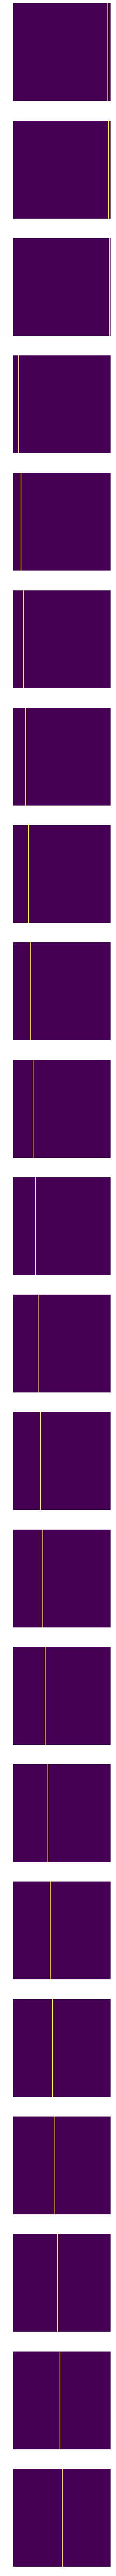

In [61]:
i = 1
fig = plt.figure(figsize=(121,121))
for image in gen_img_temp_train:
    fig.add_subplot(22, 1, i)
    plt.imshow(image)
    plt.xlim(0, data.shape[-1])
    plt.ylim(0, data.shape[-1])
    plt.axis('off')
    i += 1
plt.show()

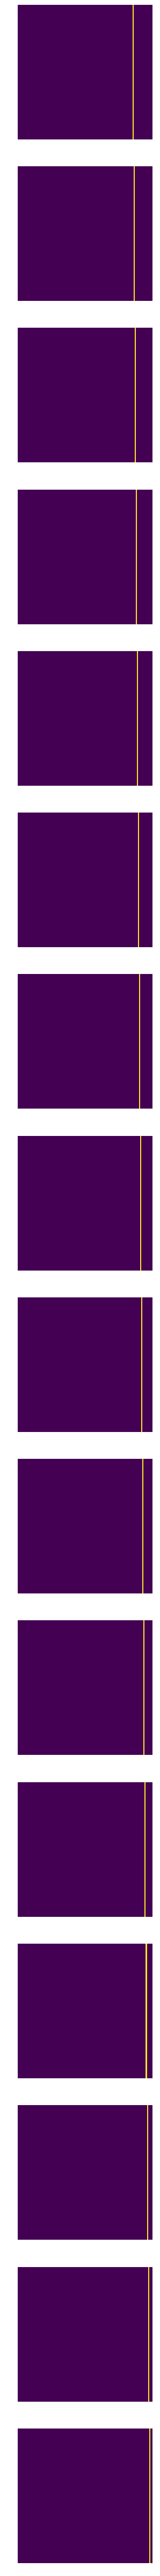

In [62]:
i = 1
fig = plt.figure(figsize=(121,121))
for image in gen_img_temp_val:
    fig.add_subplot(22, 1, i)
    plt.imshow(image)
    plt.xlim(0, data.shape[-1])
    plt.ylim(0, data.shape[-1])
    plt.axis('off')
    i += 1
plt.show()

In [64]:
val_data.shape

(48, 20, 121, 121)

In [67]:
val_embeddings_bars.shape

(912, 1024)

In [70]:
val_embeddings_bars_seq = val_embeddings_bars.reshape(-1,19,1024)

In [71]:
val_embeddings_bars_seq.shape

(48, 19, 1024)

In [73]:
val_videos_bars_seq = val_videos_bars.reshape(-1,19,121,121)

In [74]:
val_videos_bars_seq.shape

(48, 19, 121, 121)

In [89]:
gen_inter_imgs = np.array([])
count_frames = val_videos_bars_seq.shape[1]
embed_first_frame = val_embeddings_bars_seq[0,0,:]
embed_last_frame = val_embeddings_bars_seq[0,-1,:]
for i in range(count_frames):
    lambda_curr = i/(count_frames-1)
    embed_current_frame = (1-lambda_curr)*embed_first_frame + lambda_curr*embed_last_frame
    embed_current_frame = torch.from_numpy(embed_current_frame[np.newaxis,:]).to(DEVICE).float()
    gen_current_img = decoder_network(embed_current_frame)
    print(gen_current_img.size())
    gen_inter_imgs = np.vstack((gen_inter_imgs,gen_current_img.detach().cpu().numpy()[np.newaxis,:])) if gen_inter_imgs.size is not 0 else gen_current_img.detach().cpu().numpy()[np.newaxis,:]


torch.Size([121, 121])
torch.Size([121, 121])
torch.Size([121, 121])
torch.Size([121, 121])
torch.Size([121, 121])
torch.Size([121, 121])
torch.Size([121, 121])
torch.Size([121, 121])
torch.Size([121, 121])
torch.Size([121, 121])
torch.Size([121, 121])
torch.Size([121, 121])
torch.Size([121, 121])
torch.Size([121, 121])
torch.Size([121, 121])
torch.Size([121, 121])
torch.Size([121, 121])
torch.Size([121, 121])
torch.Size([121, 121])


In [90]:
gen_inter_imgs.shape

(19, 121, 121)

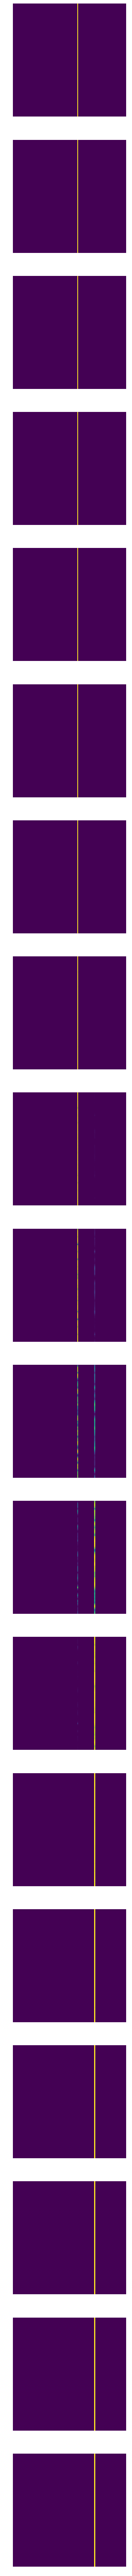

In [91]:
i = 1
fig = plt.figure(figsize=(121,121))
for image in gen_inter_imgs:
    fig.add_subplot(19, 1, i)
    plt.imshow(image)
    plt.xlim(0, data.shape[-1])
    plt.ylim(0, data.shape[-1])
    plt.axis('off')
    i += 1
plt.show()

In [93]:
val_videos_bars_seq.shape

(48, 19, 121, 121)

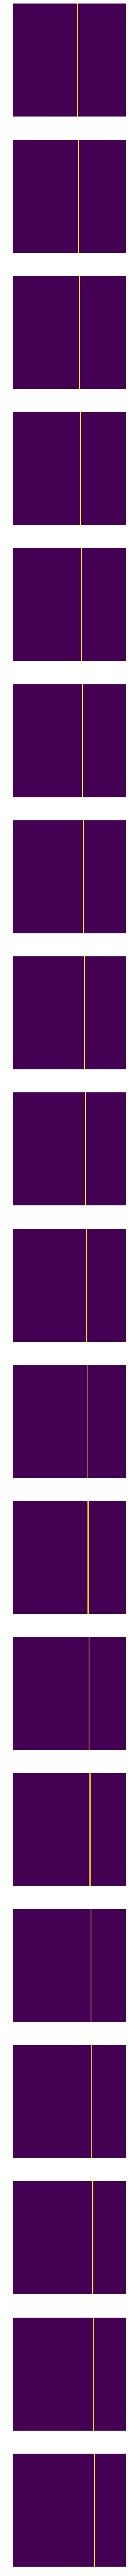

In [94]:
i=1
fig = plt.figure(figsize=(121,121))
for image in val_videos_bars_seq[0,:,:,:]:
    fig.add_subplot(19, 1, i)
    plt.imshow(image)
    plt.xlim(0, data.shape[-1])
    plt.ylim(0, data.shape[-1])
    plt.axis('off')
    i += 1
plt.show()